In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
import seaborn as sns
import ast
import folium
import os
import tensorflow as tf
from tqdm import tqdm
from scipy.stats import ttest_rel
import statsmodels.stats.power as sm_power

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Reshape, RepeatVector, TimeDistributed, Bidirectional
from keras.layers import Conv2D, Flatten, Concatenate, Input
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)
tf.random.set_seed(42)

%config InlineBackend.figure_format = 'retina'

In [2]:
Y_x = pd.read_csv('../Data/TargetX.csv', index_col=0)
Y_y = pd.read_csv('../Data/TargetY.csv', index_col=0)
Y_z = pd.read_csv('../Data/TargetZ.csv', index_col=0)

In [3]:
Y_x.shape

(5817, 42)

In [4]:
cpt = pd.read_csv('../Data/CPT_train_v2.csv', index_col=0)

In [5]:
def scale_features(df):
    """Scale features to be between 0 and 1"""

    df = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    
    return df

In [6]:
cpt = scale_features(cpt)

In [7]:
len(cpt)

30

In [8]:
# only take objects that are in both dataset
Y_x = Y_x[Y_x['objectid'].isin(cpt.index)]
Y_y = Y_y[Y_y['objectid'].isin(cpt.index)]
Y_z = Y_z[Y_z['objectid'].isin(cpt.index)]

Y_x = Y_x.drop(['objectid', 'X_coordinate', 'Y_coordinate', 'segment'], axis=1)
Y_y = Y_y.drop(['objectid', 'X_coordinate', 'Y_coordinate', 'segment'], axis=1)
Y_z = Y_z.drop(['objectid', 'X_coordinate', 'Y_coordinate', 'segment'], axis=1)

In [9]:
Y_x.index.str[:7].unique()

Index(['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101',
       'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702',
       'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601',
       'NHG0201', 'OVW0601', 'PRG0301', 'PRG0401', 'PRG0402', 'SIN0501',
       'SIN0502', 'SIN0601', 'SIN0602', 'SIN0701', 'WEG0201', 'WKN0101'],
      dtype='object')

In [10]:
sat_ver = pd.read_csv('../Data/SatVer.csv', index_col=0)
sat_hor = pd.read_csv('../Data/SatHor.csv', index_col=0)
sat_ach = pd.read_csv('../Data/SatAch.csv', index_col=0)

In [ ]:
# Train on 70% of the objects and 75% of the timeseries
train_Yx = Y_x[0:int(0.7*len(Y_x))].iloc[:, 0:int(0.75*len(Y_x.columns))]
train_Yy = Y_y[0:int(0.7*len(Y_y))].iloc[:, 0:int(0.75*len(Y_y.columns))]
train_Yz = Y_z[0:int(0.7*len(Y_z))].iloc[:, 0:int(0.75*len(Y_z.columns))]

# test on 70% of the objects and 75% of the timeseries
test_Yx = Y_x[0:int(0.7*len(Y_x))].iloc[:, int(0.75*len(Y_x.columns)):]
test_Yx = pd.concat([train_Yx.iloc[:,-5:], test_Yx], axis=1)
test_Yx = test_Yx.fillna(method='ffill', axis=1)
test_Yx = test_Yx[test_Yx.index.isin(train_Yx.dropna().index)]

test_Yy = Y_y[0:int(0.7*len(Y_y))].iloc[:, int(0.75*len(Y_y.columns)):]
test_Yy = pd.concat([train_Yy.iloc[:,-5:], test_Yy], axis=1)
test_Yy = test_Yy.fillna(method='ffill', axis=1)
test_Yy = test_Yy[test_Yy.index.isin(train_Yy.dropna().index)]

test_Yz = Y_z[0:int(0.7*len(Y_z))].iloc[:, int(0.75*len(Y_z.columns)):]
test_Yz = pd.concat([train_Yz.iloc[:,-5:], test_Yz], axis=1)
test_Yz = test_Yz.fillna(method='ffill', axis=1)
test_Yz = test_Yz[test_Yz.index.isin(train_Yz.dropna().index)]

# test on 30% of the object later

In [15]:
train_sat_ver = sat_ver.iloc[:, 0:int(0.75*len(sat_ver.columns))]
train_sat_hor = sat_hor.iloc[:, 0:int(0.75*len(sat_hor.columns))]
train_sat_ach = sat_ach.iloc[:, 0:int(0.75*len(sat_ach.columns))]

train_sat_ver.shape, train_sat_hor.shape, train_sat_ach.shape

((30, 28), (30, 28), (30, 28))

In [18]:
train_Yx.shape

(1163, 28)

In [19]:
train_Yx.index.str[:7].unique()

Index(['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101',
       'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702',
       'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601',
       'NHG0201', 'OVW0601'],
      dtype='object')

In [20]:
def mase(y_true, y_pred):
    
    n_samples, n_timesteps = y_true.shape 
    scaling_factor = 1/(n_timesteps-1) * np.sum(np.abs(np.diff(y_true, axis=1)), axis=1)
    value = np.mean(np.abs(y_true - y_pred), axis=1) / scaling_factor
    
    return np.mean(value)

In [21]:
def create_window(df, input_width, label_width, shift, incl_cpt=False, tacheometry=True, df_cpt=None, incl_sat=False):
    """
    Create training batches of width input_width,
    and labels of width label_width
    """
    
    X = []
    X_ver = []
    X_hor = []
    X_ach = []
    Y = []

    # fix for input per measuring bolt, turns input into correct shape
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df).T
        
    # account for varying months of last measurement
    df = df.dropna()
    
    # current object
    obj = df.index.str[:7][0]
        
    for i in range(len(df.columns)):
        
        # ensure enough values are left for the label
        if i+input_width+label_width <= len(df.columns):
                        
            # add window to X
            X.append(df.iloc[:,i:i+input_width].values)
            
            X_ver.append(train_sat_ver.loc[obj].iloc[i:i+input_width])
            X_hor.append(train_sat_hor.loc[obj].iloc[i:i+input_width])
            X_ach.append(train_sat_ach.loc[obj].iloc[i:i+input_width])
            
            # add label to Y
            Y.append(df.iloc[:,i+input_width:i+input_width+label_width].values)
    
    # shape (batch, time, features)
    X = np.array(X).reshape((len(X), input_width, df.shape[0]))
    Y = np.array(Y).reshape((len(X), label_width, df.shape[0]))
                
    X_ver = np.expand_dims(np.array(X_ver), axis=2)
    X_hor = np.expand_dims(np.array(X_hor), axis=2)
    X_ach = np.expand_dims(np.array(X_ach), axis=2)
        
    # only add cpt features if cpt data is passed
    if incl_cpt == True:
    
        # get cpt values in correct shape 
        cpt_array = np.array(df_cpt.values).reshape((1, 1, len(df_cpt.values)))
        cpt_array = np.repeat(cpt_array, input_width, axis=1)
        cpt_array = np.repeat(cpt_array, len(X), axis=0)
        
        if tacheometry == False:
            X = cpt_array
        
        else:
            # add to X and Y
            X = np.concatenate((X, cpt_array), axis=2)
            
    if incl_sat == True:
        
        X_sat = np.concatenate((X_ver, X_hor), axis=2)
        X_sat = np.concatenate((X_sat, X_ach), axis=2)
        
        if incl_cpt == False and tacheometry == False:
            X = X_sat
            
        else:
            X = np.concatenate((X, X_sat), axis=2)
                
    return X, Y

In [22]:
def evaluate_late_fusion(direction, tacheometry=False, incremental=False):

    # set df to corresponding direction
    if direction == 'X':
        df = train_Yx
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_x[0]
                models2 = models_sat_x[0]
            else:
                models1 = models_inc_cpt_sat_x[0]
                models2 = models_inc_sat_cpt_x[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_x[0]
                models2 = models_tcmt_sat_x[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_x[0]
                models2 = models_inc_tcmt_sat_cpt_x[0]   
                
    if direction == 'Y':
        df = train_Yy
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_y[0]
                models2 = models_sat_y[0]
            else:
                models1 = models_inc_cpt_sat_y[0]
                models2 = models_inc_sat_cpt_y[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_y[0]
                models2 = models_tcmt_sat_y[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_y[0]
                models2 = models_inc_tcmt_sat_cpt_y[0]
                
    if direction == 'Z':
        df = train_Yz
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_z[0]
                models2 = models_sat_z[0]
            else:
                models1 = models_inc_cpt_sat_z[0]
                models2 = models_inc_sat_cpt_z[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_z[0]
                models2 = models_tcmt_sat_z[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_z[0]
                models2 = models_inc_tcmt_sat_cpt_z[0] 

    val_mae = []
    val_rmse = []
    val_mase = []

    for i, obj in enumerate(df.index.str[:7].unique()):

        X_cpt, Y_cpt = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
        train_X_cpt, train_Y_cpt, val_X_cpt, val_Y_cpt = create_validation_set(X_cpt, Y_cpt)

        X_sat, Y_sat = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=tacheometry, incl_sat=True)
        train_X_sat, train_Y_sat, val_X_sat, val_Y_sat = create_validation_set(X_sat, Y_sat)

        model1 = models1[i]
        model2 = models2[i]

        
        if incremental == True:
            
            X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
            train_X_cpt2, train_Y_cpt2, val_X_cpt2, val_Y_cpt2 = create_validation_set(X_cpt2, Y_cpt2)           
        
            X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=False, incl_sat=True)
            train_X_sat2, train_Y_sat2, val_X_sat2, val_Y_sat2 = create_validation_set(X_sat2, Y_sat2)
            
            predictions1 = model1.predict([val_X_cpt, val_X_sat2])
            predictions2 = model2.predict([val_X_sat, val_X_cpt2])
        else:
            predictions1 = model1.predict(val_X_cpt)
            predictions2 = model2.predict(val_X_sat)

        predictions = (predictions1 + predictions2) / 2

        maes = []
        rmses = []
        mases = []

        for j in range(predictions.shape[2]):
            maes.append(mean_absolute_error(val_Y_cpt[:,:,j], predictions[:,:,j]))
            mases.append(mase(val_Y_cpt[:,:,j], predictions[:,:,j]))

            y_act = tf.constant(val_Y_cpt[:,:,j])
            y_pred = tf.constant(predictions[:,:,j])
            rmse = tf.keras.metrics.RootMeanSquaredError()
            rmse_value = rmse(y_act, y_pred).numpy()
            rmses.append(rmse_value)

        val_mae.append(np.mean(maes))
        val_rmse.append(np.mean(rmses))
        val_mase.append(np.mean(mases))

    return val_rmse, val_mae, val_mase

In [23]:
def evaluate_late_fusion_test(direction, tacheometry=False, incremental=False):

    # set df to corresponding direction
    if direction == 'X':
        df = test_Yx
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_x[0]
                models2 = models_sat_x[0]
            else:
                models1 = models_inc_cpt_sat_x[0]
                models2 = models_inc_sat_cpt_x[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_x[0]
                models2 = models_tcmt_sat_x[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_x[0]
                models2 = models_inc_tcmt_sat_cpt_x[0]   
                
    if direction == 'Y':
        df = test_Yy
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_y[0]
                models2 = models_sat_y[0]
            else:
                models1 = models_inc_cpt_sat_y[0]
                models2 = models_inc_sat_cpt_y[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_y[0]
                models2 = models_tcmt_sat_y[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_y[0]
                models2 = models_inc_tcmt_sat_cpt_y[0]
                
    if direction == 'Z':
        df = test_Yz
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_z[0]
                models2 = models_sat_z[0]
            else:
                models1 = models_inc_cpt_sat_z[0]
                models2 = models_inc_sat_cpt_z[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_z[0]
                models2 = models_tcmt_sat_z[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_z[0]
                models2 = models_inc_tcmt_sat_cpt_z[0] 

    val_mae = []
    val_rmse = []
    val_mase = []

    for i, obj in enumerate(df.index.str[:7].unique()):

        X_cpt, Y_cpt = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

        X_sat, Y_sat = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=tacheometry, incl_sat=True)

        model1 = models1[i]
        model2 = models2[i]

        
        if incremental == True:
            
            X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
        
            X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=False, incl_sat=True)
            
            predictions1 = model1.predict([X_cpt, X_sat2])
            predictions2 = model2.predict([X_sat, X_cpt2])
        else:
            predictions1 = model1.predict(X_cpt)
            predictions2 = model2.predict(X_sat)

        predictions = (predictions1 + predictions2) / 2

        maes = []
        rmses = []
        mases = []

        for j in range(predictions.shape[2]):
            maes.append(mean_absolute_error(Y_cpt[:,:,j], predictions[:,:,j]))
            mases.append(mase(Y_cpt[:,:,j], predictions[:,:,j]))

            y_act = tf.constant(Y_cpt[:,:,j])
            y_pred = tf.constant(predictions[:,:,j])
            rmse = tf.keras.metrics.RootMeanSquaredError()
            rmse_value = rmse(y_act, y_pred).numpy()
            rmses.append(rmse_value)

        val_mae.append(np.mean(maes))
        val_rmse.append(np.mean(rmses))
        val_mase.append(np.mean(mases))

    return val_rmse, val_mae, val_mase

In [24]:
def create_validation_set(X, Y, splits=4):
    """
    Takes windowed training set as input,
    Splits off validation set, size equals number of splits
    """
    
    # take first windows as training set
    X_train = X[:X.shape[0]-splits]
    Y_train = Y[:Y.shape[0]-splits]
    
    # take last windows as validation set
    X_val = X[X.shape[0]-splits:]
    Y_val = Y[Y.shape[0]-splits:]
    
    return X_train, Y_train, X_val, Y_val

In [25]:
def load_models(combi, direction):
    """
    Load models
    """
    models = []
    directory = f'../Models/{combi}/{direction}'
    
    for file in tqdm(os.listdir(directory)):
        models.append(tf.keras.models.load_model(f'{directory}/{file}'))

    return models

In [26]:
def evaluate(direction, models, input_width, label_width, shift, incl_cpt=False, incl_sat=False, tacheometry=False, incremental=False, incremental_first='CPT'):
    
    # set df to corresponding direction
    if direction == 'X':
        df = train_Yx
                
    if direction == 'Y':
        df = train_Yy
        
    if direction == 'Z':
        df = train_Yz
        
    val_rmse = []
    val_mae = []
    val_mase = []
    all_predictions = []
    
    for i, obj in enumerate(df.index.str[:7].unique()):

        X, Y = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=incl_cpt, \
                                     incl_sat=incl_sat, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
        train_X, train_Y, val_X, val_Y = create_validation_set(X, Y)
        
        if models == 'naive':
            naives = NaiveBaseline(val_X, val_Y)
            val_rmse.append(naives[0])
            val_mae.append(naives[1])
            val_mase.append(naives[2])
            continue
        else:
        
            model = models[i]

            if incremental == True:

                X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=True, \
                                               tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
                train_X_cpt2, train_Y_cpt2, val_X_cpt2, val_Y_cpt2 = create_validation_set(X_cpt2, Y_cpt2)           

                X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=False, \
                                               tacheometry=False, incl_sat=True)
                train_X_sat2, train_Y_sat2, val_X_sat2, val_Y_sat2 = create_validation_set(X_sat2, Y_sat2)

                if incremental_first == 'CPT':
                    predictions = model.predict([val_X, val_X_sat2])
                else:
                    predictions = model.predict([val_X, val_X_cpt2])

            else:
                predictions = model.predict(val_X)

            rmses = []
            maes = []
            mases = []

            for j in range(predictions.shape[2]):
                maes.append(mean_absolute_error(val_Y[:,:,j], predictions[:,:,j]))
                mases.append(mase(val_Y[:,:,j], predictions[:,:,j]))

                y_act = tf.constant(val_Y[:,:,j])
                y_pred = tf.constant(predictions[:,:,j])

                rmse = tf.keras.metrics.RootMeanSquaredError()
                rmse_value = rmse(y_act, y_pred).numpy()
                rmses.append(rmse_value)

            val_rmse.append(np.mean(rmses))
            val_mae.append(np.mean(maes))
            val_mase.append(np.mean(mases))
        
    return val_rmse, val_mae, val_mase

In [27]:
def evaluate_test(direction, models, input_width, label_width, shift, incl_cpt=False, incl_sat=False, tacheometry=False, incremental=False, incremental_first='CPT'):
    
    # set df to corresponding direction
    if direction == 'X':
        df = test_Yx
                
    if direction == 'Y':
        df = test_Yy
        
    if direction == 'Z':
        df = test_Yz
        
    val_rmse = []
    val_mae = []
    val_mase = []
    all_predictions = []
    
    for i, obj in enumerate(df.index.str[:7].unique()):  
        
        X, Y = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=incl_cpt, \
                                     incl_sat=incl_sat, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
        
        if models == 'naive':
            naives = NaiveBaseline(X, Y)
            val_rmse.append(naives[0])
            val_mae.append(naives[1])
            val_mase.append(naives[2])
            continue
            
        else:
        
            model = models[i]

            if incremental == True:

                X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=True, \
                                               tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

                X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=False, \
                                               tacheometry=False, incl_sat=True)

                if incremental_first == 'CPT':
                    predictions = model.predict([X, X_sat2])
                else:
                    predictions = model.predict([X, X_cpt2])

            else:
                predictions = model.predict(X)

            rmses = []
            maes = []
            mases = []

            for j in range(predictions.shape[2]):
                maes.append(mean_absolute_error(Y[:,:,j], predictions[:,:,j]))
                mases.append(mase(Y[:,:,j], predictions[:,:,j]))

                y_act = tf.constant(Y[:,:,j])
                y_pred = tf.constant(predictions[:,:,j])

                rmse = tf.keras.metrics.RootMeanSquaredError()
                rmse_value = rmse(y_act, y_pred).numpy()
                rmses.append(rmse_value)

            val_rmse.append(np.mean(rmses))
            val_mae.append(np.mean(maes))
            val_mase.append(np.mean(mases))
        
    return val_rmse, val_mae, val_mase

In [28]:
def significance_test(results1, results2, alpha=0.05):
    
    results1 = np.array(results1).flatten()
    results2 = np.array(results2).flatten()
        
    n = len(results1)
    diff = np.mean(results1) - np.mean(results2)
    d = diff / np.std(results1 - results2)
    
    power_analysis = sm_power.TTestPower()
    power = power_analysis.power(effect_size=d, nobs=n, alpha=alpha, alternative='smaller')
    
    t_stat, p_value = ttest_rel(results1, results2)
    
    print(f'T-statistic = {t_stat}')
    print(f'p-value = {p_value}')
    print(f'Power = {power}')

    return t_stat, p_value, power

In [29]:
def create_table_metrics(results, model="MISSING MODEL", direction="MISSING DIRECTION"):
    objects = cpt.index[:20]
    
    val_rmse = results[0]
    val_mae = results[1]
    val_mase = results[2]
    
    df = pd.DataFrame({'RMSE': val_rmse, 'MAE': val_mae, 'MASE': val_mase}, index=objects)
    df.columns.name = f"Results of {model} model in {direction}-direction"
    
    return df

In [30]:
def plot_metrics(metric_list, model="MODEL", direction="N"):
    objects = cpt.index[:20]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    for i, metric in enumerate(["RMSE", "MAE", "MASE"]):
    
        sns.set(style='whitegrid', palette='colorblind')
        sns.barplot(x=objects, y=metric_list[i], ax=axes[i])
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'{metric} over Racks for model {model} in {direction}-direction.')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    
    plt.tight_layout()    
    fig.subplots_adjust(wspace=0.5)
    plt.show()
    
    return

In [31]:
def NaiveBaseline(X, Y):
    """
    Create baseline prediction with naive method.
    Gives the last value as prediction
    """
    
    # predict last 5 elements of X window
    Y_pred = X[:,-6:-1,0]
    
    # compare against the 5 Y values in label
    Y_act = Y[:,:,0]
    
    # return mae and rmse
    return mean_squared_error(Y_act, Y_pred, squared=False), mean_absolute_error(Y_act, Y_pred), mase(Y_act, Y_pred)

## Baseline

#### Naive

In [ ]:
results_naive_x = evaluate('X', 'naive', 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_naive_y = evaluate('Y', 'naive', 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_naive_z = evaluate('Z', 'naive', 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)

In [ ]:
naive_all = np.array(results_naive_x + results_naive_y + results_naive_z).flatten()

In [53]:
results_naive_x_test = evaluate_test('X', 'naive', 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_naive_y_test = evaluate_test('Y', 'naive', 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_naive_z_test = evaluate_test('Z', 'naive', 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)

In [54]:
naive_all_test = np.array(results_naive_x_test + results_naive_y_test + results_naive_z_test).flatten()

In [33]:
print(np.mean(results_naive_x_test, axis=1), np.mean(results_naive_y_test, axis=1), np.mean(results_naive_z_test, axis=1))
# print(results_naive_x_test)

[1.72676342 1.72676342 1.13543191] [3.33561194 3.33561194 1.26867808] [1.72676342 1.72676342 1.13543191]


#### TCMT

In [39]:
models_tcmt_x = [load_models('TCMT', 'X')]
models_tcmt_y = [load_models('TCMT', 'Y')]
models_tcmt_z = [load_models('TCMT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.83s/it]


In [59]:
results_tcmt_x = evaluate('X', models_tcmt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_y = evaluate('Y', models_tcmt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_z = evaluate('Z', models_tcmt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)

In [60]:
tcmt_all = np.array(results_tcmt_x + results_tcmt_y + results_tcmt_z).flatten()

In [40]:
results_tcmt_x_test = evaluate_test('X', models_tcmt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_y_test = evaluate_test('Y', models_tcmt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_z_test = evaluate_test('Z', models_tcmt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)

In [41]:
print(np.mean(results_tcmt_x_test, axis=1), np.mean(results_tcmt_y_test, axis=1), np.mean(results_tcmt_z_test, axis=1))

[4.53517553 3.71584936 2.26471893] [11.27858739  8.93411929  2.17599681] [5.02835566 4.14856614 2.41797969]


In [52]:
tcmt_all_test = np.array(results_tcmt_x_test + results_tcmt_y_test + results_tcmt_z_test).flatten()

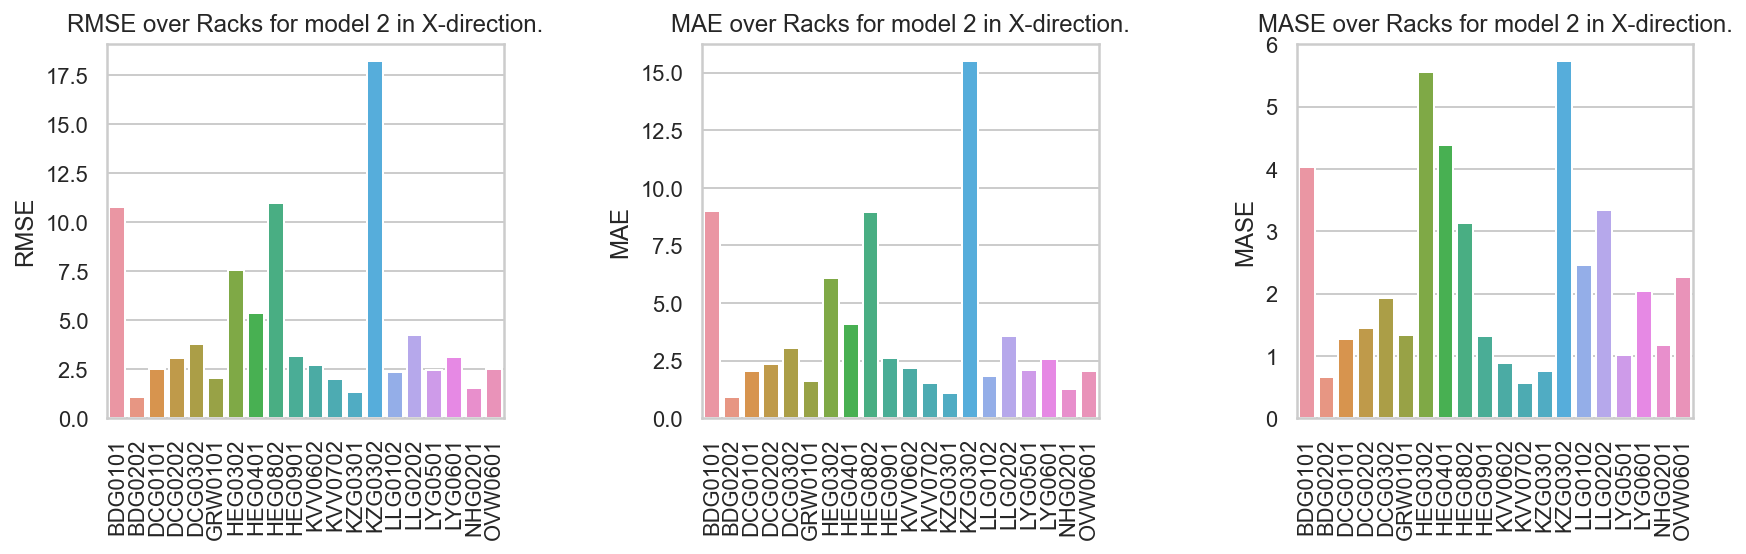

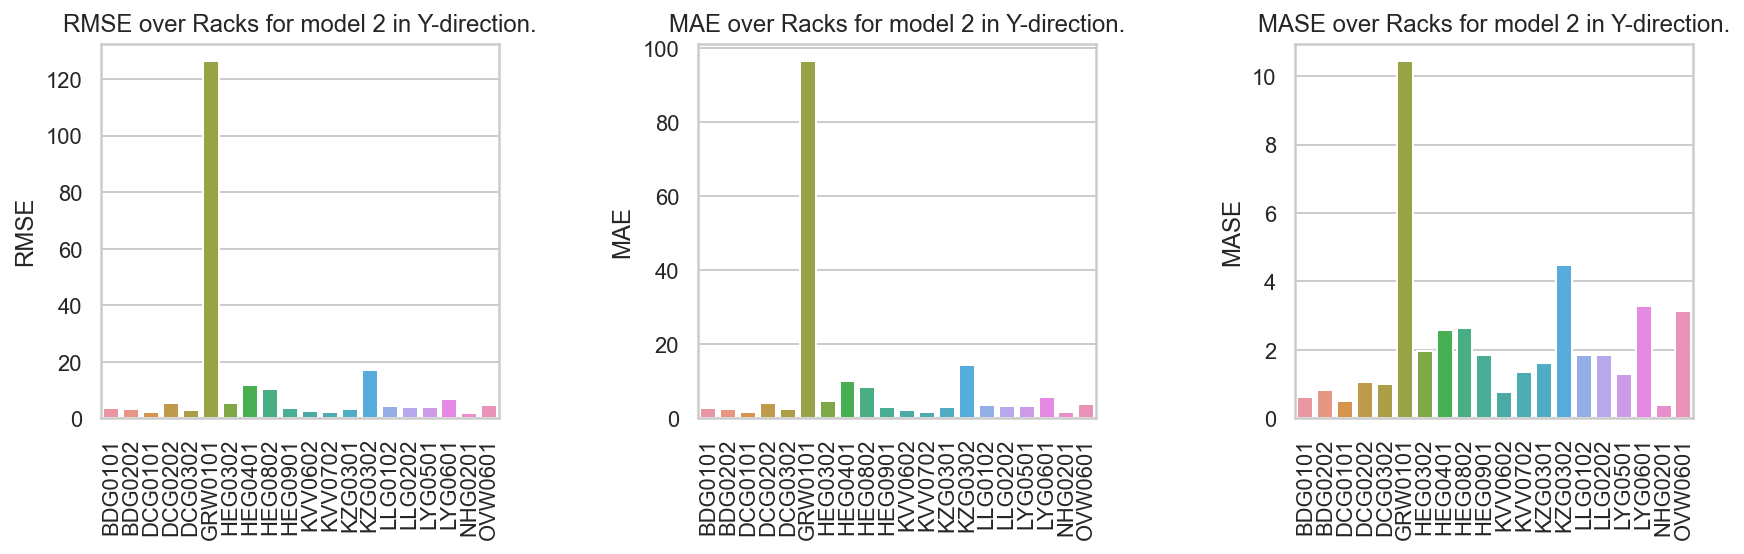

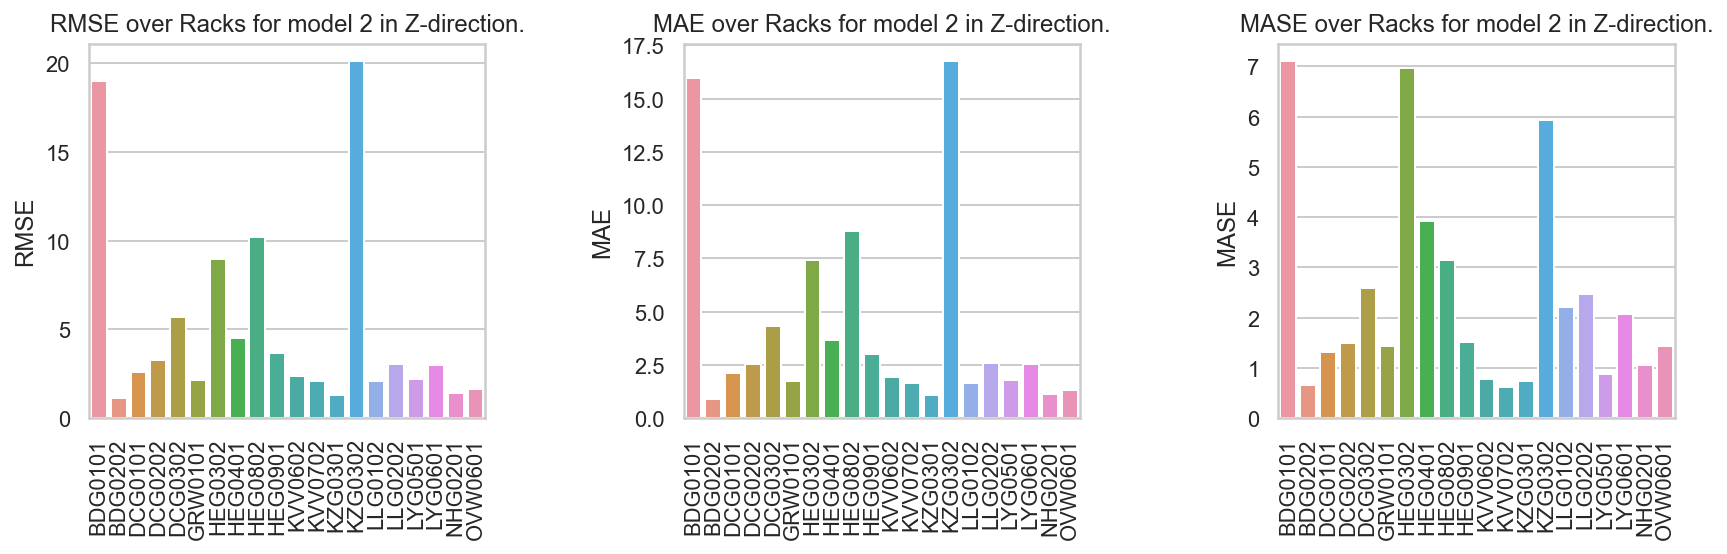

(None, None, None)

In [47]:
plot_metrics(results_tcmt_x_test, '2', 'X'), plot_metrics(results_tcmt_y_test, '2', 'Y'), plot_metrics(results_tcmt_z_test, '2', 'Z')

#### CPT

In [50]:
models_tcmt_cpt_x = [load_models('TCMT_CPT', 'X')]
models_tcmt_cpt_y = [load_models('TCMT_CPT', 'Y')]
models_tcmt_cpt_z = [load_models('TCMT_CPT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.86s/it]


In [58]:
results_tcmt_cpt_x = evaluate('X', models_tcmt_cpt_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_cpt_y = evaluate('Y', models_tcmt_cpt_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_cpt_z = evaluate('Z', models_tcmt_cpt_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False)

In [51]:
results_tcmt_cpt_x_test = evaluate_test('X', models_tcmt_cpt_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_cpt_y_test = evaluate_test('Y', models_tcmt_cpt_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_cpt_z_test = evaluate_test('Z', models_tcmt_cpt_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False)

In [46]:
print(np.mean(results_tcmt_cpt_x_test, axis=1), np.mean(results_tcmt_cpt_y_test, axis=1), np.mean(results_tcmt_cpt_z_test, axis=1))

[4.49659262 3.65998094 2.2308348 ] [6.8902617  5.5663462  1.78116209] [3.7500724  3.01590455 1.76647763]


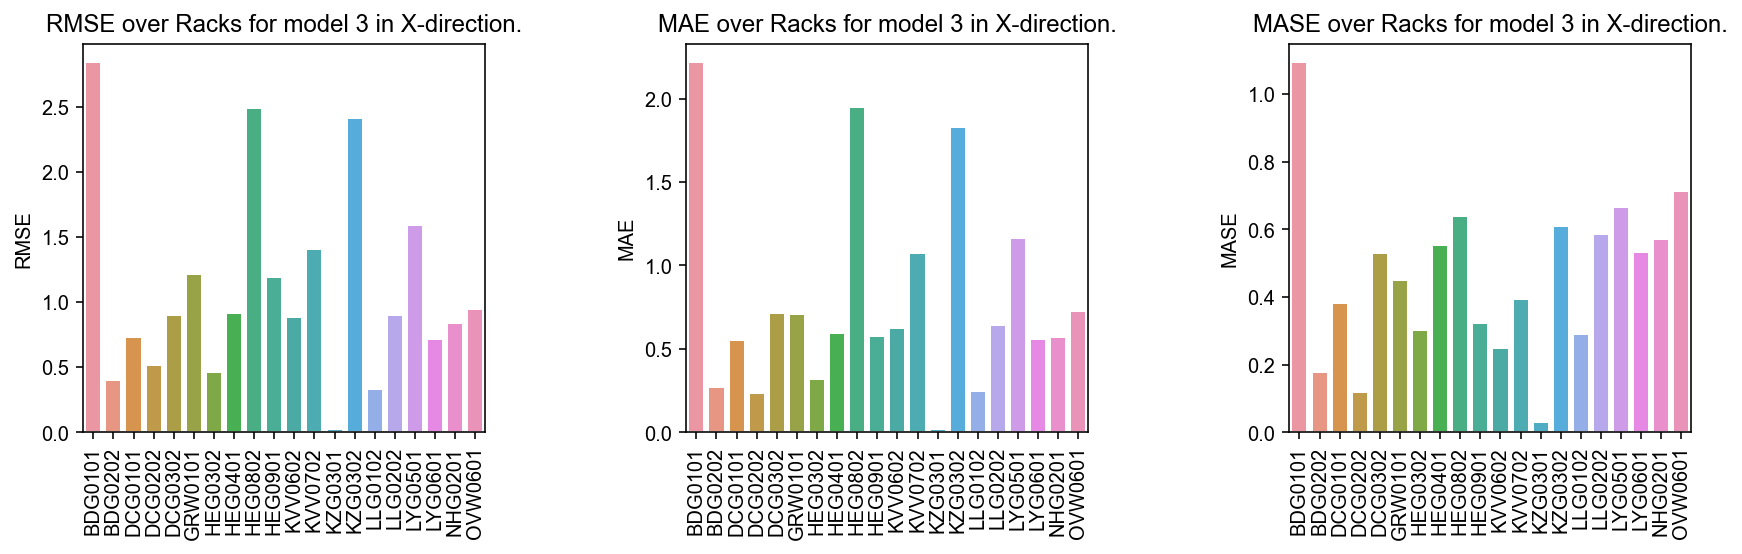

In [21]:
plot_metrics(results_tcmt_cpt_x, '3', 'X')

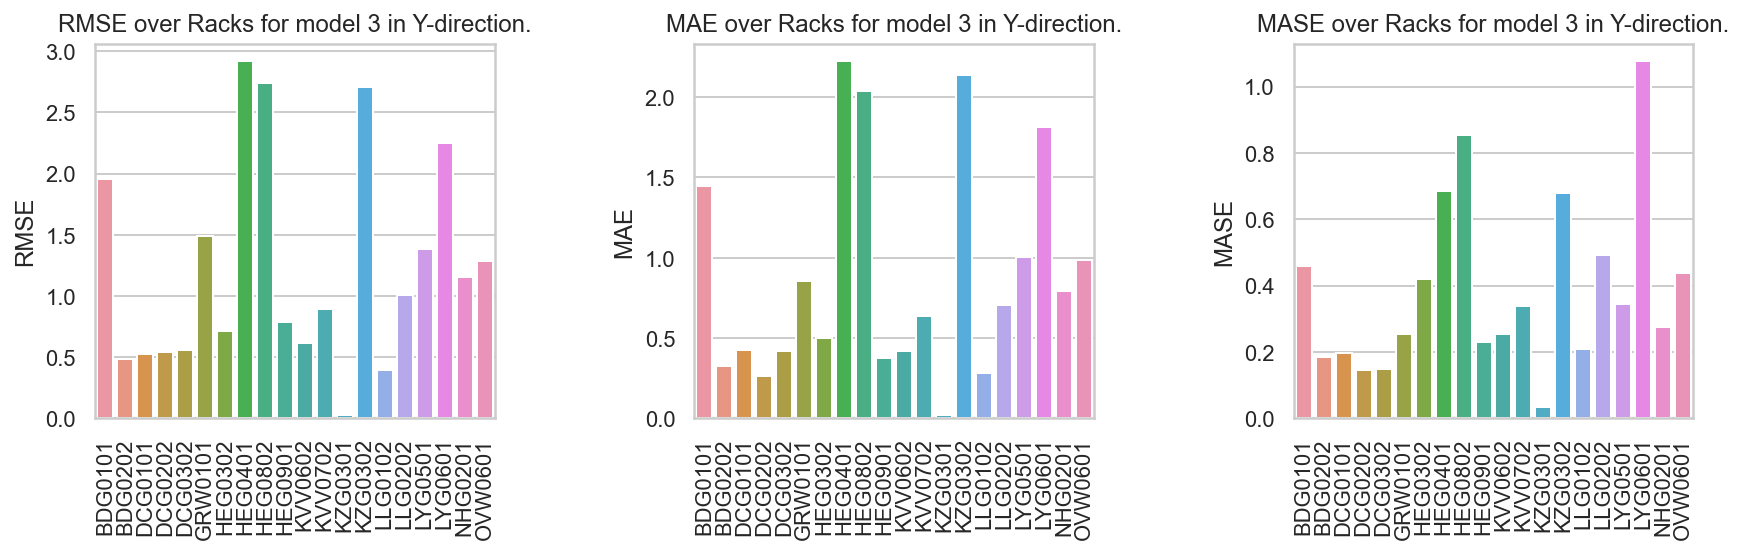

In [22]:
plot_metrics(results_tcmt_cpt_y, '3', 'Y')

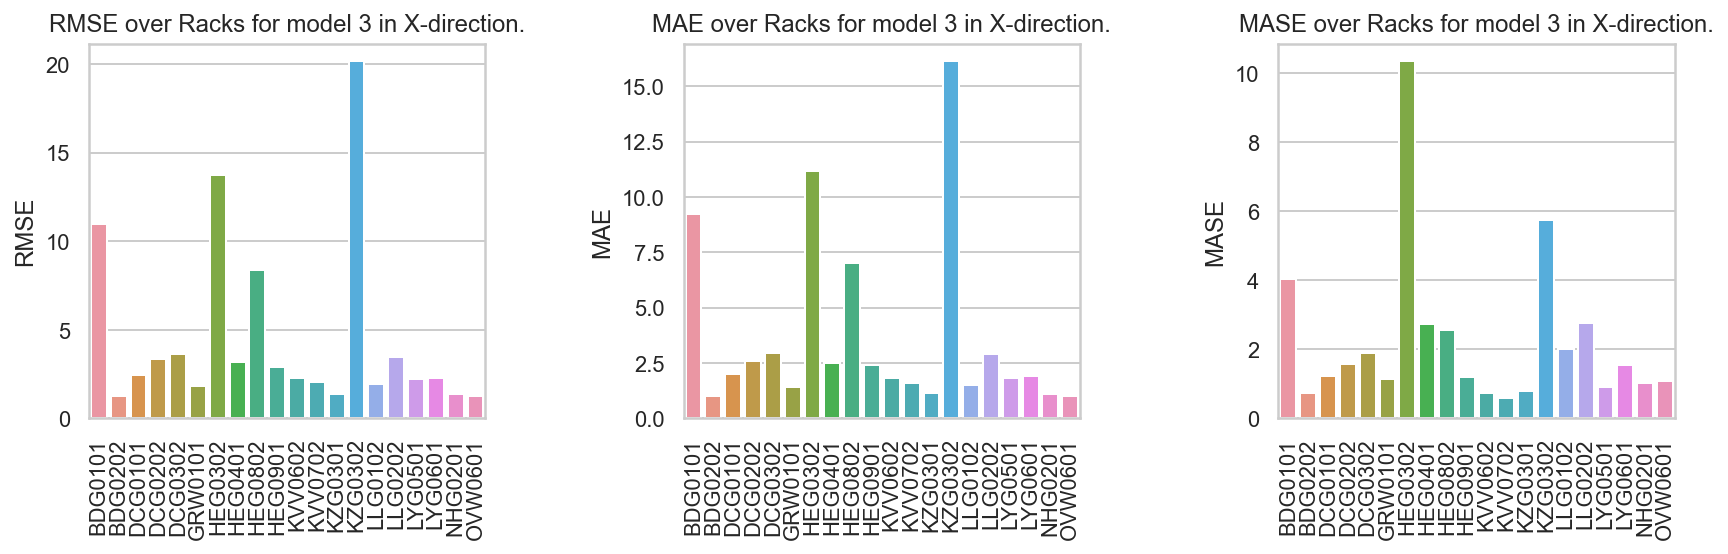

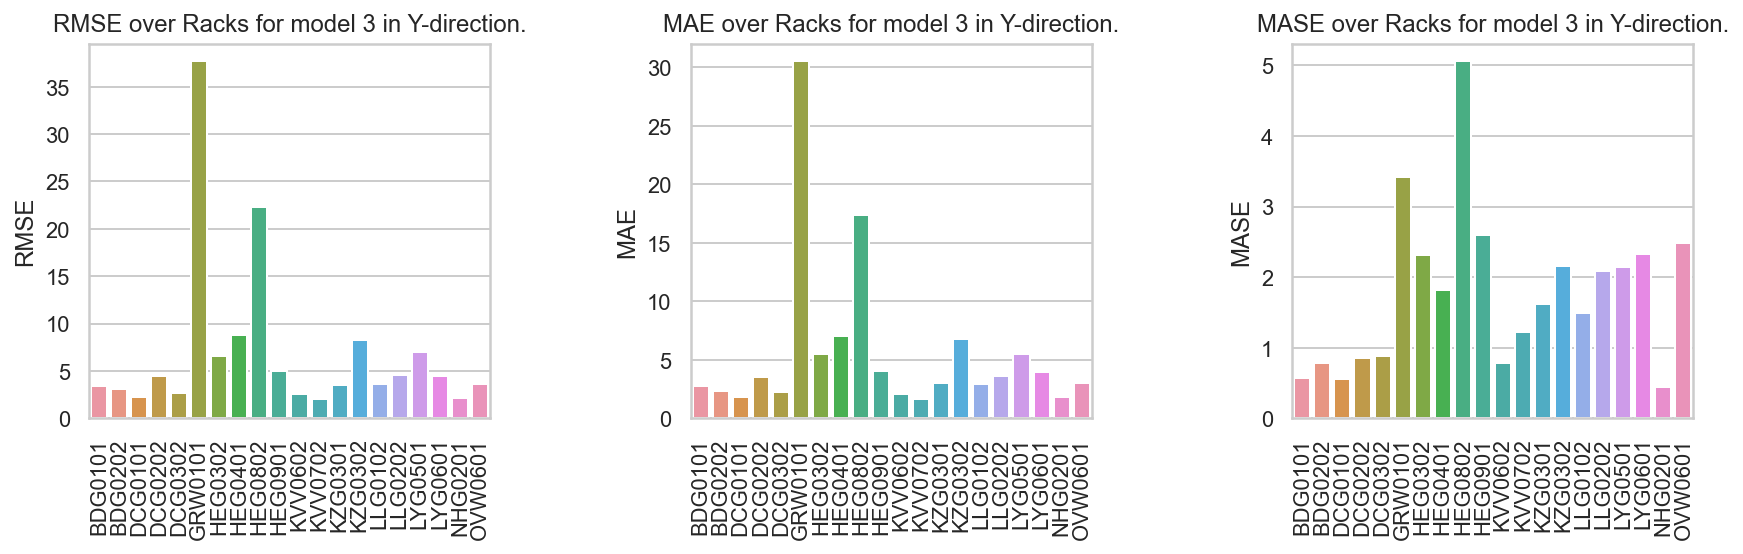

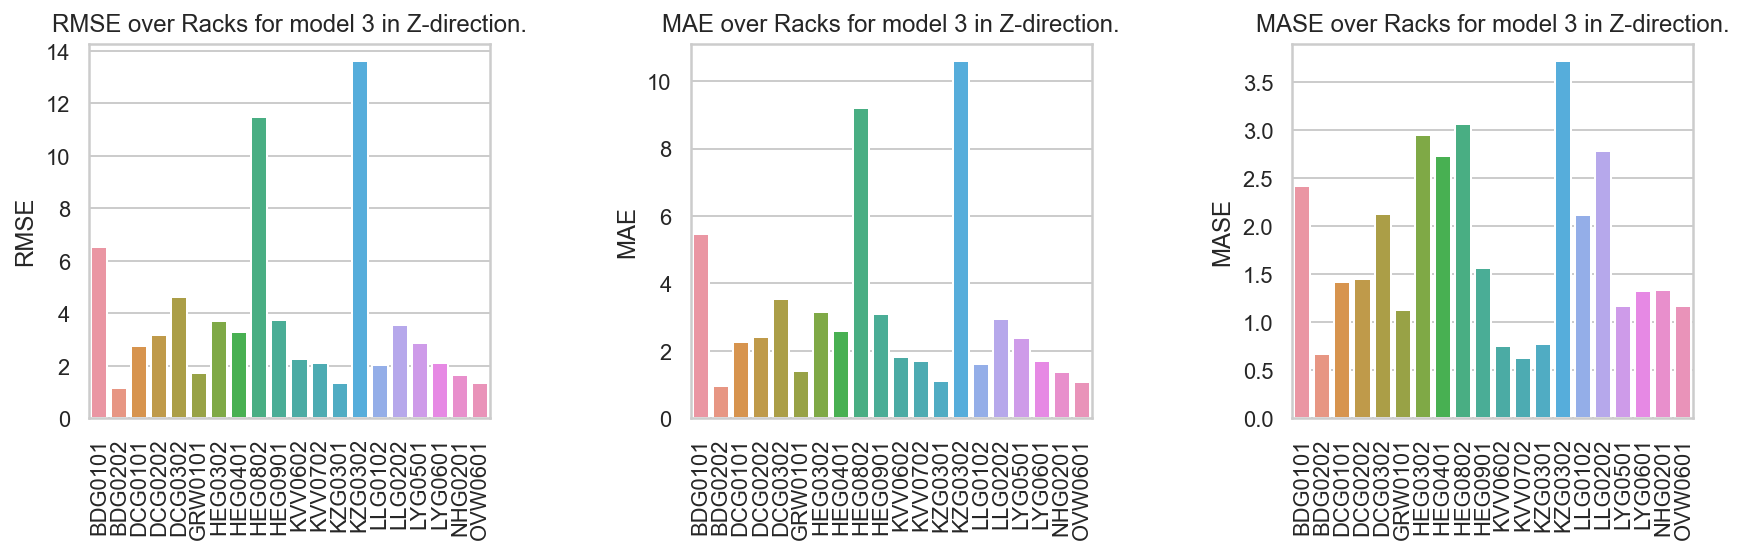

(None, None, None)

In [48]:
plot_metrics(results_tcmt_cpt_x_test, '3', 'X'), plot_metrics(results_tcmt_cpt_y_test, '3', 'Y'), plot_metrics(results_tcmt_cpt_z_test, '3', 'Z')

#### Sat

In [35]:
models_tcmt_sat_x = [load_models('TCMT_SAT', 'X')]
models_tcmt_sat_y = [load_models('TCMT_SAT', 'Y')]
models_tcmt_sat_z = [load_models('TCMT_SAT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.29s/it]


In [21]:
results_tcmt_sat_x = evaluate('X', models_tcmt_sat_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_sat_y = evaluate('Y', models_tcmt_sat_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_sat_z = evaluate('Z', models_tcmt_sat_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False)

In [38]:
results_tcmt_sat_x_test = evaluate_test('X', models_tcmt_sat_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_sat_y_test = evaluate_test('Y', models_tcmt_sat_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_sat_z_test = evaluate_test('Z', models_tcmt_sat_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False)

In [65]:
print(np.mean(results_tcmt_sat_x_test, axis=1), np.mean(results_tcmt_sat_y_test, axis=1), np.mean(results_tcmt_sat_z_test, axis=1))

[3.146016   2.56671451 1.46886377] [4.30502064 3.50525283 1.24847053] [3.24170444 2.65651609 1.46735819]


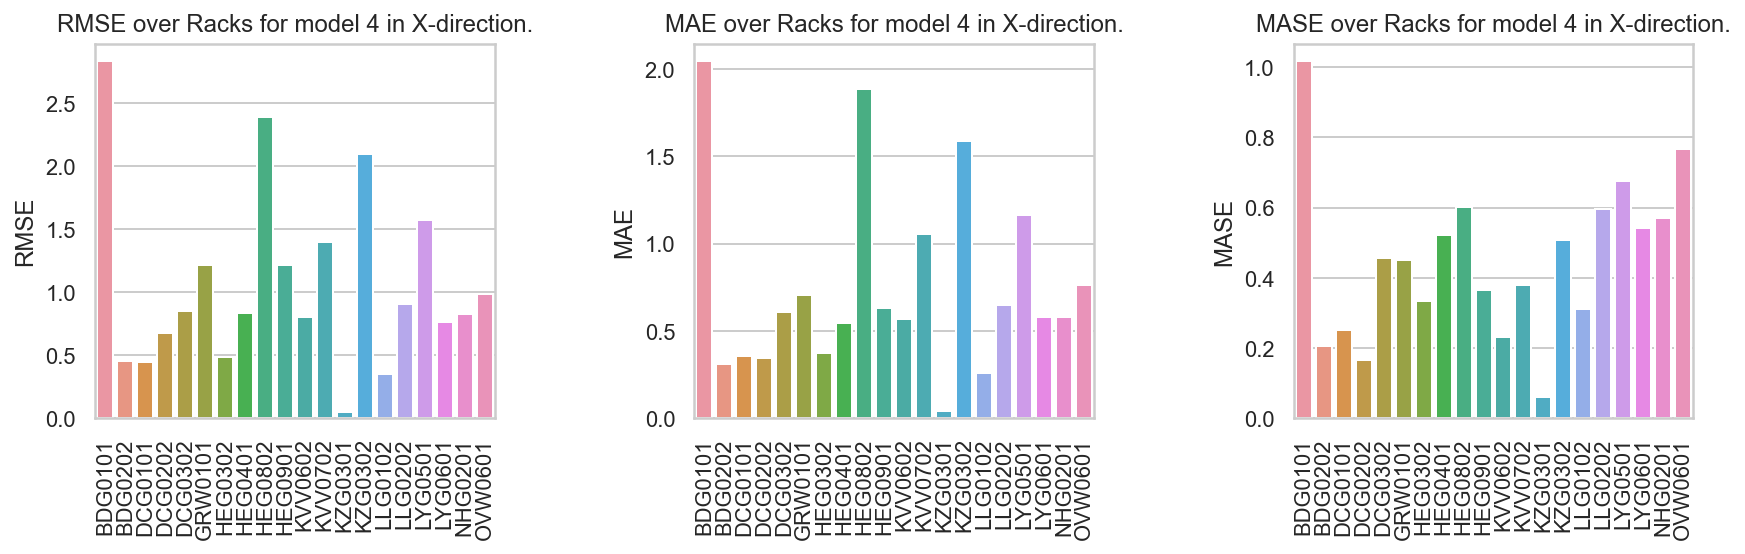

In [26]:
plot_metrics(results_tcmt_sat_x, '4', 'X')

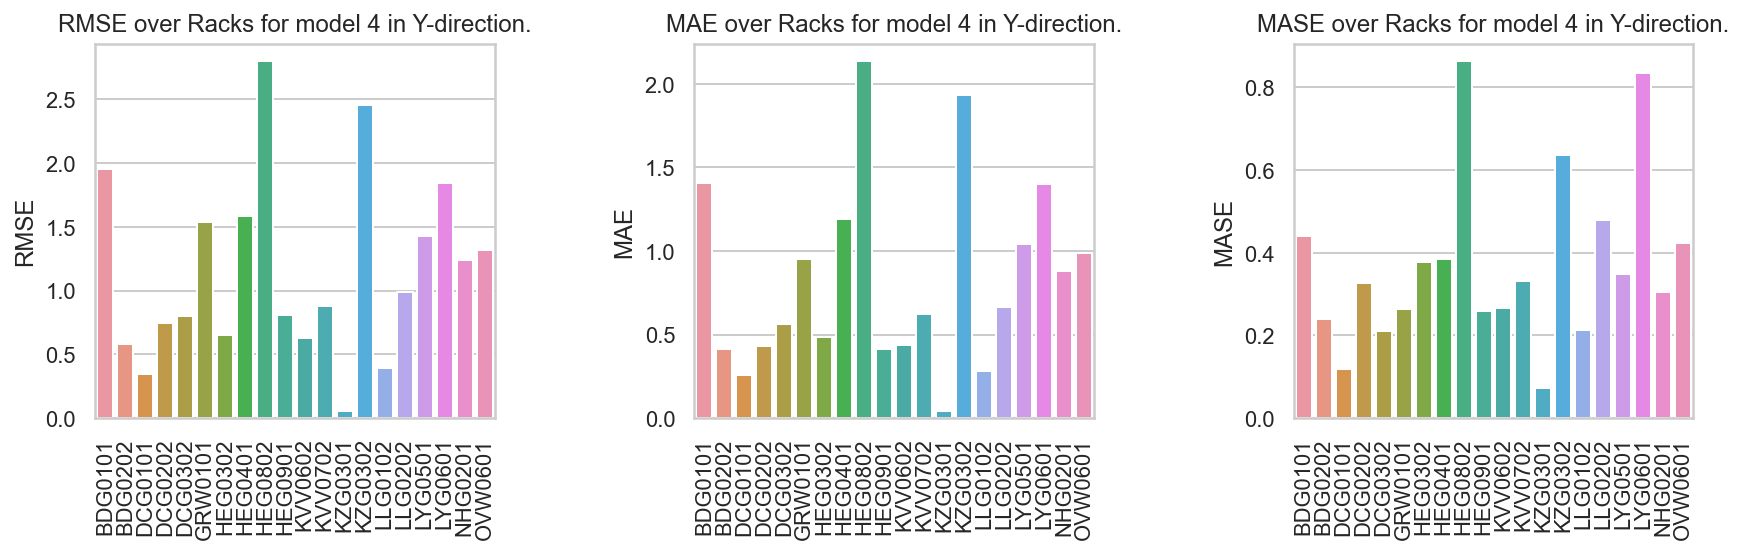

In [27]:
plot_metrics(results_tcmt_sat_y, '4', 'Y')

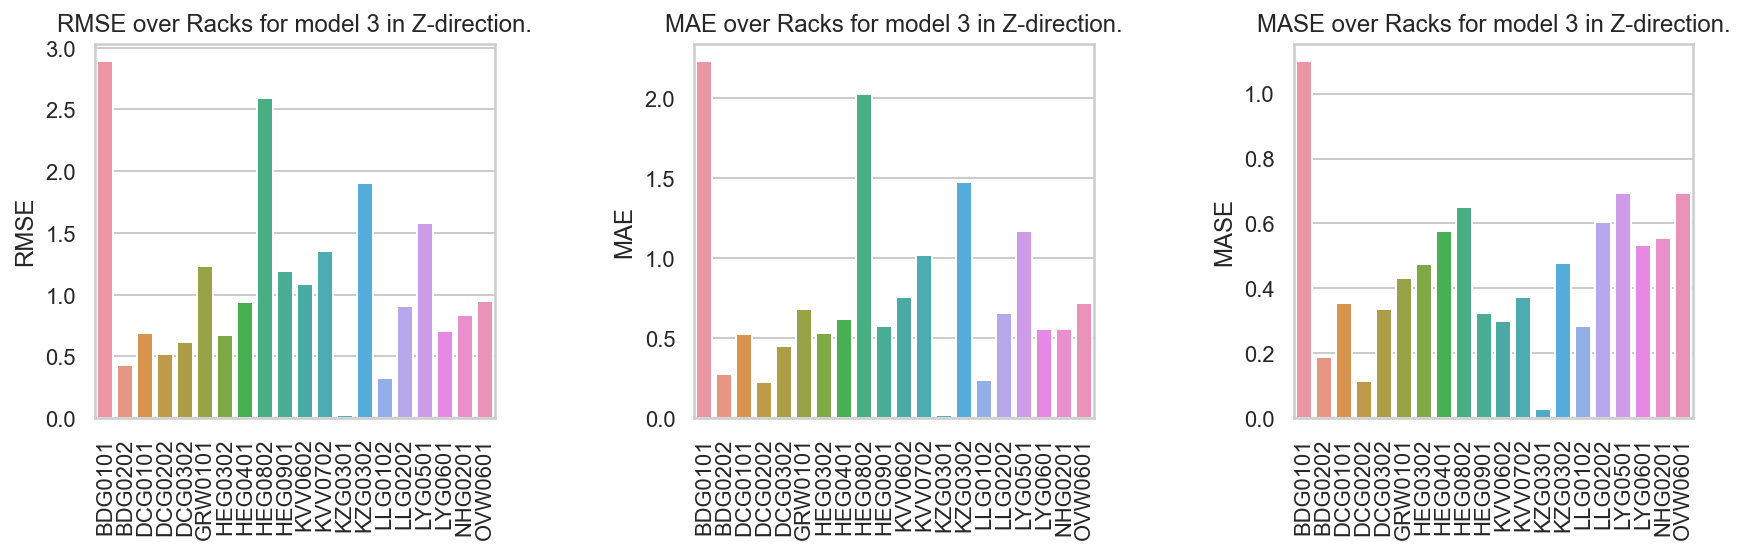

In [23]:
plot_metrics(results_tcmt_cpt_z, '3', 'Z')

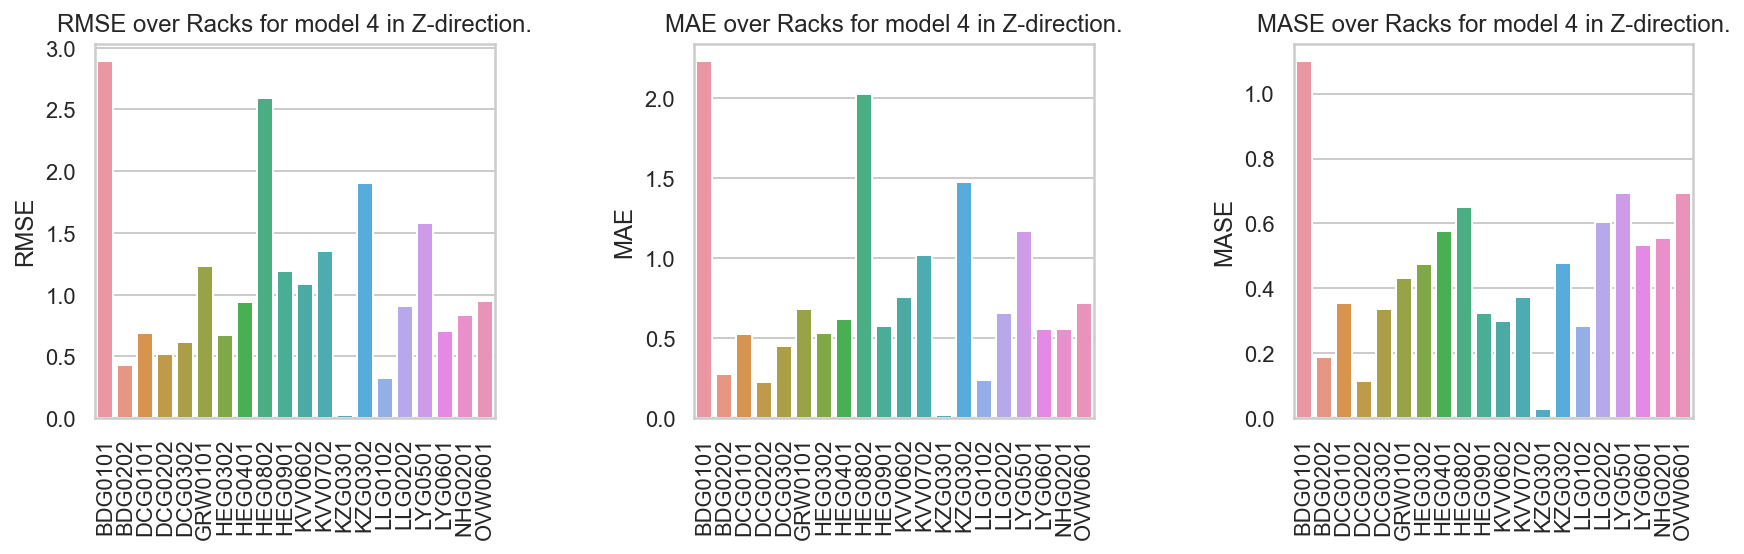

In [28]:
plot_metrics(results_tcmt_cpt_z, '4', 'Z')

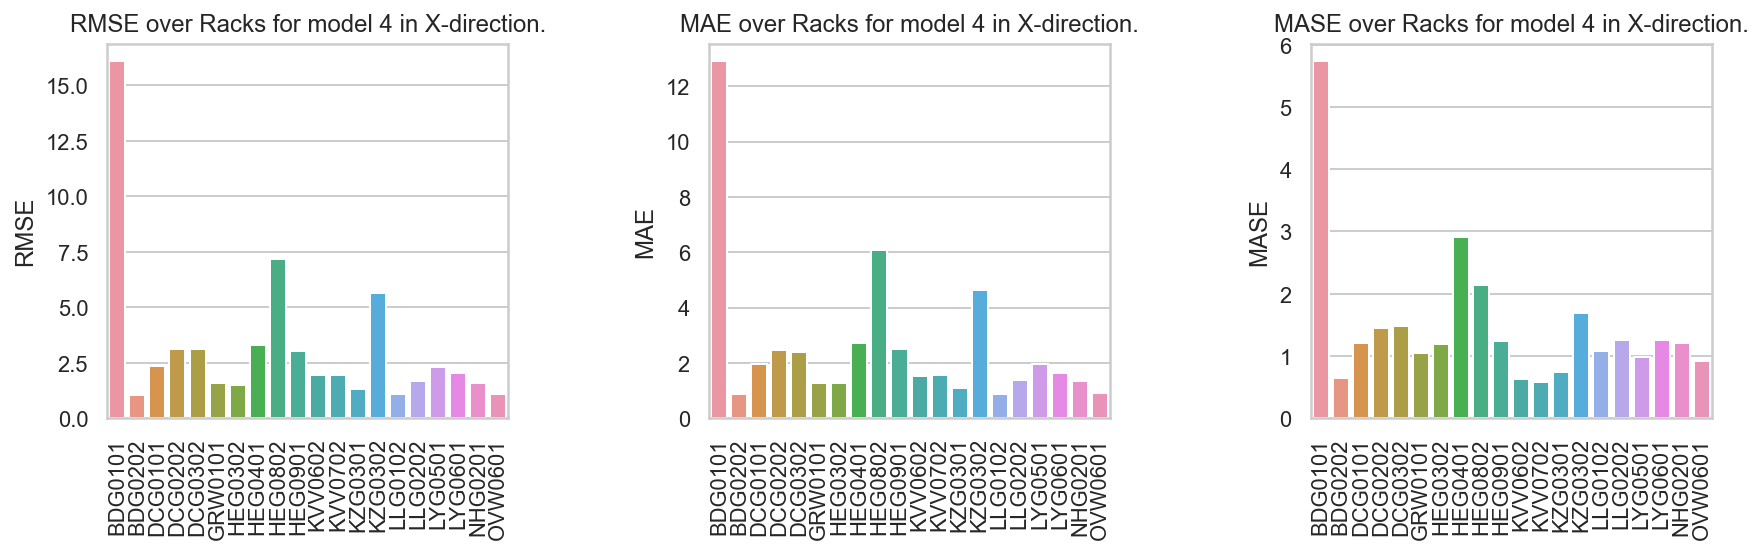

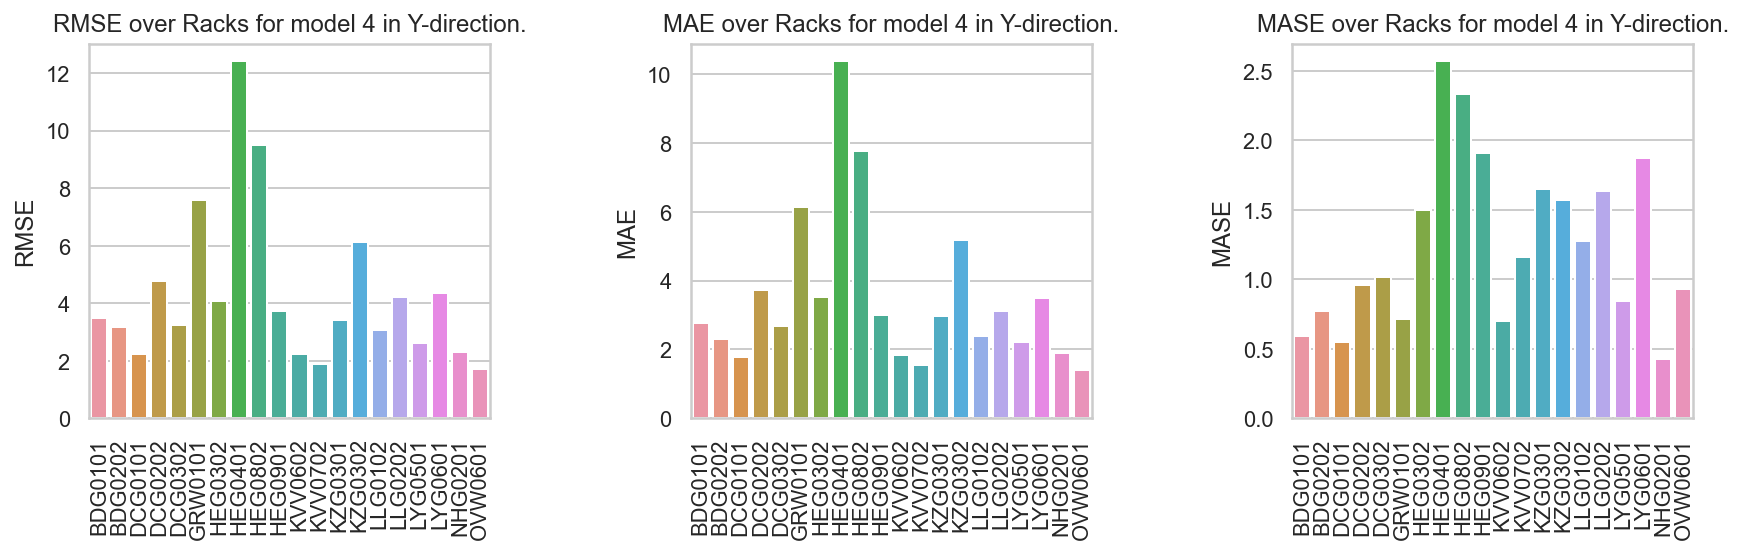

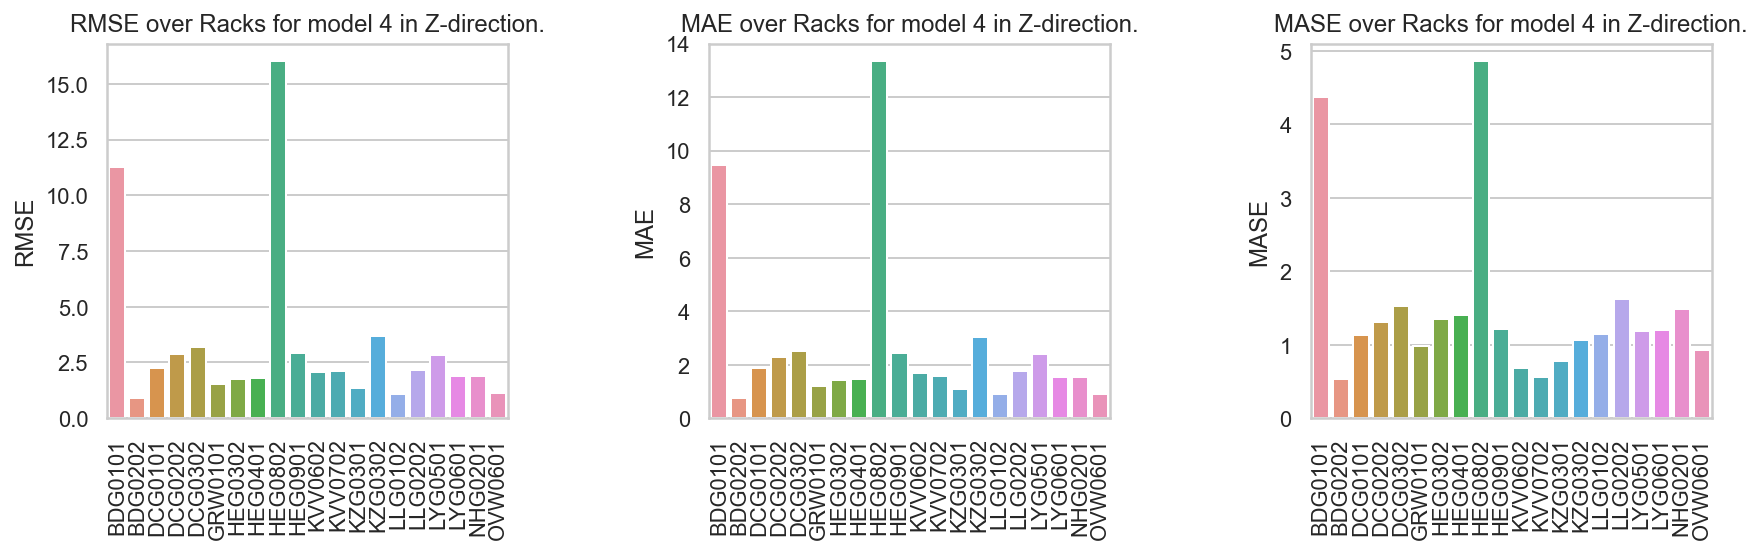

(None, None, None)

In [66]:
plot_metrics(results_tcmt_sat_x_test, '4', 'X'), plot_metrics(results_tcmt_sat_y_test, '4', 'Y'), plot_metrics(results_tcmt_sat_z_test, '4', 'Z')

# T-Tests

In [61]:
tcmt_cpt_all = np.array(results_tcmt_cpt_x + results_tcmt_cpt_y + results_tcmt_cpt_z).flatten()
tcmt_sat_all = np.array(results_tcmt_sat_x + results_tcmt_sat_y + results_tcmt_sat_z).flatten()

In [42]:
# TCMT > Naive
significance_test(tcmt_all, naive_all)

T-statistic = -10.48260215690161
p-value = 2.379257597187838e-20
Power = 1.0


(-10.48260215690161, 2.379257597187838e-20, 1.0)

In [62]:
# CPT > TCMT
significance_test(tcmt_cpt_all, tcmt_all)

T-statistic = -2.947020852874824
p-value = 0.0036359064100216503
Power = 0.9030606309730593


(-2.947020852874824, 0.0036359064100216503, 0.9030606309730593)

In [99]:
# Sat > CPT
significance_test(tcmt_sat_all, tcmt_cpt_all)

T-statistic = -2.0188694917823278
p-value = 0.04499297635869496
Power = 0.6450488007772167


(-2.0188694917823278, 0.04499297635869496, 0.6450488007772167)

In [32]:
tcmt_cpt_sat_all = np.array(results_tcmt_cpt_sat_x + results_tcmt_cpt_sat_y + results_tcmt_cpt_sat_z).flatten()

In [28]:
# CPT + Sat > Sat
significance_test(tcmt_cpt_sat_all, tcmt_sat_all)

T-statistic = -0.868164230167229
p-value = 0.3864668823115176
Power = 0.21841540964561007


(-0.868164230167229, 0.3864668823115176, 0.21841540964561007)

In [28]:
# CPT + Sat > CPT
significance_test(tcmt_cpt_sat_all, tcmt_cpt_all)

T-statistic = -2.793009780421419
p-value = 0.005790146347927992
Power = 0.873965207675776


(-2.793009780421419, 0.005790146347927992, 0.873965207675776)

In [22]:
# CPT <- Sat > CPT + Sat
significance_test(inc_tcmt_cpt_sat_all, tcmt_cpt_sat_all)

T-statistic = -3.3921198438467464
p-value = 0.0008536382424669909
Power = 0.9594056785400482


(-3.3921198438467464, 0.0008536382424669909, 0.9594056785400482)

In [26]:
# CPT <- Sat > Sat
significance_test(inc_tcmt_cpt_sat_all, tcmt_sat_all)

T-statistic = -3.9800441150215886
p-value = 0.00010000661617710259
Power = 0.9901271622526538


(-3.9800441150215886, 0.00010000661617710259, 0.9901271622526538)

In [28]:
# Sat <- CPT > CPT + Sat
inc_tcmt_sat_cpt_all = np.array(results_inc_tcmt_sat_cpt_x + results_inc_tcmt_sat_cpt_y + results_inc_tcmt_sat_cpt_z).flatten()
significance_test(inc_tcmt_sat_cpt_all, tcmt_cpt_sat_all)

T-statistic = -3.2799208352594746
p-value = 0.0012479272778915624
Power = 0.9486336355264388


(-3.2799208352594746, 0.0012479272778915624, 0.9486336355264388)

In [30]:
# Sat <- CPT > Sat
significance_test(inc_tcmt_sat_cpt_all, tcmt_sat_all)

T-statistic = -3.8110229168931085
p-value = 0.00019014792500854575
Power = 0.9847024725615556


(-3.8110229168931085, 0.00019014792500854575, 0.9847024725615556)

In [26]:
# Sat <- CPT > CPT <- Sat
inc_tcmt_cpt_sat_all = np.array(results_inc_tcmt_cpt_sat_x + results_inc_tcmt_cpt_sat_y + results_inc_tcmt_cpt_sat_z).flatten()
significance_test(inc_tcmt_sat_cpt_all, inc_tcmt_cpt_sat_all)

T-statistic = -0.7763281180375863
p-value = 0.438579863474974
Power = 0.19234152840062832


(-0.7763281180375863, 0.438579863474974, 0.19234152840062832)

In [26]:
# Late Base + Sat > Sat <- CPT
agg_base_all = np.array(results_agg_base_x + results_agg_base_y + results_agg_base_z).flatten()
significance_test(agg_base_all, inc_tcmt_cpt_sat_all)

T-statistic = 0.24384066368827098
p-value = 0.8076334714832529
Power = 0.029482616622621822


(0.24384066368827098, 0.8076334714832529, 0.029482616622621822)

In [27]:
# Late Base + Sat > CPT <- Sat
significance_test(agg_base_all, inc_tcmt_sat_cpt_all)

T-statistic = 0.7010589073379065
p-value = 0.48417661493364883
Power = 0.009507949678311799


(0.7010589073379065, 0.48417661493364883, 0.009507949678311799)

In [33]:
# Late Base + Sat > CPT + Sat
significance_test(agg_base_all, tcmt_cpt_sat_all)

T-statistic = -6.787505987967752
p-value = 1.61570230471666e-10
Power = 0.9999998594101697


(-6.787505987967752, 1.61570230471666e-10, 0.9999998594101697)

In [36]:
# Late Base + Sat > Sat
significance_test(agg_base_all, tcmt_sat_all)

T-statistic = -7.316936970038166
p-value = 8.22906155845918e-12
Power = 0.9999999926275522


(-7.316936970038166, 8.22906155845918e-12, 0.9999999926275522)

In [25]:
# Late Inc > Late Base
agg_base_all = np.array(results_agg_base_x + results_agg_base_y + results_agg_base_z).flatten()
agg_inc_all = np.array(results_agg_inc_x + results_agg_inc_y + results_agg_inc_z).flatten()
significance_test(agg_inc_all, agg_base_all)

T-statistic = -2.3236201150069227
p-value = 0.0212694027642375
Power = 0.7506153536931245


(-2.3236201150069227, 0.0212694027642375, 0.7506153536931245)

In [28]:
# Late Inc > Sat <- CPT
significance_test(agg_inc_all, inc_tcmt_sat_cpt_all)

T-statistic = -3.791856419887651
p-value = 0.00020425218275884724
Power = 0.9839496105267449


(-3.791856419887651, 0.00020425218275884724, 0.9839496105267449)

In [29]:
# Late Inc > CPT <- Sat
significance_test(agg_inc_all, inc_tcmt_cpt_sat_all)

T-statistic = -5.388354322915015
p-value = 2.2184987930057668e-07
Power = 0.999907247905839


(-5.388354322915015, 2.2184987930057668e-07, 0.999907247905839)

# T-Tests Test Set

In [57]:
# TCMT > Naive TEST
significance_test(tcmt_all_test, naive_all_test)

T-statistic = 3.5895135326076204
p-value = 0.0004276138157305617
Power = 8.435382425897586e-08


(3.5895135326076204, 0.0004276138157305617, 8.435382425897586e-08)

In [56]:
# CPT > TCMT TEST
tcmt_cpt_all_test = np.array(results_tcmt_cpt_x_test + results_tcmt_cpt_y_test + results_tcmt_cpt_z_test).flatten()
significance_test(tcmt_cpt_all_test, tcmt_all_test)

T-statistic = -1.9885951128656936
p-value = 0.048269706977146595
Power = 0.6337280589081963


(-1.9885951128656936, 0.048269706977146595, 0.6337280589081963)

In [68]:
# Sat > CPT TEST
tcmt_sat_all_test = np.array(results_tcmt_sat_x_test + results_tcmt_sat_y_test + results_tcmt_sat_z_test).flatten()
significance_test(tcmt_sat_all_test, tcmt_cpt_all_test)

T-statistic = -3.68243973786212
p-value = 0.00030571766481550804
Power = 0.9790166483645659


(-3.68243973786212, 0.00030571766481550804, 0.9790166483645659)

In [74]:
# CPT + Sat > Sat TEST
tcmt_cpt_sat_all_test = np.array(results_tcmt_cpt_sat_x_test + results_tcmt_cpt_sat_y_test + results_tcmt_cpt_sat_z_test).flatten()
significance_test(tcmt_cpt_sat_all_test, tcmt_sat_all_test)

T-statistic = 0.9636905369339681
p-value = 0.3365011873002344
Power = 0.00455907183142653


(0.9636905369339681, 0.3365011873002344, 0.00455907183142653)

In [75]:
# CPT + Sat > CPT TEST
significance_test(tcmt_cpt_sat_all_test, tcmt_cpt_all_test)

T-statistic = -4.453835340332353
p-value = 1.4820547048695733e-05
Power = 0.9974798218604988


(-4.453835340332353, 1.4820547048695733e-05, 0.9974798218604988)

In [48]:
# CPT <- Sat > CPT + Sat TEST
tcmt_sat_all_test = np.array(results_tcmt_sat_x_test + results_tcmt_sat_y_test + results_tcmt_sat_z_test).flatten()
tcmt_cpt_sat_all_test = np.array(results_tcmt_cpt_sat_x_test + results_tcmt_cpt_sat_y_test + results_tcmt_cpt_sat_z_test).flatten()
significance_test(inc_tcmt_cpt_sat_all_test, tcmt_cpt_sat_all_test)

T-statistic = -6.536153461053269
p-value = 6.361154012005862e-10
Power = 0.9999994817007556


(-6.536153461053269, 6.361154012005862e-10, 0.9999994817007556)

In [49]:
# CPT <- Sat > Sat TEST
significance_test(inc_tcmt_cpt_sat_all_test, tcmt_sat_all_test)

T-statistic = -6.223674944339639
p-value = 3.351843389889499e-09
Power = 0.9999975893304376


(-6.223674944339639, 3.351843389889499e-09, 0.9999975893304376)

In [59]:
# Sat <- CPT > CPT <- Sat TEST
significance_test(inc_tcmt_sat_cpt_all_test, inc_tcmt_cpt_sat_all_test)

T-statistic = -3.341715768200219
p-value = 0.001013626220152855
Power = 0.9548177877380317


(-3.341715768200219, 0.001013626220152855, 0.9548177877380317)

In [56]:
# Sat <- CPT > CPT + Sat TEST
significance_test(inc_tcmt_sat_cpt_all_test, tcmt_cpt_sat_all_test)

T-statistic = -6.504833522352743
p-value = 7.530142015553813e-10
Power = 0.999999392801299


(-6.504833522352743, 7.530142015553813e-10, 0.999999392801299)

In [58]:
# Sat <- CPT > Sat TEST
significance_test(inc_tcmt_sat_cpt_all_test, tcmt_sat_all_test)

T-statistic = -6.239615690352669
p-value = 3.0829801065905616e-09
Power = 0.9999977660682751


(-6.239615690352669, 3.0829801065905616e-09, 0.9999977660682751)

In [67]:
# Late Base + Sat > Sat <- CPT TEST
agg_base_all_test = np.array(results_agg_base_x_test + results_agg_base_y_test + results_agg_base_z_test).flatten()
significance_test(agg_base_all_test, inc_tcmt_cpt_sat_all_test)

T-statistic = 7.573936918040654
p-value = 1.8617255253420067e-12
Power = 0.0


(7.573936918040654, 1.8617255253420067e-12, 0.0)

In [68]:
# Late Base + Sat > CPT <- Sat TEST
significance_test(agg_base_all_test, inc_tcmt_sat_cpt_all_test)

T-statistic = 7.583714891683932
p-value = 1.7585070106350155e-12
Power = 0.0


(7.583714891683932, 1.7585070106350155e-12, 0.0)

In [70]:
# Late Base + Sat > CPT + Sat TEST
significance_test(agg_base_all_test, tcmt_cpt_sat_all_test)

T-statistic = 0.20590307182305878
p-value = 0.8371006182057009
Power = 0.03211698256590733


(0.20590307182305878, 0.8371006182057009, 0.03211698256590733)

In [69]:
# Late Base + Sat > Sat TEST
significance_test(agg_base_all_test, tcmt_sat_all_test)

T-statistic = 1.4182517144688185
p-value = 0.15785590903340221
Power = 0.0011003882916329477


(1.4182517144688185, 0.15785590903340221, 0.0011003882916329477)

In [52]:
# Late Base + Sat > CPT TEST
tcmt_cpt_all_test = np.array(results_tcmt_cpt_x_test + results_tcmt_cpt_y_test + results_tcmt_cpt_z_test).flatten()
significance_test(agg_base_all_test, tcmt_cpt_all_test)

T-statistic = -5.181672152682267
p-value = 5.88920699922997e-07
Power = 0.9997934079373371


(-5.181672152682267, 5.88920699922997e-07, 0.9997934079373371)

In [41]:
# Late Inc > Late Base TEST
agg_base_all_test = np.array(results_agg_base_x_test + results_agg_base_y_test + results_agg_base_z_test).flatten()
agg_inc_all_test = np.array(results_agg_inc_x_test + results_agg_inc_y_test + results_agg_inc_z_test).flatten()
significance_test(agg_inc_all_test, agg_base_all_test)

T-statistic = -7.631317968484489
p-value = 1.3314568687068823e-12
Power = 0.999999998874318


(-7.631317968484489, 1.3314568687068823e-12, 0.999999998874318)

In [46]:
# Late Inc > Sat <- CPT TEST
significance_test(agg_inc_all_test, inc_tcmt_sat_cpt_all_test)

T-statistic = 1.706404084765127
p-value = 0.08966712843571525
Power = 0.00040467100848129434


(1.706404084765127, 0.08966712843571525, 0.00040467100848129434)

In [48]:
# Late Inc > CPT <- Sat TEST
significance_test(agg_inc_all_test, inc_tcmt_cpt_sat_all_test)

T-statistic = -4.640201697800721
p-value = 6.704989224018594e-06
Power = 0.9986079170780874


(-4.640201697800721, 6.704989224018594e-06, 0.9986079170780874)

## Early Fusion

In [35]:
models_tcmt_cpt_sat_x = [load_models('TCMT_CPT_SAT', 'X')]
models_tcmt_cpt_sat_y = [load_models('TCMT_CPT_SAT', 'Y')]
models_tcmt_cpt_sat_z = [load_models('TCMT_CPT_SAT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.44s/it]


In [30]:
results_tcmt_cpt_sat_x = evaluate('X', models_tcmt_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_cpt_sat_y = evaluate('Y', models_tcmt_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_cpt_sat_z = evaluate('Z', models_tcmt_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False)

In [36]:
results_tcmt_cpt_sat_x_test = evaluate_test('X', models_tcmt_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_cpt_sat_y_test = evaluate_test('Y', models_tcmt_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False)
results_tcmt_cpt_sat_z_test = evaluate_test('Z', models_tcmt_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False)

In [71]:
print(np.mean(results_tcmt_cpt_sat_x_test, axis=1), np.mean(results_tcmt_cpt_sat_y_test, axis=1), np.mean(results_tcmt_cpt_sat_z_test, axis=1))

[2.69027104 2.20255902 1.32001667] [5.31440046 4.35934538 1.4567863 ] [3.40222349 2.78389617 1.49305199]


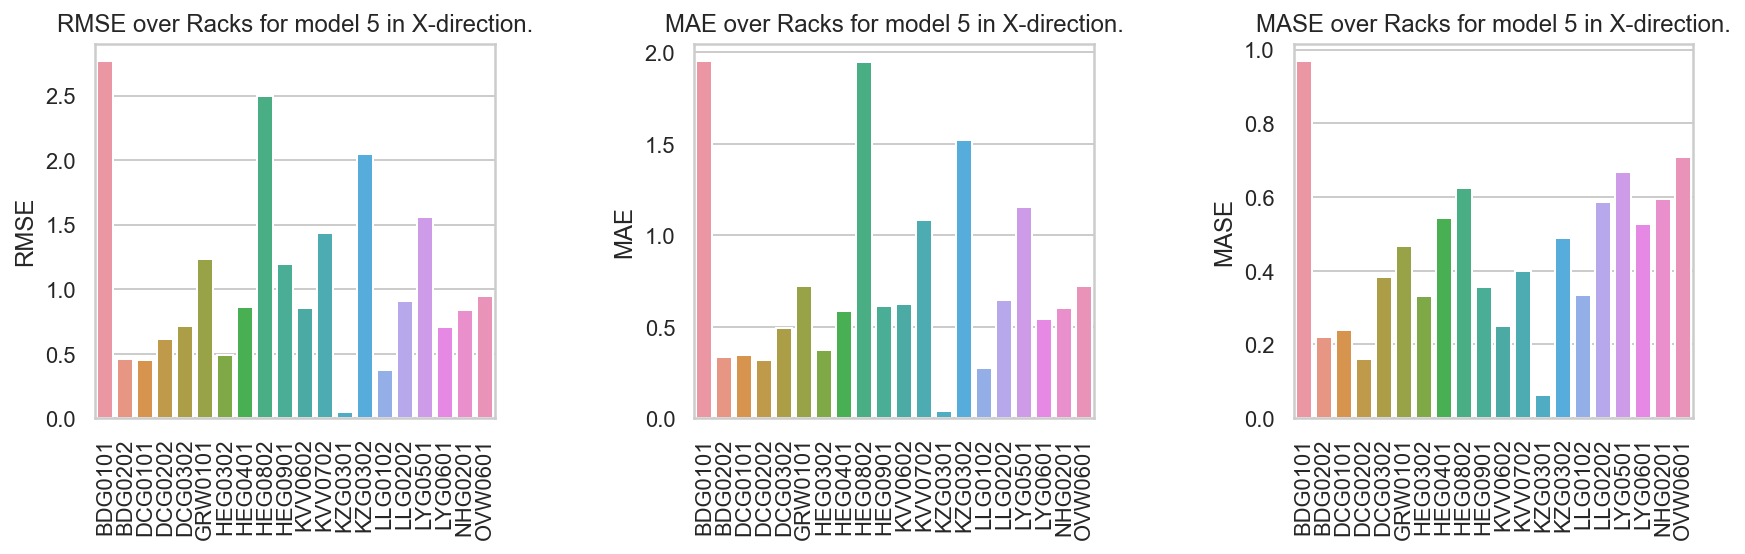

In [74]:
plot_metrics(results_tcmt_cpt_sat_x, '5', 'X')

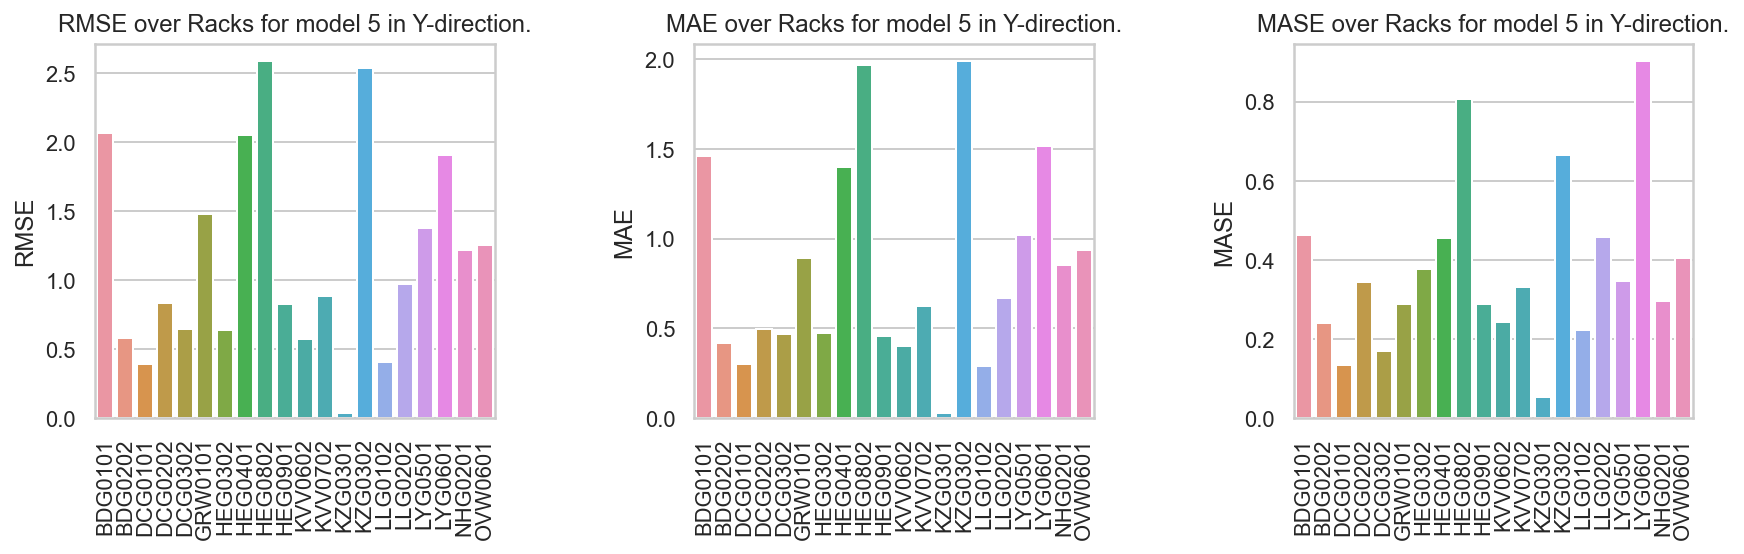

In [75]:
plot_metrics(results_tcmt_cpt_sat_y, '5', 'Y')

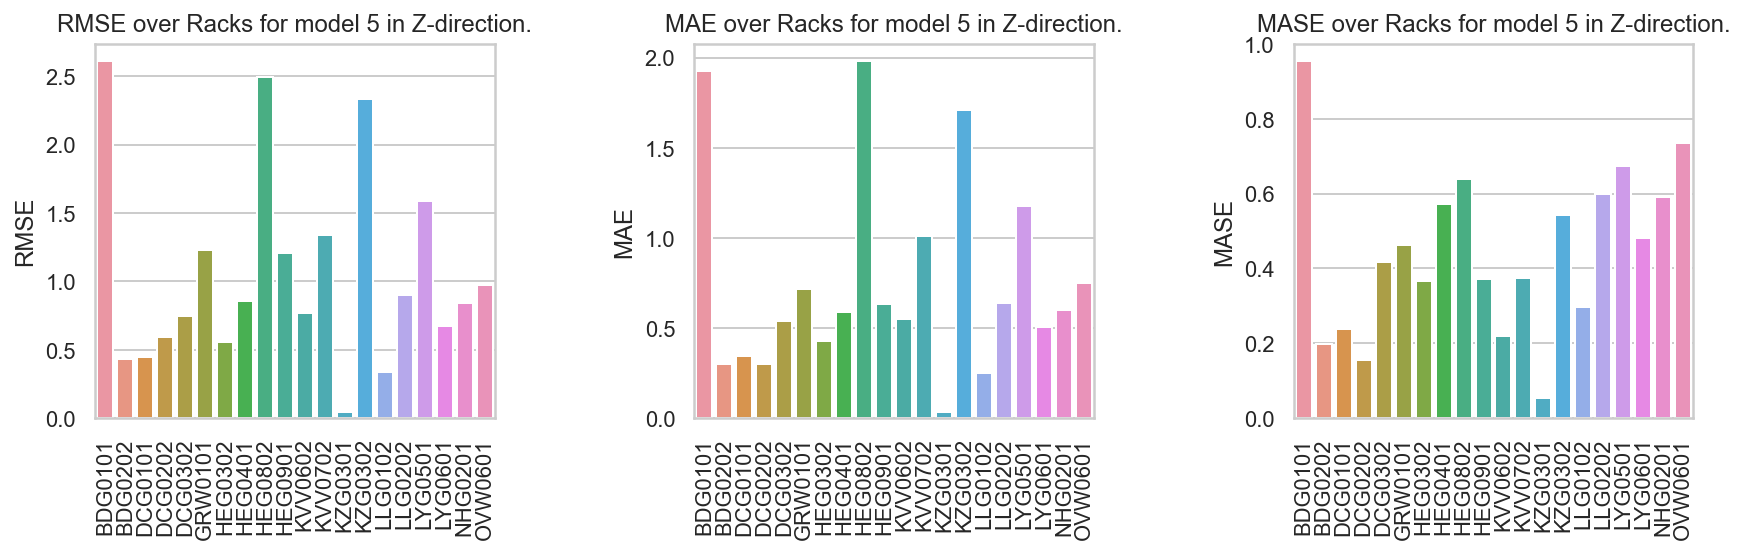

In [76]:
plot_metrics(results_tcmt_cpt_sat_z, '5', 'Z')

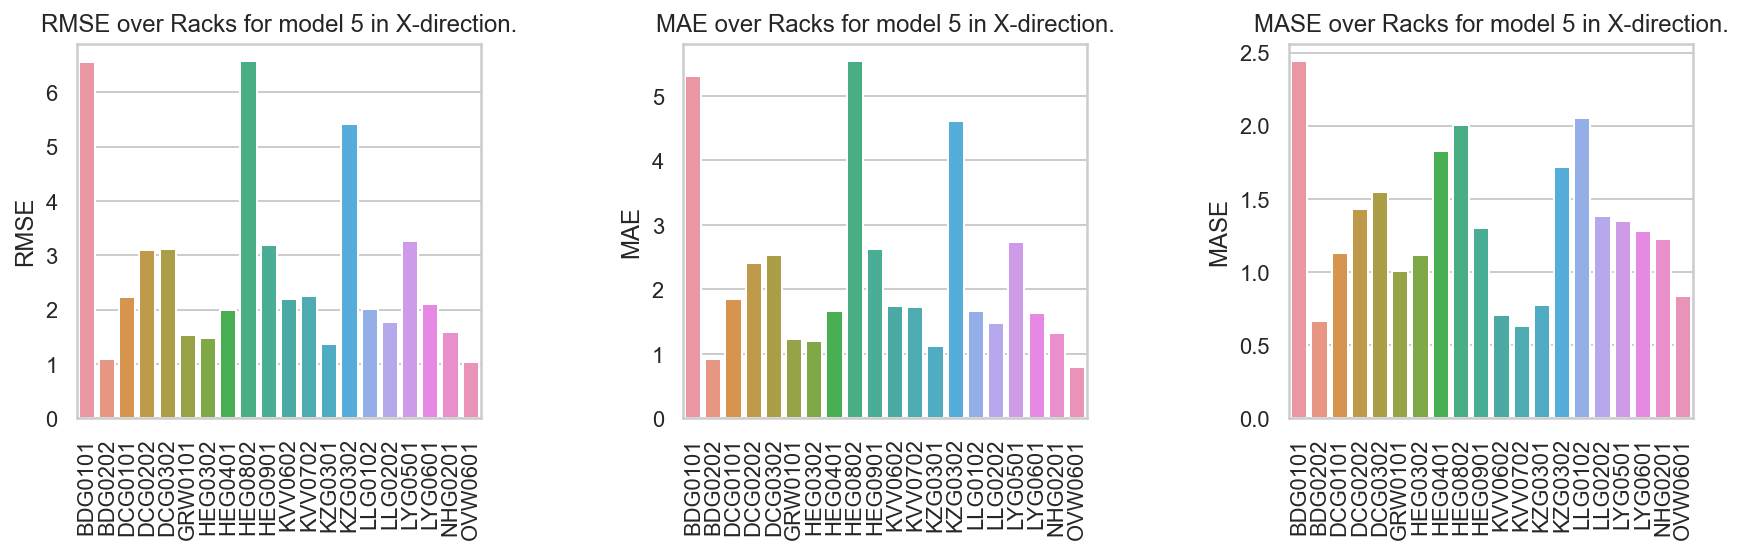

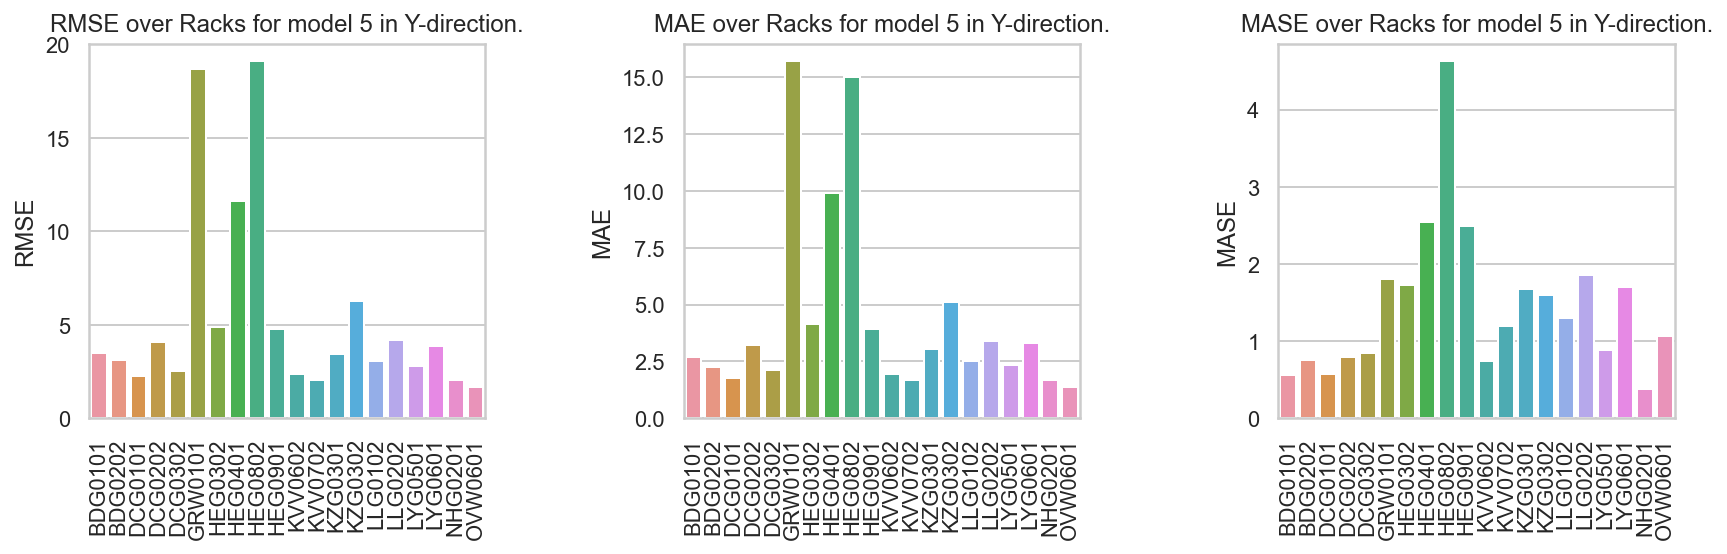

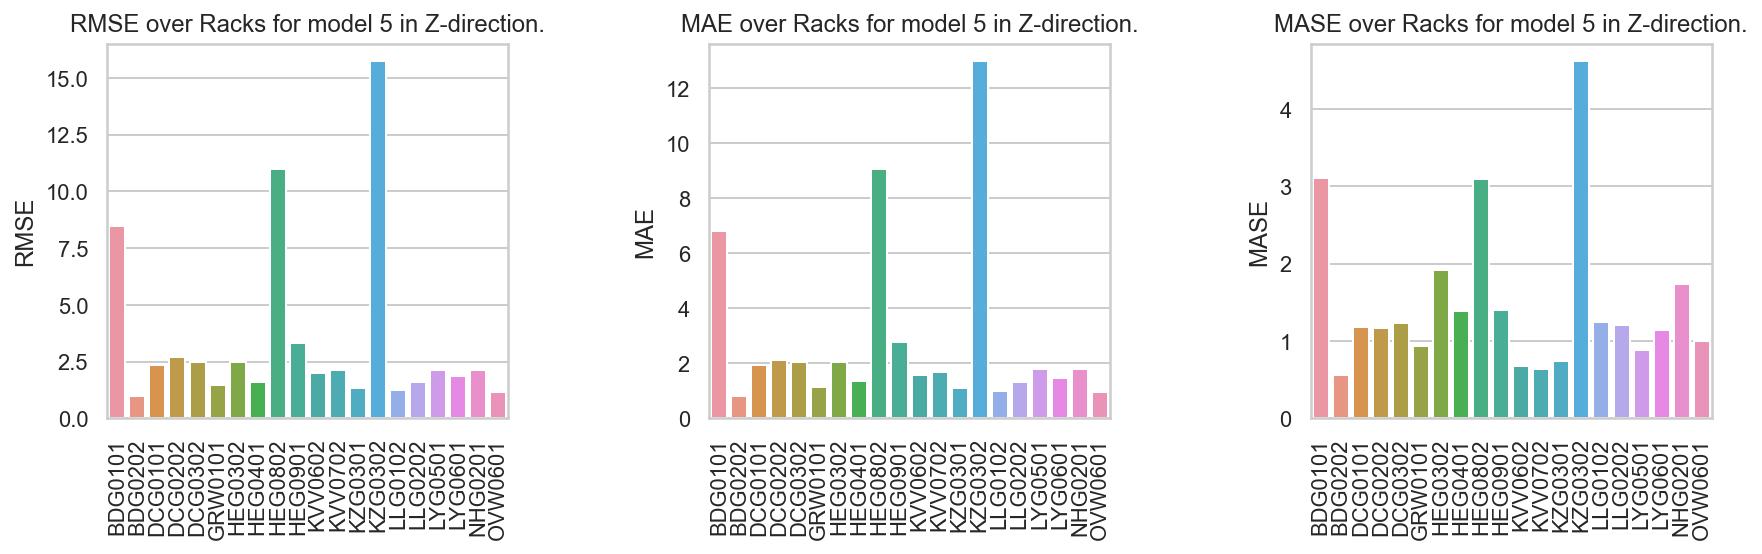

(None, None, None)

In [72]:
plot_metrics(results_tcmt_cpt_sat_x_test, '5', 'X'), plot_metrics(results_tcmt_cpt_sat_y_test, '5', 'Y'), plot_metrics(results_tcmt_cpt_sat_z_test, '5', 'Z')

## Incremental Fusion

#### TCMT + SAT <- CPT

In [33]:
models_inc_tcmt_sat_cpt_x = [load_models('INC_TCMT_SAT_CPT', 'X')]
models_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
models_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:35<00:00, 16.75s/it]


In [20]:
results_inc_tcmt_sat_cpt_x = evaluate('X', models_inc_tcmt_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_y = evaluate('Y', models_inc_tcmt_sat_cpt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_z = evaluate('Z', models_inc_tcmt_sat_cpt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')

In [22]:
inc_tcmt_sat_cpt_all = np.array(results_inc_tcmt_sat_cpt_x + results_inc_tcmt_sat_cpt_y + results_inc_tcmt_sat_cpt_z).flatten()

In [34]:
results_inc_tcmt_sat_cpt_x_test = evaluate_test('X', models_inc_tcmt_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_y_test = evaluate_test('Y', models_inc_tcmt_sat_cpt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_z_test = evaluate_test('Z', models_inc_tcmt_sat_cpt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')

In [32]:
print(np.mean(results_inc_tcmt_sat_cpt_x_test, axis=1), np.mean(results_inc_tcmt_sat_cpt_y_test, axis=1), np.mean(results_inc_tcmt_sat_cpt_z_test, axis=1))

[1.68635422 1.36307555 0.83236222] [2.94711593 2.33368171 0.81336842] [1.66017982 1.34493321 0.82292507]


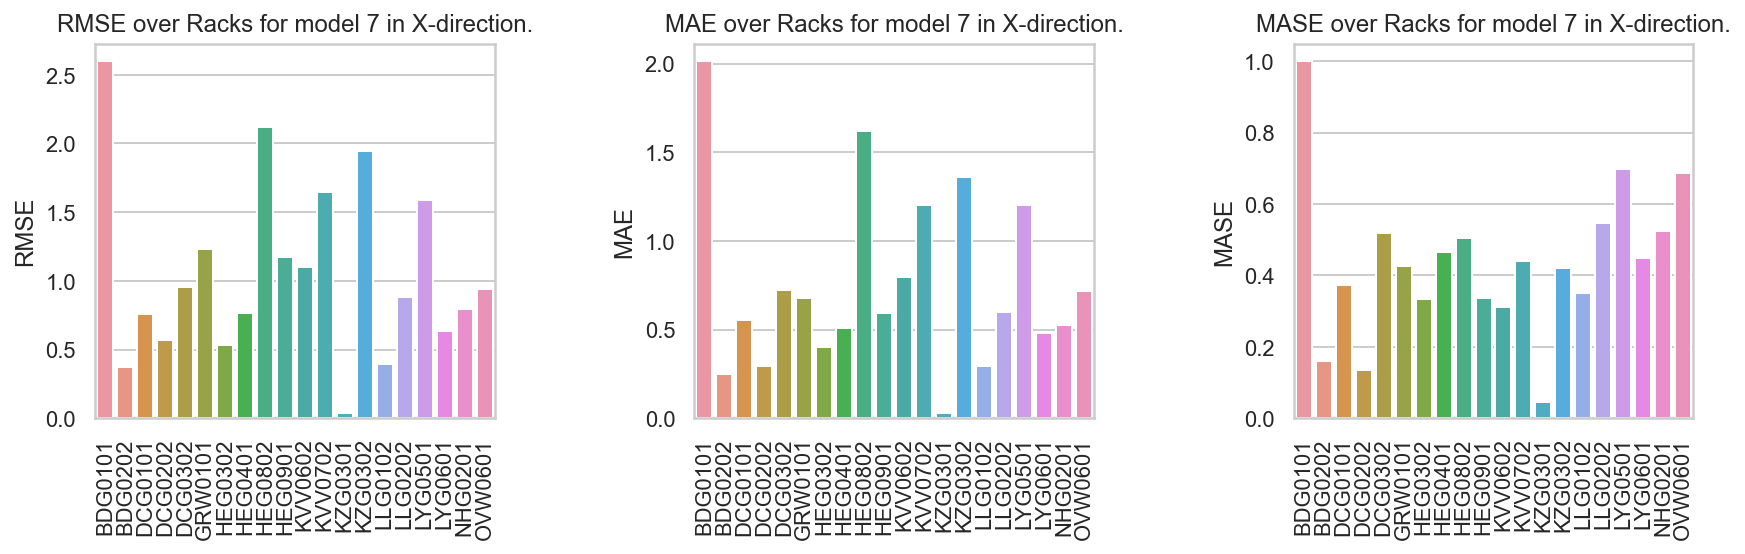

In [77]:
plot_metrics(results_inc_tcmt_sat_cpt_x, '7', 'X')

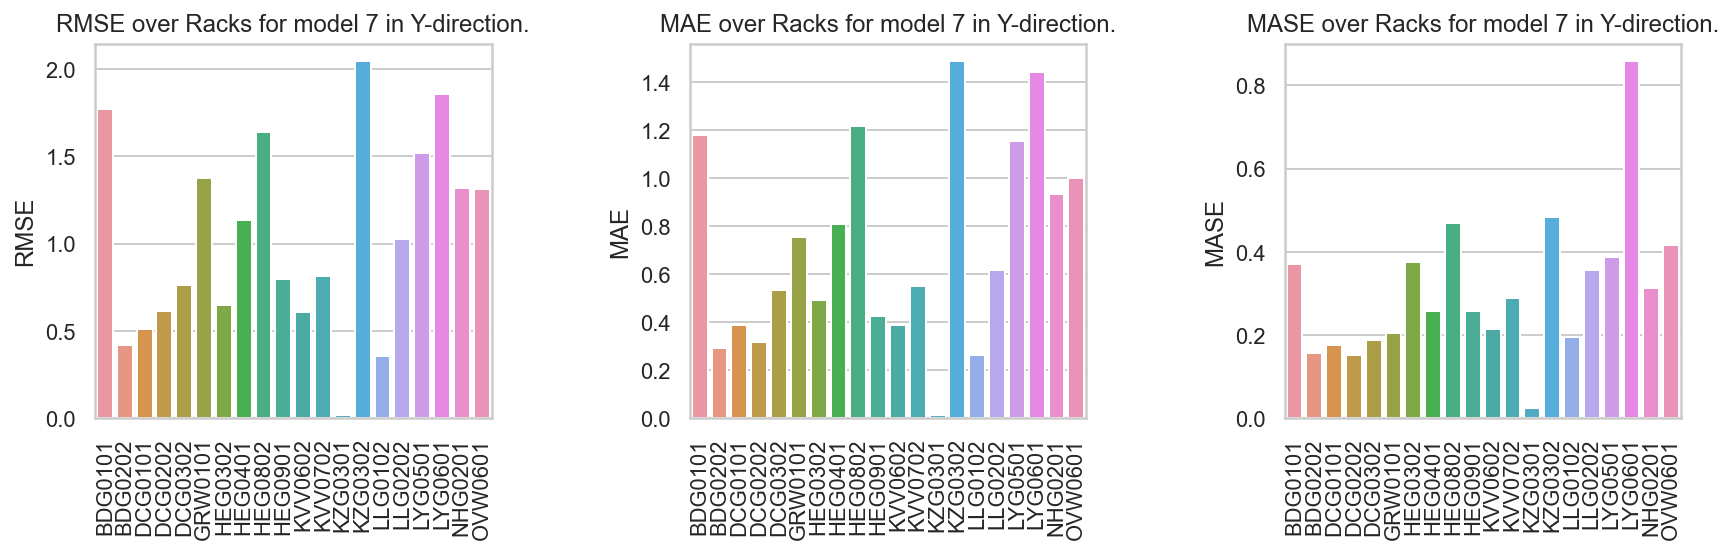

In [78]:
plot_metrics(results_inc_tcmt_sat_cpt_y, '7', 'Y')

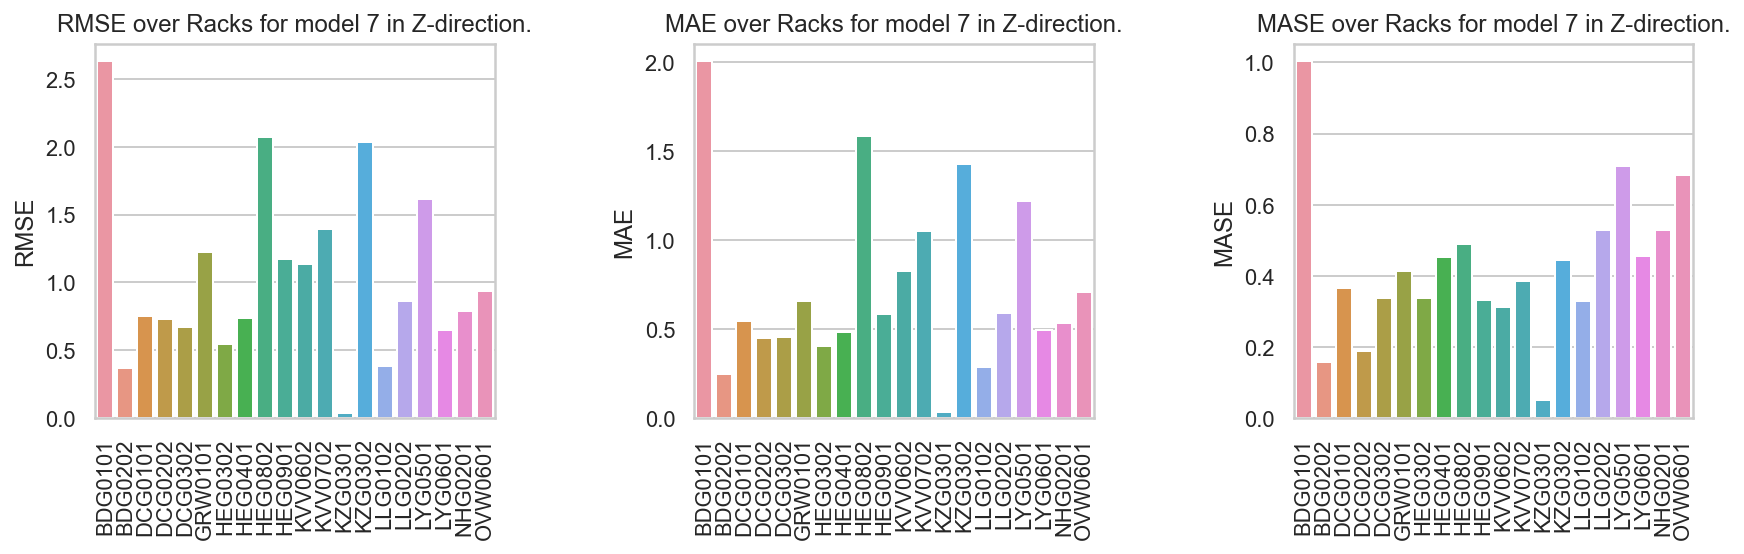

In [79]:
plot_metrics(results_inc_tcmt_sat_cpt_z, '7', 'Z')

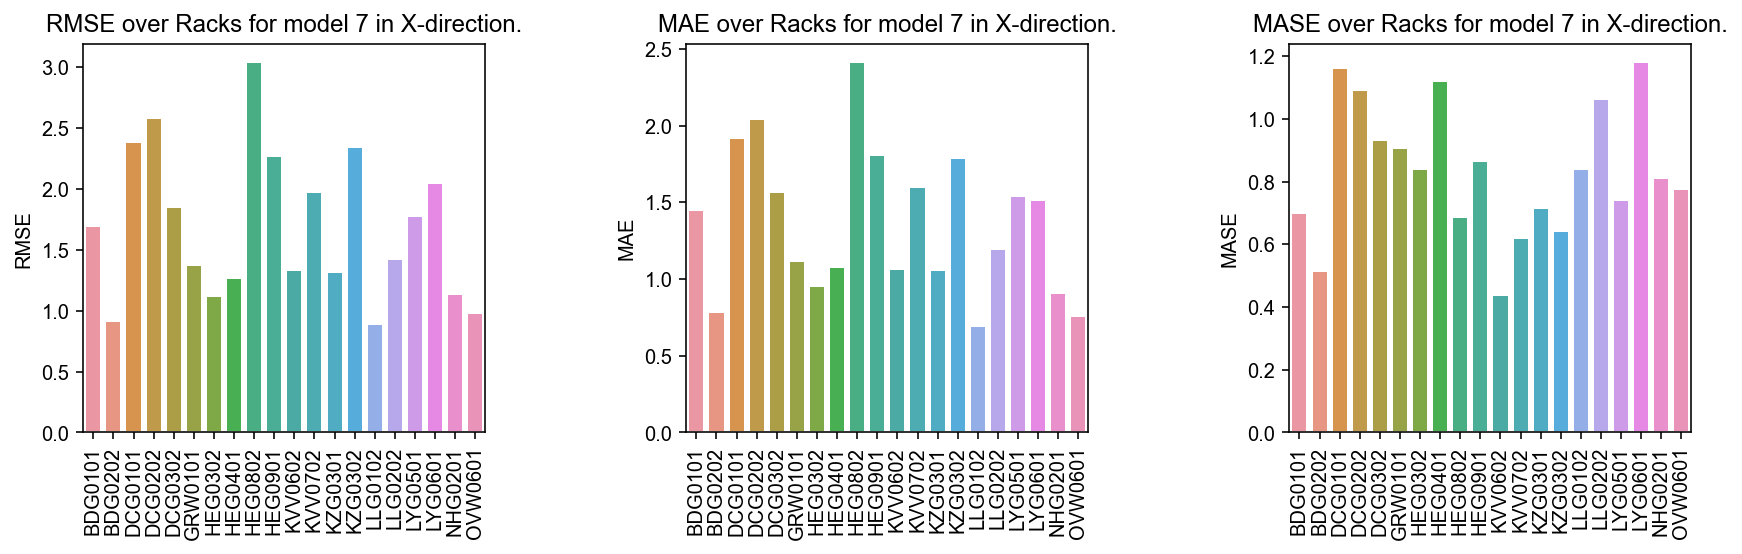

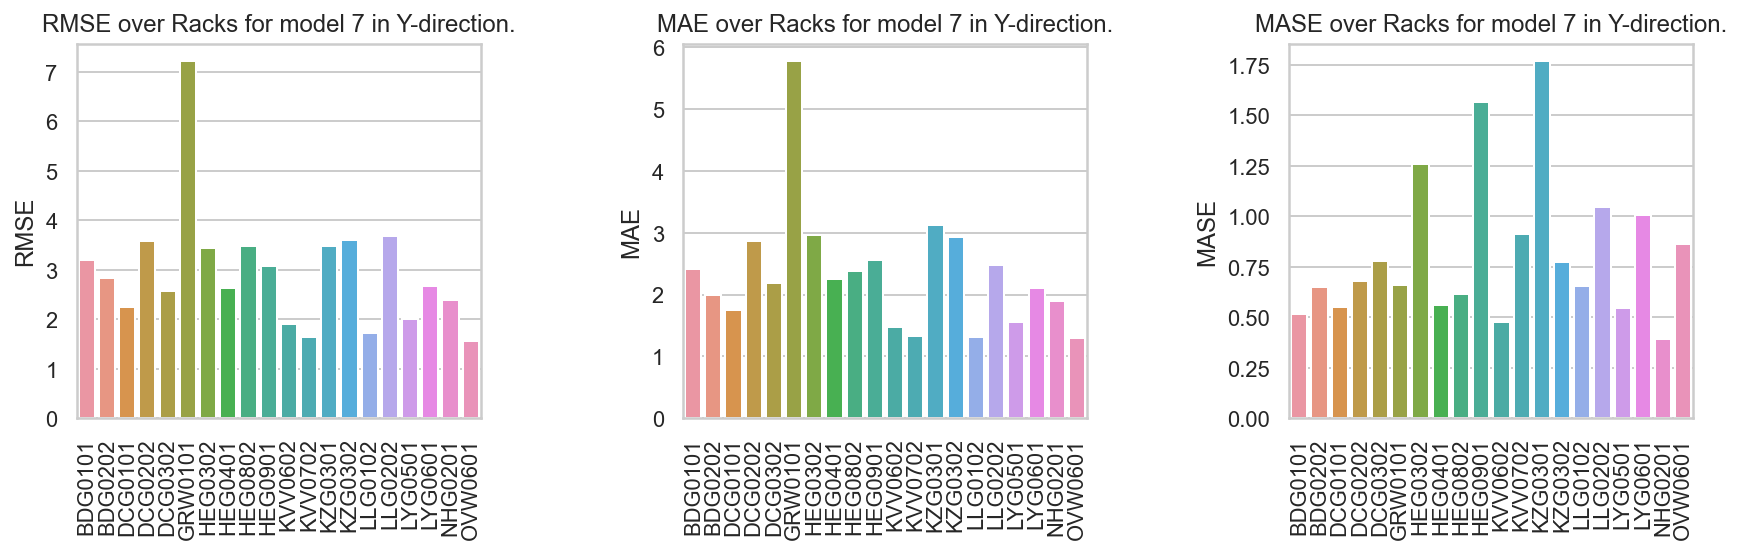

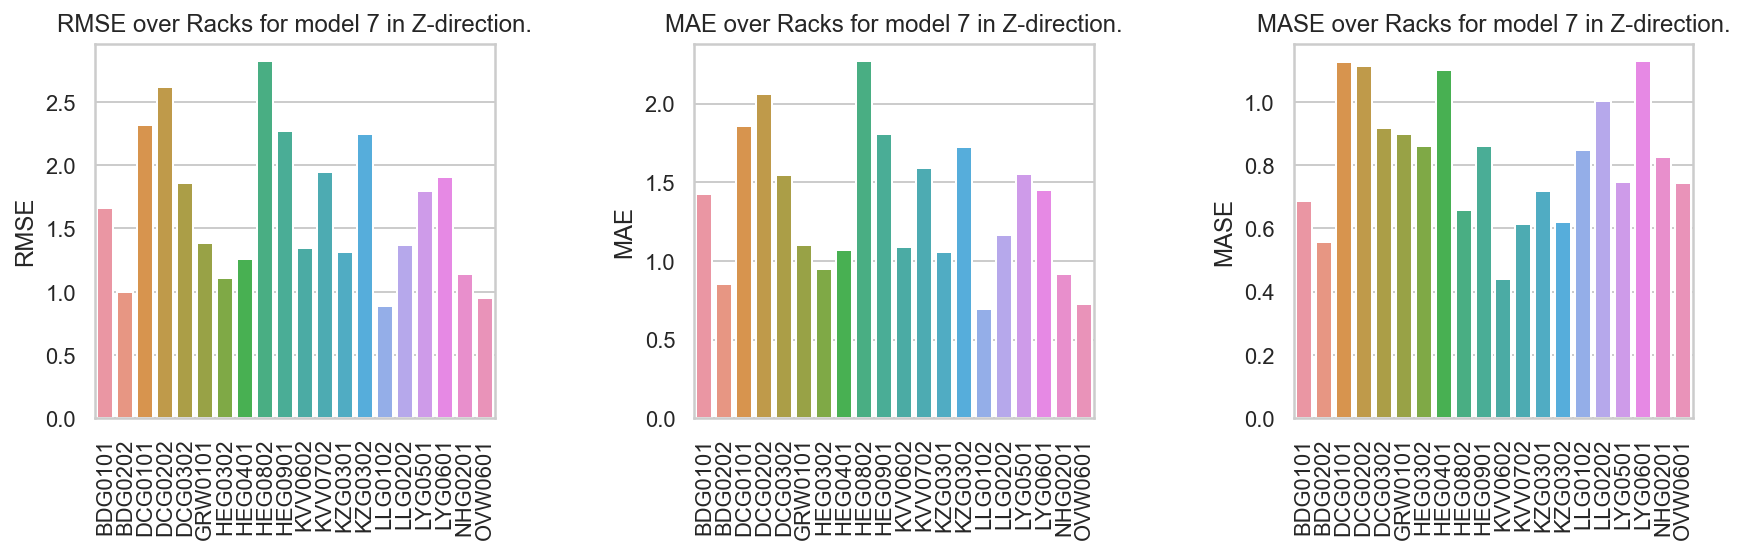

(None, None, None)

In [34]:
plot_metrics(results_inc_tcmt_sat_cpt_x_test, '7', 'X'), plot_metrics(results_inc_tcmt_sat_cpt_y_test, '7', 'Y'), plot_metrics(results_inc_tcmt_sat_cpt_z_test, '7', 'Z')

#### TCMT + CPT <- SAT

In [36]:
models_inc_tcmt_cpt_sat_x = [load_models('INC_TCMT_CPT_SAT', 'X')]
models_inc_tcmt_cpt_sat_y = [load_models('INC_TCMT_CPT_SAT', 'Y')]
models_inc_tcmt_cpt_sat_z = [load_models('INC_TCMT_CPT_SAT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.22s/it]


In [19]:
results_inc_tcmt_cpt_sat_x = evaluate('X', models_inc_tcmt_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT')
results_inc_tcmt_cpt_sat_y = evaluate('Y', models_inc_tcmt_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT')
results_inc_tcmt_cpt_sat_z = evaluate('Z', models_inc_tcmt_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT')

In [37]:
results_inc_tcmt_cpt_sat_x_test = evaluate_test('X', models_inc_tcmt_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT')
results_inc_tcmt_cpt_sat_y_test = evaluate_test('Y', models_inc_tcmt_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT')
results_inc_tcmt_cpt_sat_z_test = evaluate_test('Z', models_inc_tcmt_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT')

In [32]:
print(np.mean(results_inc_tcmt_cpt_sat_x_test, axis=1), np.mean(results_inc_tcmt_cpt_sat_y_test, axis=1), np.mean(results_inc_tcmt_cpt_sat_z_test, axis=1))

[1.73354858 1.39565916 0.82761993] [3.05183135 2.39945109 0.82303007] [1.73481395 1.39896773 0.8322082 ]


In [20]:
inc_tcmt_cpt_sat_all = np.array(results_inc_tcmt_cpt_sat_x + results_inc_tcmt_cpt_sat_y + results_inc_tcmt_cpt_sat_z).flatten()

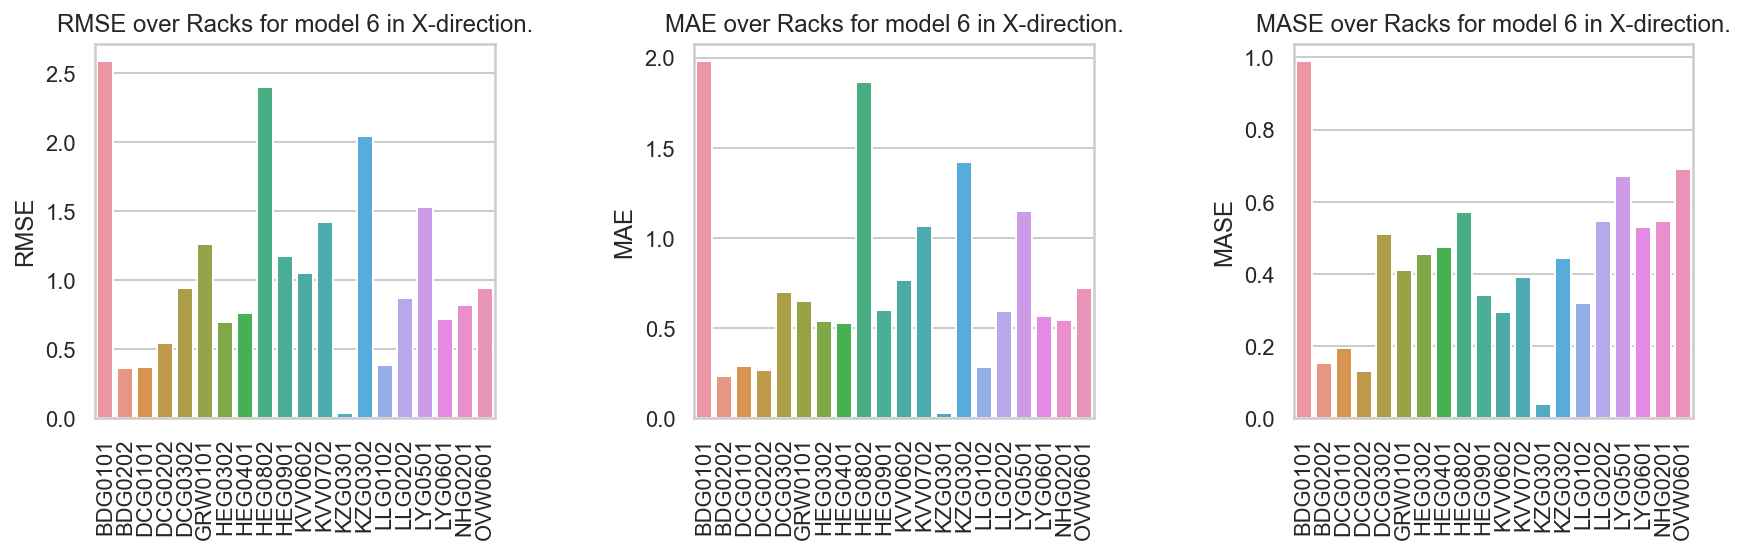

In [24]:
plot_metrics(results_inc_tcmt_cpt_sat_x, '6', 'X')

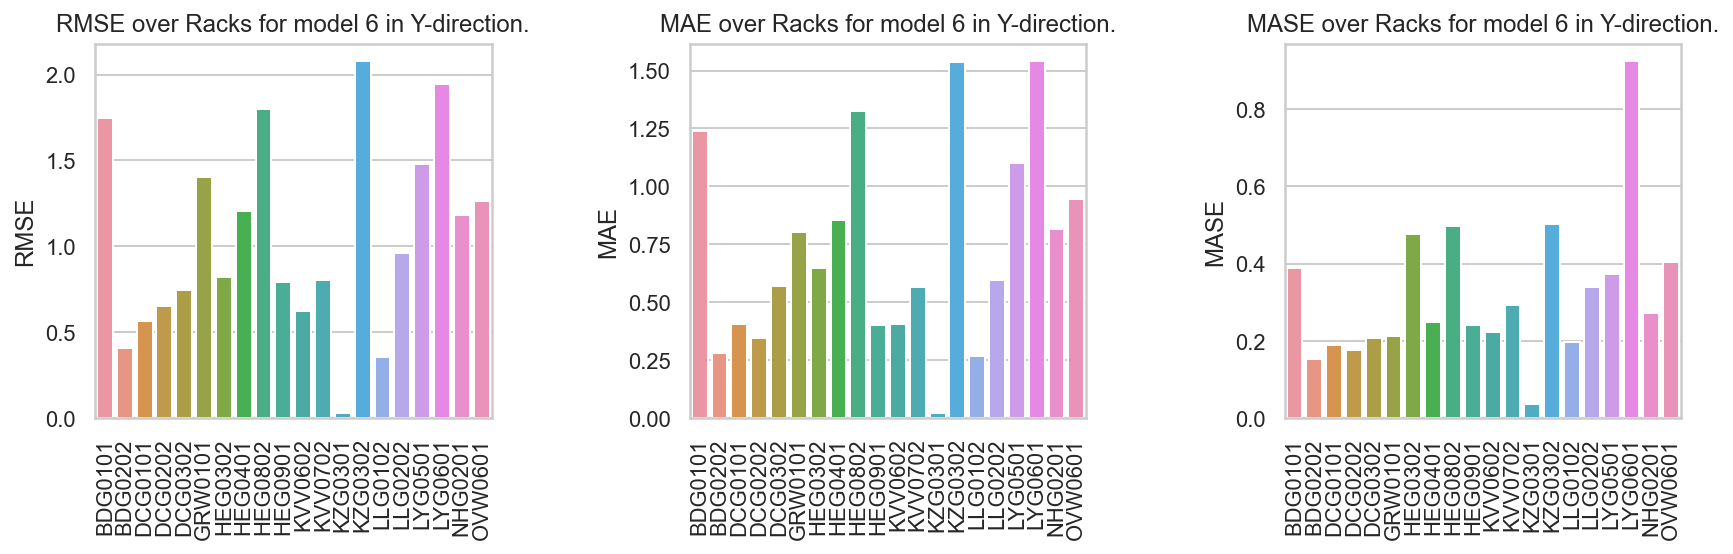

In [25]:
plot_metrics(results_inc_tcmt_cpt_sat_y, '6', 'Y')

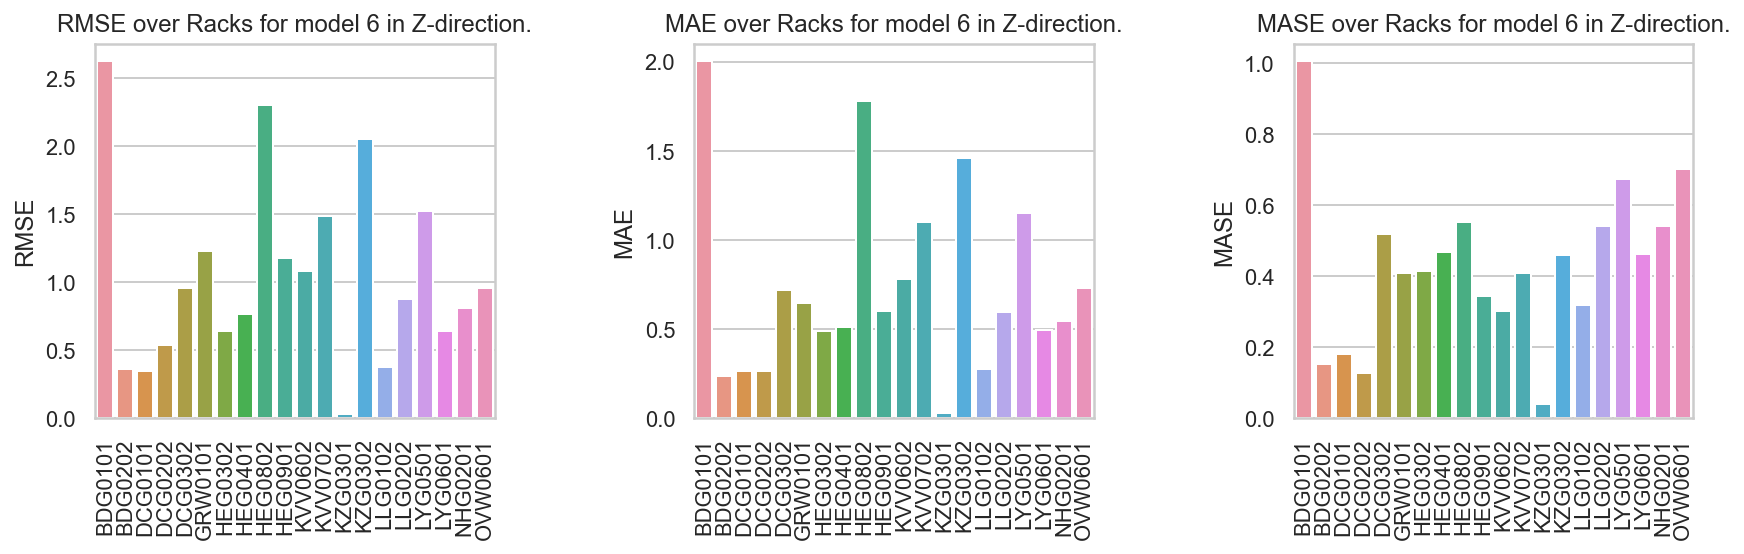

In [26]:
plot_metrics(results_inc_tcmt_cpt_sat_z, '6', 'Z')

In [ ]:
plot_metrics(results_inc_tcmt_cpt_sat_x_test, '6', 'X'), plot_metrics(results_inc_tcmt_cpt_sat_y_test, '6', 'Y'), plot_metrics(results_inc_tcmt_cpt_sat_z_test, '6', 'Z')

## Late Fusion

#### Baselines

In [20]:
results_agg_base_x = evaluate_late_fusion(direction='X', tacheometry=True, incremental=False)
results_agg_base_y = evaluate_late_fusion(direction='Y', tacheometry=True, incremental=False)
results_agg_base_z = evaluate_late_fusion(direction='Z', tacheometry=True, incremental=False)

In [36]:
results_agg_base_x_test = evaluate_late_fusion_test(direction='X', tacheometry=True, incremental=False)
results_agg_base_y_test = evaluate_late_fusion_test(direction='Y', tacheometry=True, incremental=False)
results_agg_base_z_test = evaluate_late_fusion_test(direction='Z', tacheometry=True, incremental=False)

In [34]:
print(np.mean(results_agg_base_x_test, axis=1), np.mean(results_agg_base_y_test, axis=1), np.mean(results_agg_base_z_test, axis=1))

[3.46830852 2.80915615 1.67799474] [4.9244227  3.92258579 1.32784891] [3.1286959  2.51509448 1.45543069]


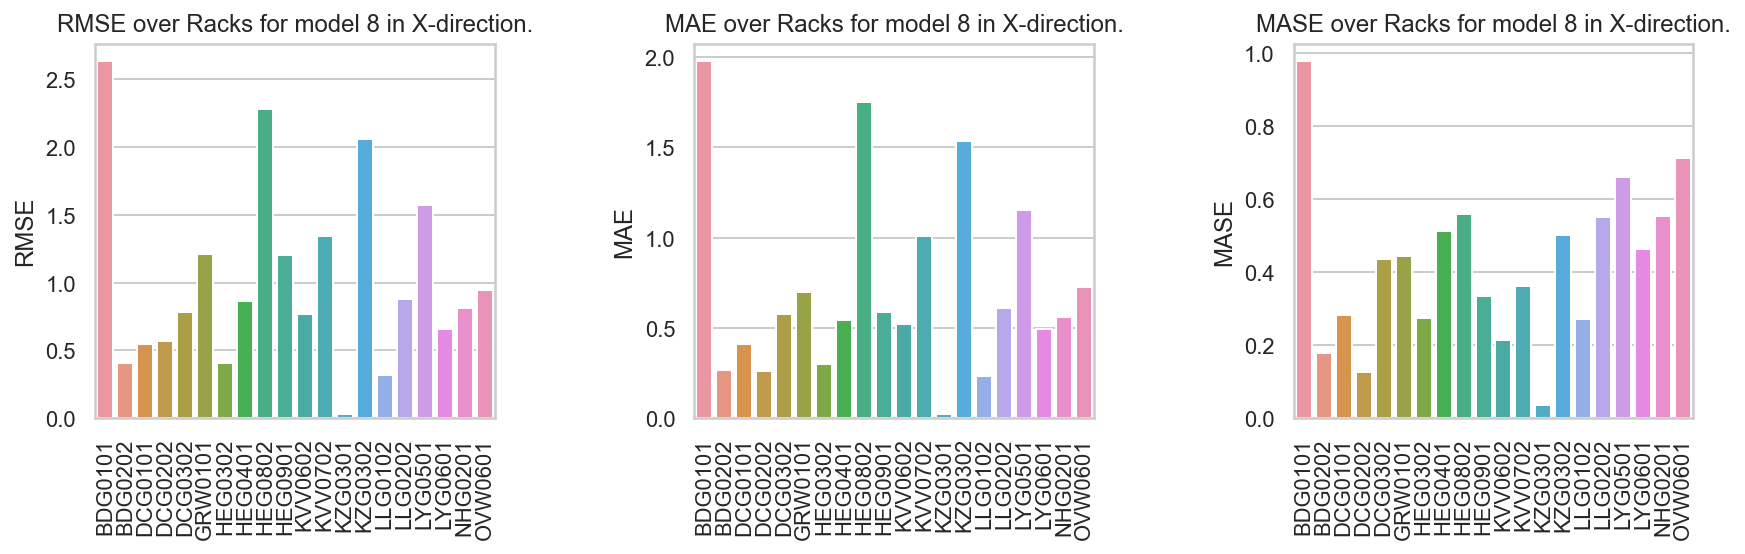

In [30]:
plot_metrics(results_agg_base_x, '8', 'X')

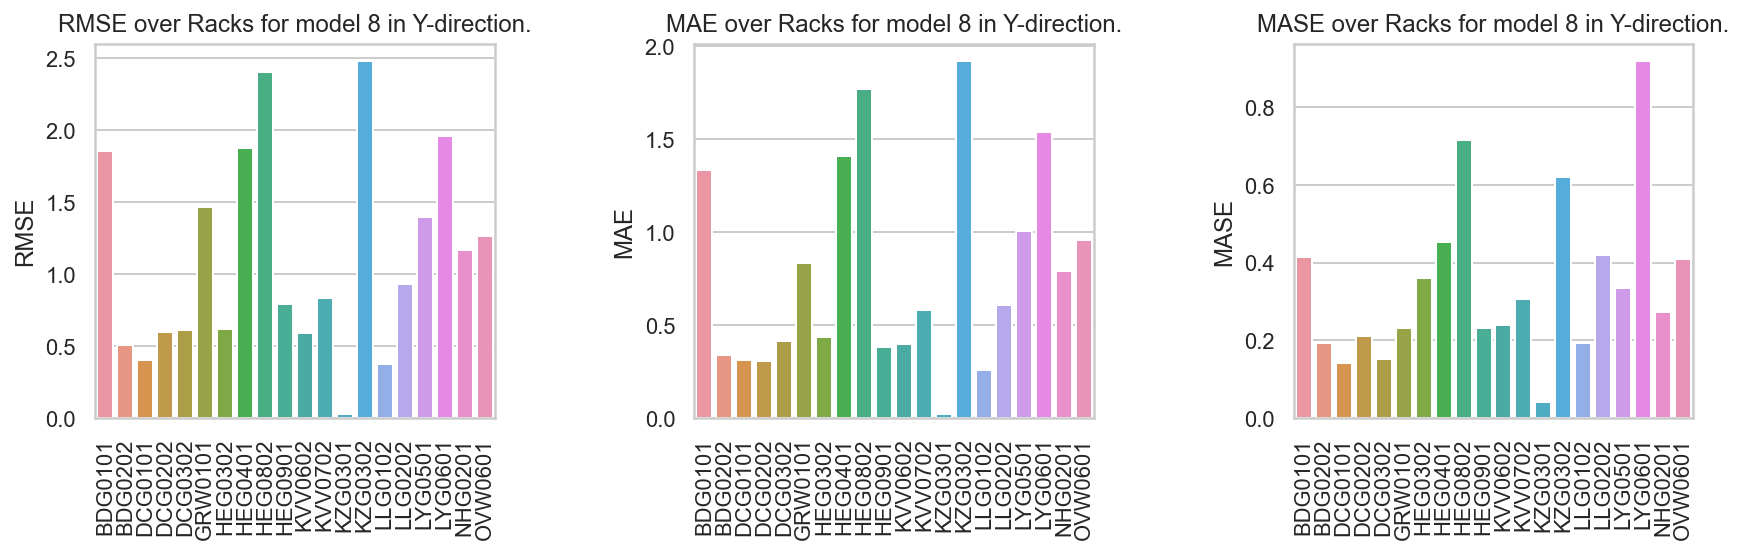

In [31]:
plot_metrics(results_agg_base_y, '8', 'Y')

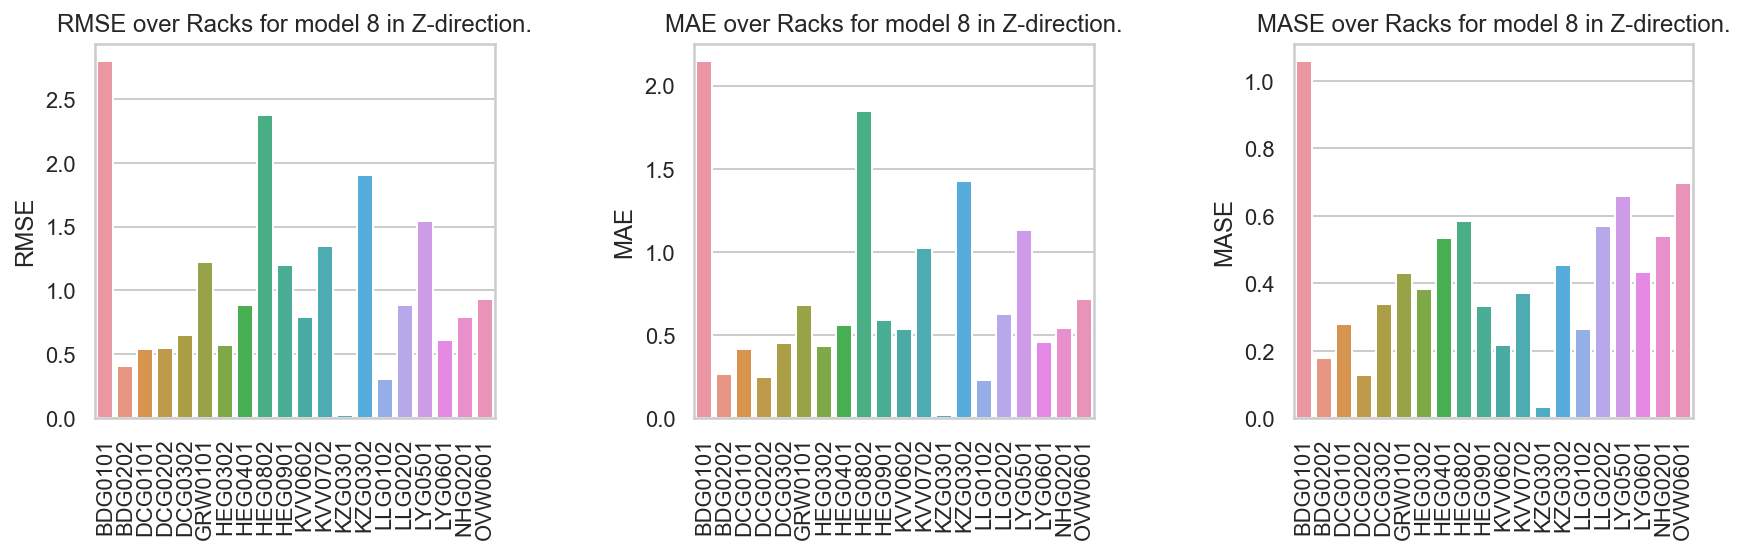

In [32]:
plot_metrics(results_agg_base_z, '8', 'Z')

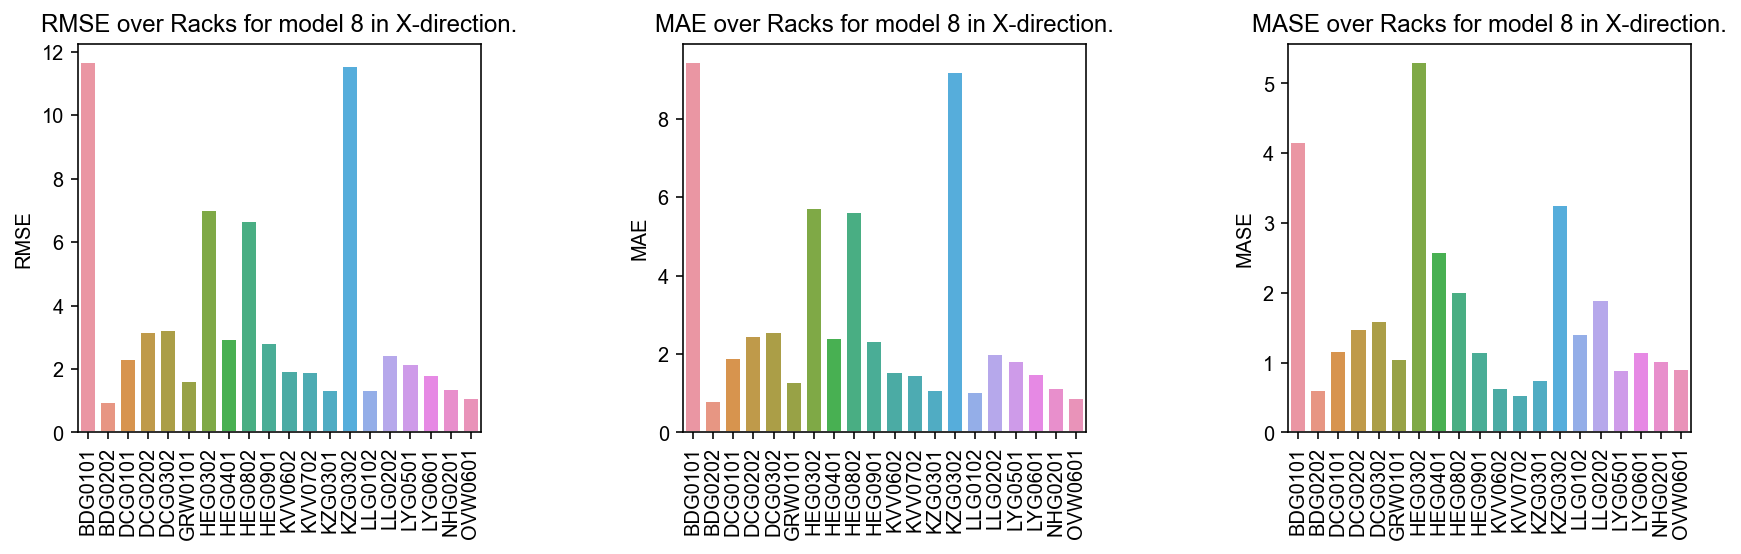

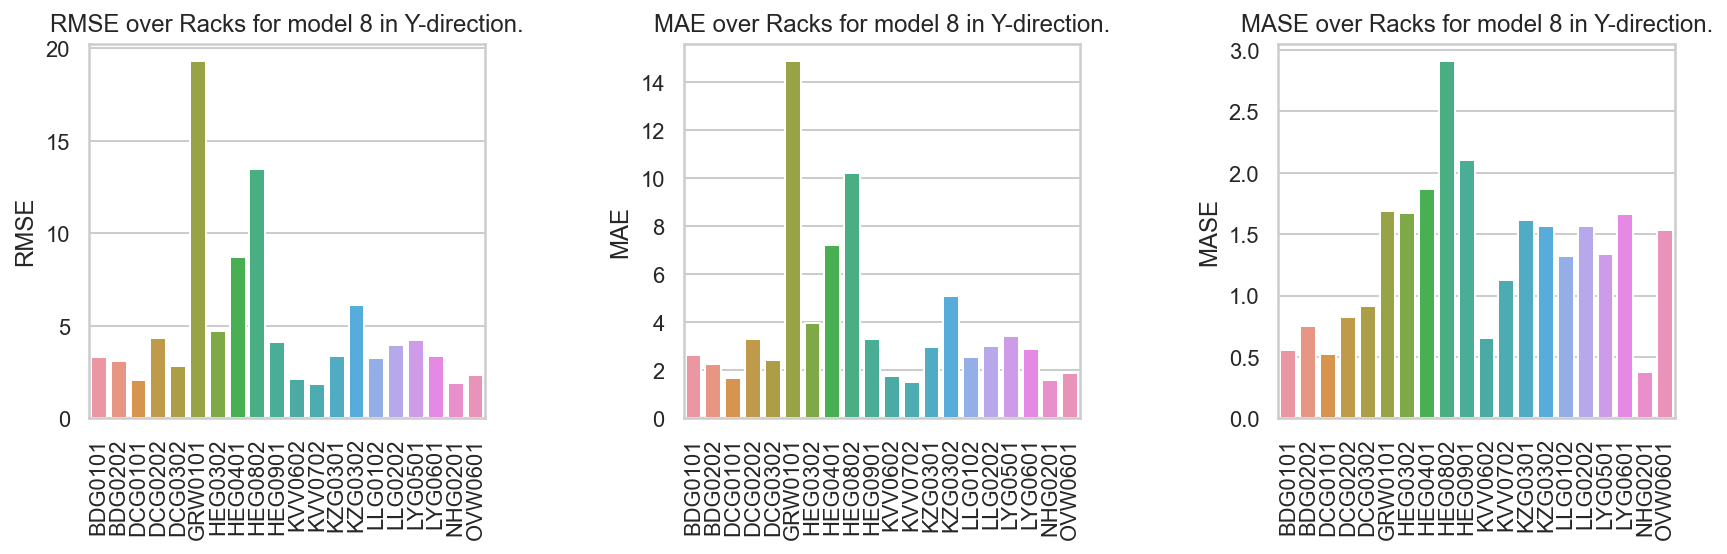

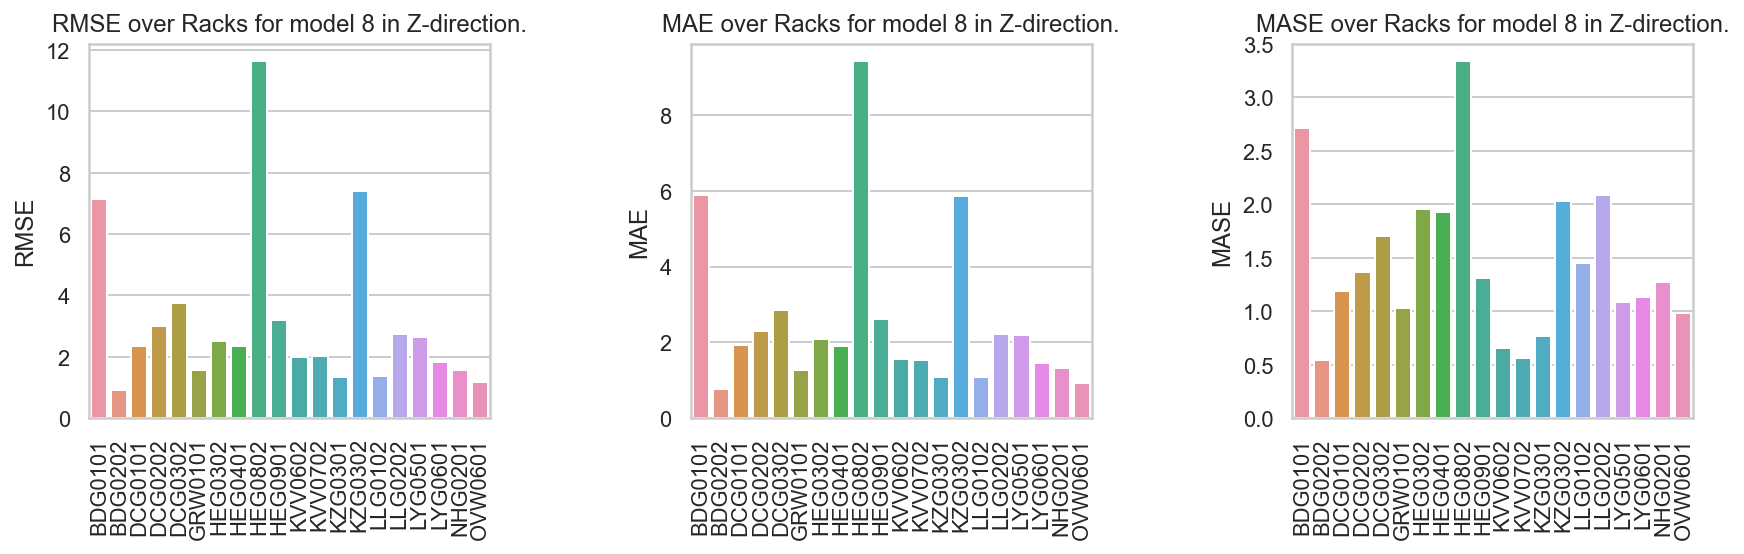

(None, None, None)

In [66]:
plot_metrics(results_agg_base_x_test, '8', 'X'), plot_metrics(results_agg_base_y_test, '8', 'Y'), plot_metrics(results_agg_base_z_test, '8', 'Z')

#### Incremental

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.69s/it]


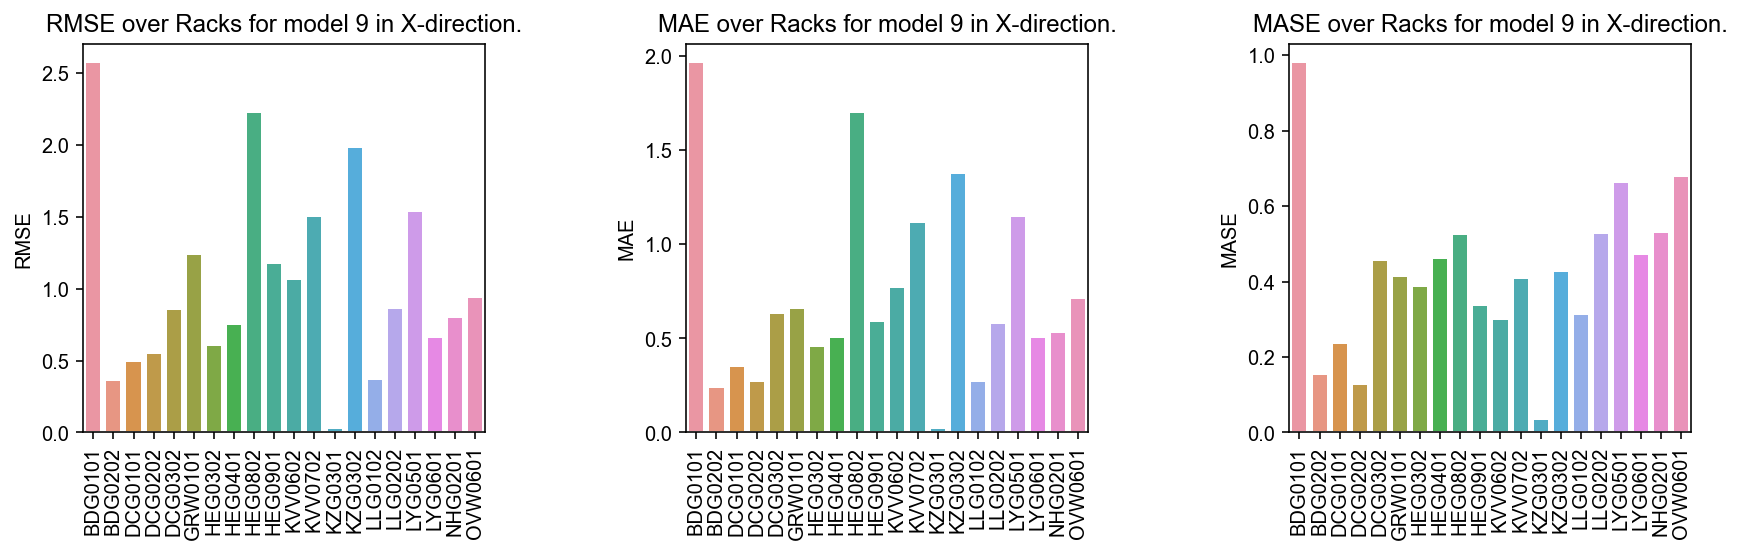

In [18]:
models_inc_tcmt_sat_cpt_x = [load_models('INC_TCMT_SAT_CPT', 'X')]
models_inc_tcmt_cpt_sat_x = [load_models('INC_TCMT_CPT_SAT', 'X')]
results_agg_inc_x = evaluate_late_fusion(direction='X', tacheometry=True, incremental=True)
plot_metrics(results_agg_inc_x, '9', 'X')

In [32]:
models_inc_tcmt_sat_cpt_x = [load_models('INC_TCMT_SAT_CPT', 'X')]
models_inc_tcmt_cpt_sat_x = [load_models('INC_TCMT_CPT_SAT', 'X')]
results_agg_inc_x_test = evaluate_late_fusion_test(direction='X', tacheometry=True, incremental=True)
print(np.mean(results_agg_inc_x_test, axis=1))
plot_metrics(results_agg_inc_x_test, '9', 'X')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:23<00:00, 10.15s/it]


[1.69284488 1.36693633 0.82222031]


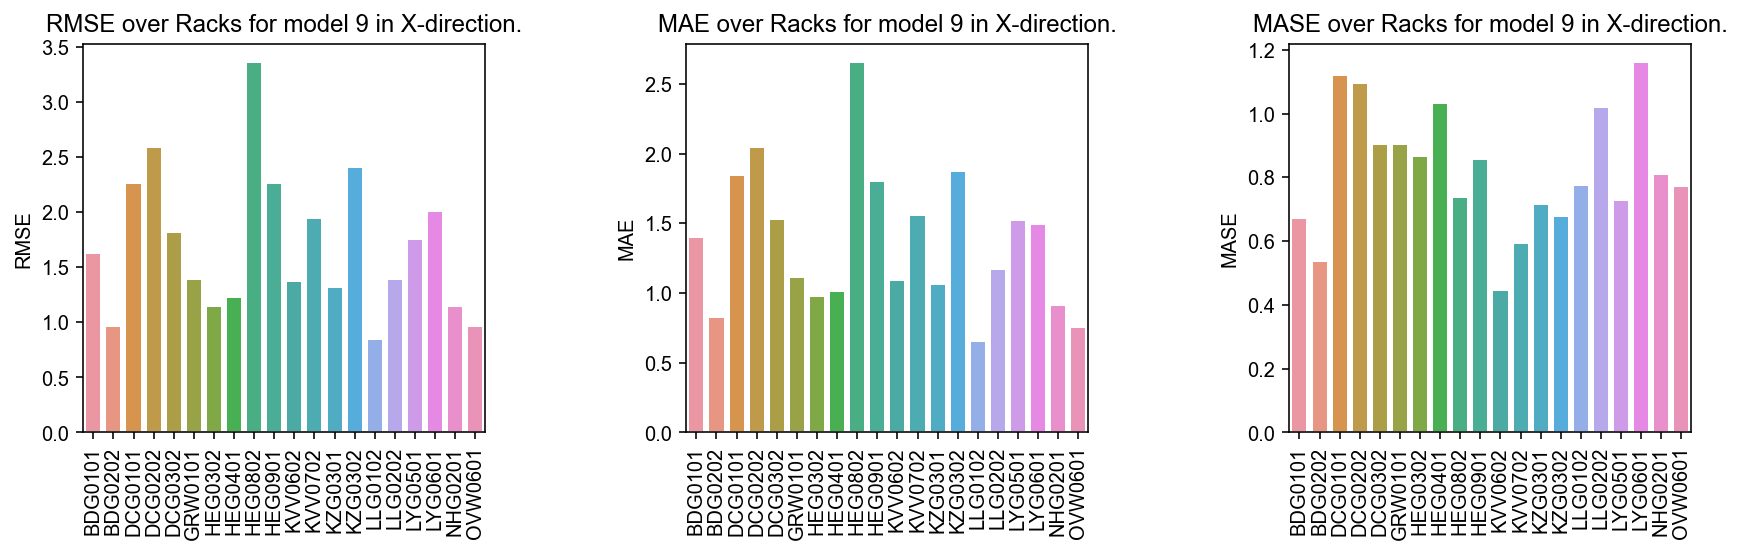

In [33]:
plot_metrics(results_agg_inc_x_test, '9', 'X')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.67s/it]


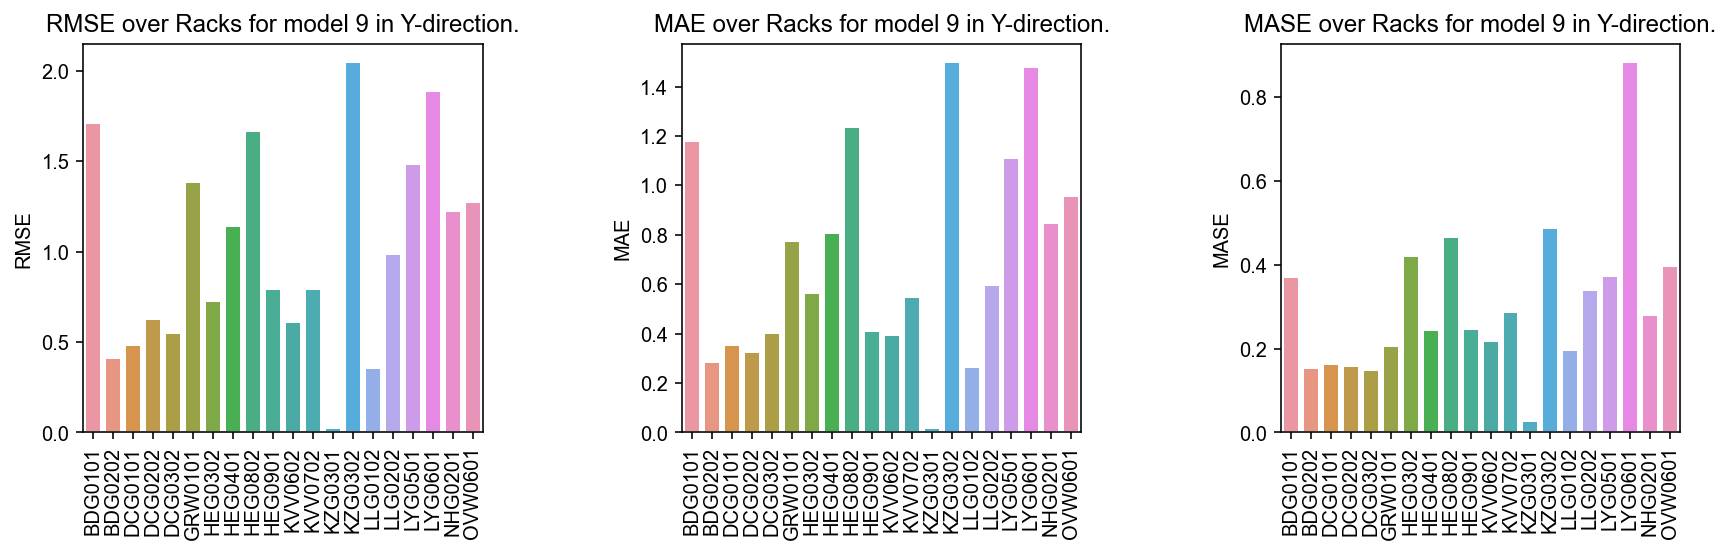

In [18]:
models_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
models_inc_tcmt_cpt_sat_y = [load_models('INC_TCMT_CPT_SAT', 'Y')]
results_agg_inc_y = evaluate_late_fusion(direction='Y', tacheometry=True, incremental=True)
plot_metrics(results_agg_inc_y, '9', 'Y')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:57<00:00, 14.86s/it]


[2.98514732 2.35550425 0.81401887]


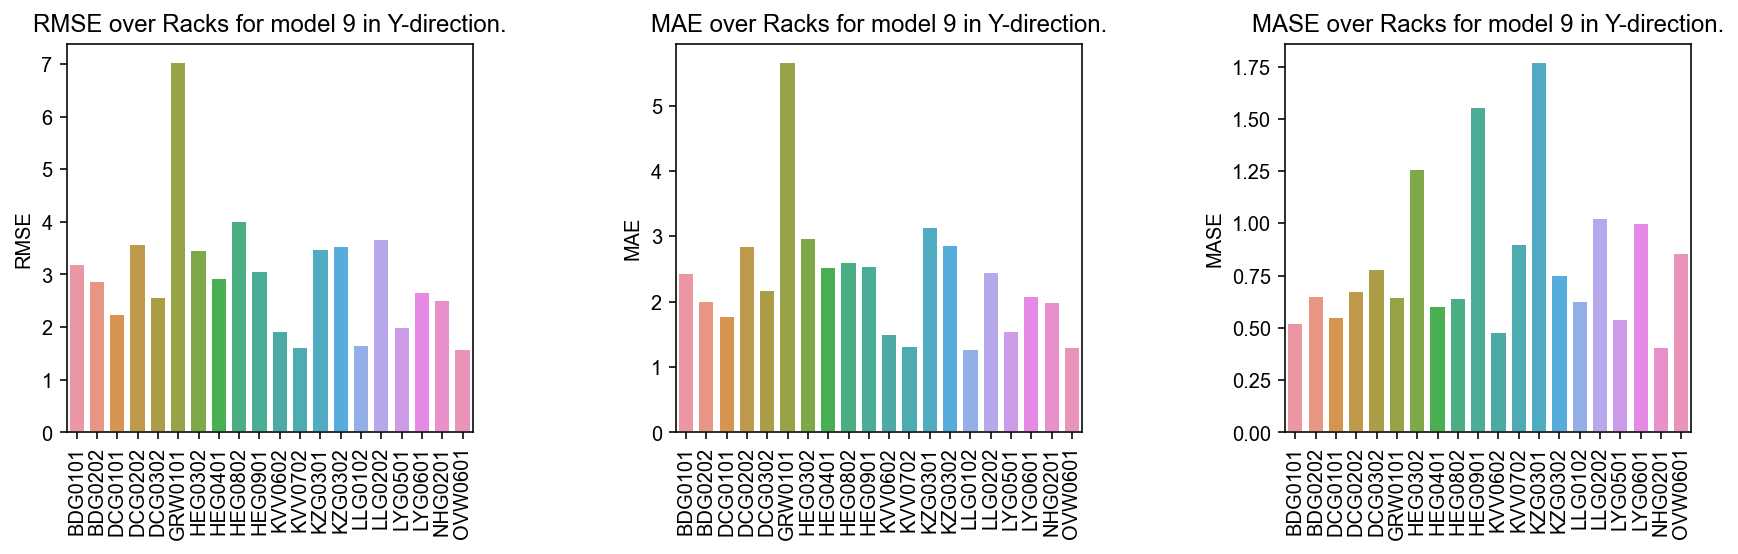

In [32]:
models_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
models_inc_tcmt_cpt_sat_y = [load_models('INC_TCMT_CPT_SAT', 'Y')]
results_agg_inc_y_test = evaluate_late_fusion_test(direction='Y', tacheometry=True, incremental=True)
print(np.mean(results_agg_inc_y_test, axis=1))
plot_metrics(results_agg_inc_y_test, '9', 'Y')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:55<00:00, 11.79s/it]


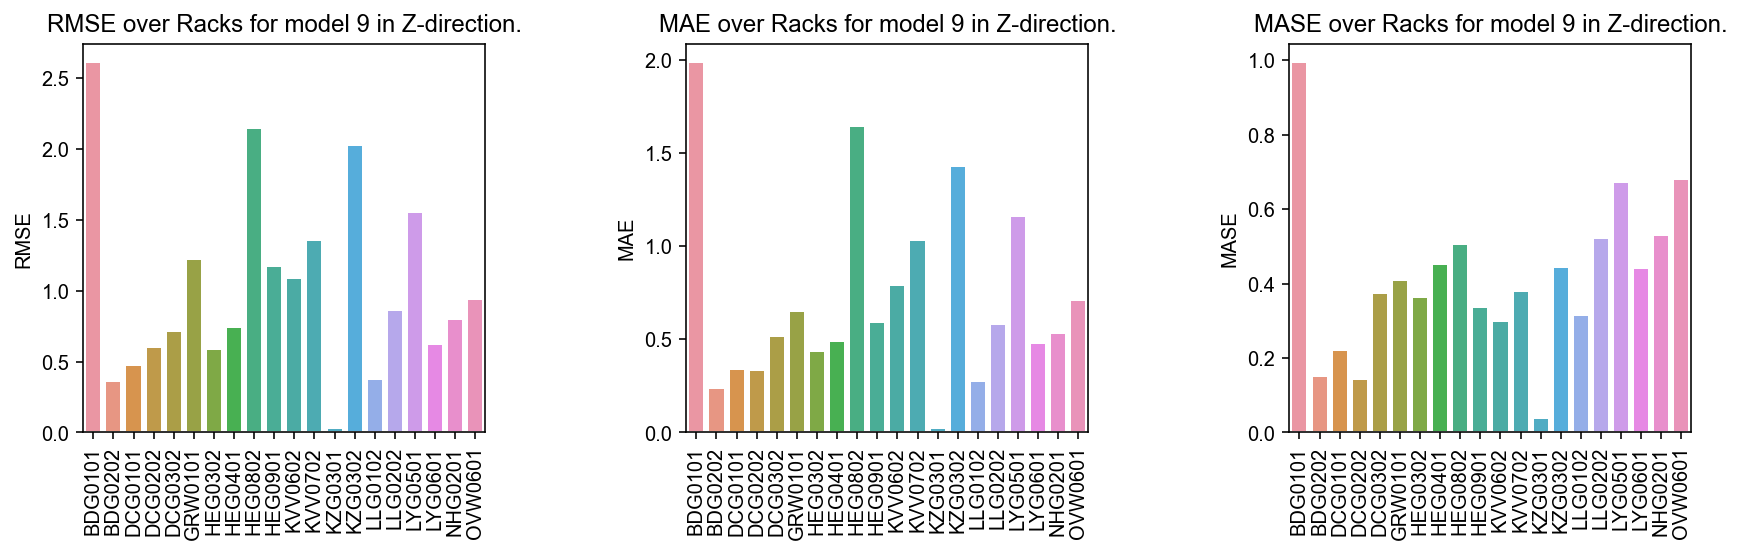

In [18]:
models_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]
models_inc_tcmt_cpt_sat_z = [load_models('INC_TCMT_CPT_SAT', 'Z')]
results_agg_inc_z = evaluate_late_fusion(direction='Z', tacheometry=True, incremental=True)
plot_metrics(results_agg_inc_z, '9', 'Z')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.46s/it]


[1.68071134 1.35955406 0.8195562 ]


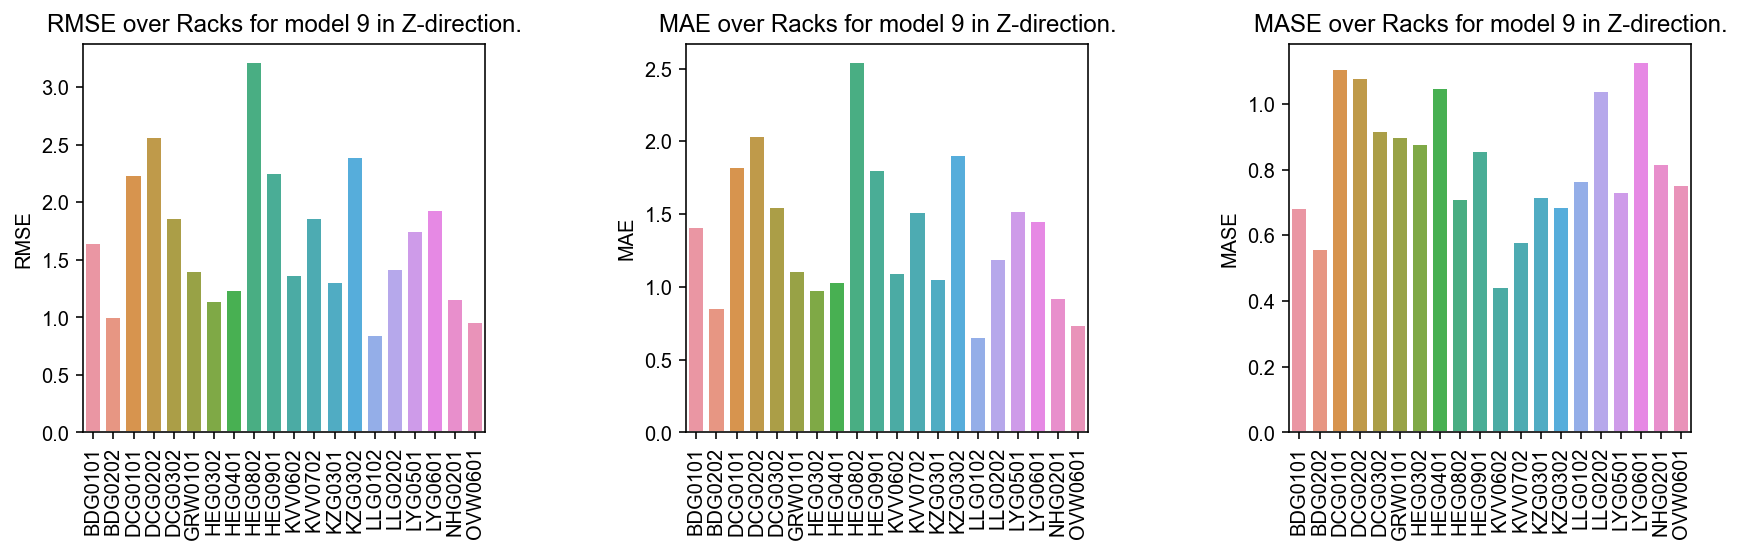

In [32]:
models_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]
models_inc_tcmt_cpt_sat_z = [load_models('INC_TCMT_CPT_SAT', 'Z')]
results_agg_inc_z_test = evaluate_late_fusion_test(direction='Z', tacheometry=True, incremental=True)
print(np.mean(results_agg_inc_z_test, axis=1))
plot_metrics(results_agg_inc_z_test, '9', 'Z')

In [ ]:
create_table_metrics(results)

# Test Objects

In [37]:
def evaluate_test_obj(direction, models, input_width, label_width, shift, incl_cpt=False, incl_sat=False, tacheometry=False, incremental=False, incremental_first='CPT'):
    
    # set df to corresponding direction
    if direction == 'X':
        df = test_objects_x
                
    if direction == 'Y':
        df = test_objects_y
        
    if direction == 'Z':
        df = test_objects_z
        
    
    val_rmse = []
    val_mae = []
    val_mase = []
    all_predictions = []
    
    for i, obj in enumerate(df.index.str[:7].unique()):
        
        X, Y = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=incl_cpt, \
                                     incl_sat=incl_sat, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

        if models == 'naive':
            naives = NaiveBaseline(X, Y)
            val_rmse.append(naives[0])
            val_mae.append(naives[1])
            val_mase.append(naives[2])
            continue
            
        else:
            
            for mod_index in [12, 14, 0]:
                model = models[mod_index]
                test_obj = train_Yx.index.str[:7].unique()[mod_index]
                org_shape = Y_x[Y_x.index.str.contains(test_obj)].shape[0]
                
                extra = 0
                if incl_sat == True:
                    extra += 3
                if incl_cpt == True:
                    extra += 17
                
                if org_shape > X.shape[2] - extra:
                    val_rmse.append(np.nan)
                    val_mae.append(np.nan)
                    val_mase.append(np.nan)
                    continue
                else:
                    X =  X[:,:,X.shape[2] - extra - org_shape:]

                if incremental == True:

                    X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=True, \
                                                   tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

                    X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=False, \
                                                   tacheometry=False, incl_sat=True)
    
                    if incremental_first == 'CPT':
                        predictions = model.predict([X, X_sat2])
                    else:
                        predictions = model.predict([X, X_cpt2])

                else:
                    predictions = model.predict(X)

                rmses = []
                maes = []
                mases = []

                for j in range(predictions.shape[2]):
                    maes.append(mean_absolute_error(Y[:,:,j], predictions[:,:,j]))
                    mases.append(mase(Y[:,:,j], predictions[:,:,j]))

                    y_act = tf.constant(Y[:,:,j])
                    y_pred = tf.constant(predictions[:,:,j])

                    rmse = tf.keras.metrics.RootMeanSquaredError()
                    rmse_value = rmse(y_act, y_pred).numpy()
                    rmses.append(rmse_value)

                val_rmse.append(np.mean(rmses))
                val_mae.append(np.mean(maes))
                val_mase.append(np.mean(mases))
        
    return val_rmse, val_mae, val_mase

In [36]:
def evaluate_late_fusion_test_obj(direction, tacheometry=False, incremental=False):

    # set df to corresponding direction
    if direction == 'X':
        df = test_objects_x
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_x[0]
                models2 = models_sat_x[0]
            else:
                models1 = models_inc_cpt_sat_x[0]
                models2 = models_inc_sat_cpt_x[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_x[0]
                models2 = models_tcmt_sat_x[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_x[0]
                models2 = models_inc_tcmt_sat_cpt_x[0]   
                
    if direction == 'Y':
        df = test_objects_y
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_y[0]
                models2 = models_sat_y[0]
            else:
                models1 = models_inc_cpt_sat_y[0]
                models2 = models_inc_sat_cpt_y[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_y[0]
                models2 = models_tcmt_sat_y[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_y[0]
                models2 = models_inc_tcmt_sat_cpt_y[0]
                
    if direction == 'Z':
        df = test_objects_z
        if tacheometry == False:
            if incremental == False:
                models1 = models_cpt_z[0]
                models2 = models_sat_z[0]
            else:
                models1 = models_inc_cpt_sat_z[0]
                models2 = models_inc_sat_cpt_z[0]
        else:
            if incremental == False:
                models1 = models_tcmt_cpt_z[0]
                models2 = models_tcmt_sat_z[0]
            else:
                models1 = models_inc_tcmt_cpt_sat_z[0]
                models2 = models_inc_tcmt_sat_cpt_z[0] 

    val_mae = []
    val_rmse = []
    val_mase = []

    for i, obj in enumerate(df.index.str[:7].unique()):

        X_cpt, Y_cpt = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

        X_sat, Y_sat = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=tacheometry, incl_sat=True)

        for mod_index in [12, 14, 0]:
            model1 = models1[mod_index]
            model2 = models2[mod_index]
    
            test_obj = train_Yx.index.str[:7].unique()[mod_index]
            print(test_obj)
            org_shape = Y_x[Y_x.index.str.contains(test_obj)].shape[0]
            if org_shape > X_sat.shape[2] - 3:
                val_rmse.append(np.nan)
                val_mae.append(np.nan)
                val_mase.append(np.nan)
                continue
                
            else:
                X_sat =  X_sat[:,:,X_sat.shape[2] - 3 - org_shape:]
                X_cpt =  X_cpt[:,:,X_cpt.shape[2] - 17 - org_shape:]

            if incremental == True:

                X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
                X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=False, incl_sat=True)

                predictions1 = model1.predict([X_cpt, X_sat2])
                predictions2 = model2.predict([X_sat, X_cpt2])
            else:
                predictions1 = model1.predict(X_cpt)
                predictions2 = model2.predict(X_sat)

            predictions = (predictions1 + predictions2) / 2

            maes = []
            rmses = []
            mases = []

            for j in range(predictions.shape[2]):
                maes.append(mean_absolute_error(Y_cpt[:,:,j], predictions[:,:,j]))
                mases.append(mase(Y_cpt[:,:,j], predictions[:,:,j]))

                y_act = tf.constant(Y_cpt[:,:,j])
                y_pred = tf.constant(predictions[:,:,j])
                rmse = tf.keras.metrics.RootMeanSquaredError()
                rmse_value = rmse(y_act, y_pred).numpy()
                rmses.append(rmse_value)

            val_mae.append(np.mean(maes))
            val_rmse.append(np.mean(rmses))
            val_mase.append(np.mean(mases))

    return val_rmse, val_mae, val_mase

In [124]:
print(Y_x.shape, train_Yx.shape)
test_objects_x = Y_x[~ Y_x.index.isin(train_Yx.index.unique())].iloc[3:,-20:-5]
test_objects_y = Y_y[~ Y_y.index.isin(train_Yy.index.unique())].iloc[3:,-20:-5]
test_objects_z = Y_z[~ Y_z.index.isin(train_Yz.index.unique())].iloc[3:,-20:-5]

(1662, 38) (1163, 28)


### IF2: InSAR <- CPT

In [ ]:
models_inc_tcmt_sat_cpt_x = [load_models('INC_TCMT_SAT_CPT', 'X')]
results_inc_tcmt_sat_cpt_x_test = evaluate_test_obj('X', models_inc_tcmt_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_x_test

In [ ]:
models_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
results_inc_tcmt_sat_cpt_y_test = evaluate_test_obj('Y', models_inc_tcmt_sat_cpt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_y_test

In [ ]:
models_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]
results_inc_tcmt_sat_cpt_z_test = evaluate_test_obj('Z', models_inc_tcmt_sat_cpt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
results_inc_tcmt_sat_cpt_z_test

### LF2: IF1 | IF2

In [ ]:
models_inc_tcmt_sat_cpt_x = [load_models('INC_TCMT_SAT_CPT', 'X')]
models_inc_tcmt_cpt_sat_x = [load_models('INC_TCMT_CPT_SAT', 'X')]
results_agg_inc_x_test = evaluate_late_fusion_test_obj(direction='X', tacheometry=True, incremental=True)
results_agg_inc_x_test

In [ ]:
models_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
models_inc_tcmt_cpt_sat_y = [load_models('INC_TCMT_CPT_SAT', 'Y')]
results_agg_inc_y_test = evaluate_late_fusion_test_obj(direction='Y', tacheometry=True, incremental=True)
results_agg_inc_y_test

In [ ]:
models_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]
models_inc_tcmt_cpt_sat_z = [load_models('INC_TCMT_CPT_SAT', 'Z')]
results_agg_inc_z_test = evaluate_late_fusion_test_obj(direction='Z', tacheometry=True, incremental=True)
results_agg_inc_z_test

### BL2: TCMT Only

In [ ]:
models_tcmt_x = [load_models('TCMT', 'X')]
results_tcmt_x_test = evaluate_test_obj('X', models_tcmt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_x_test

In [ ]:
models_tcmt_y = [load_models('TCMT', 'Y')]
results_tcmt_y_test = evaluate_test_obj('Y', models_tcmt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_y_test

In [ ]:
models_tcmt_z = [load_models('TCMT', 'Z')]
results_tcmt_z_test = evaluate_test_obj('Z', models_tcmt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False)
results_tcmt_z_test

# Results without TCMT

### CPT

In [41]:
models_cpt_x = [load_models('CPT', 'X')]
models_cpt_y = [load_models('CPT', 'Y')]
models_cpt_z = [load_models('CPT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.10s/it]


In [42]:
results_cpt_x_test = evaluate_test('X', models_cpt_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=False)
results_cpt_y_test = evaluate_test('Y', models_cpt_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=False)
results_cpt_z_test = evaluate_test('Z', models_cpt_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=False)

In [43]:
print(np.mean(results_cpt_x_test, axis=1), np.mean(results_cpt_y_test, axis=1), np.mean(results_cpt_z_test, axis=1))

[3.09094497 2.23365737 0.85920814] [4.60992143 3.39203356 0.83291844] [3.09777718 2.2381534  0.86317206]


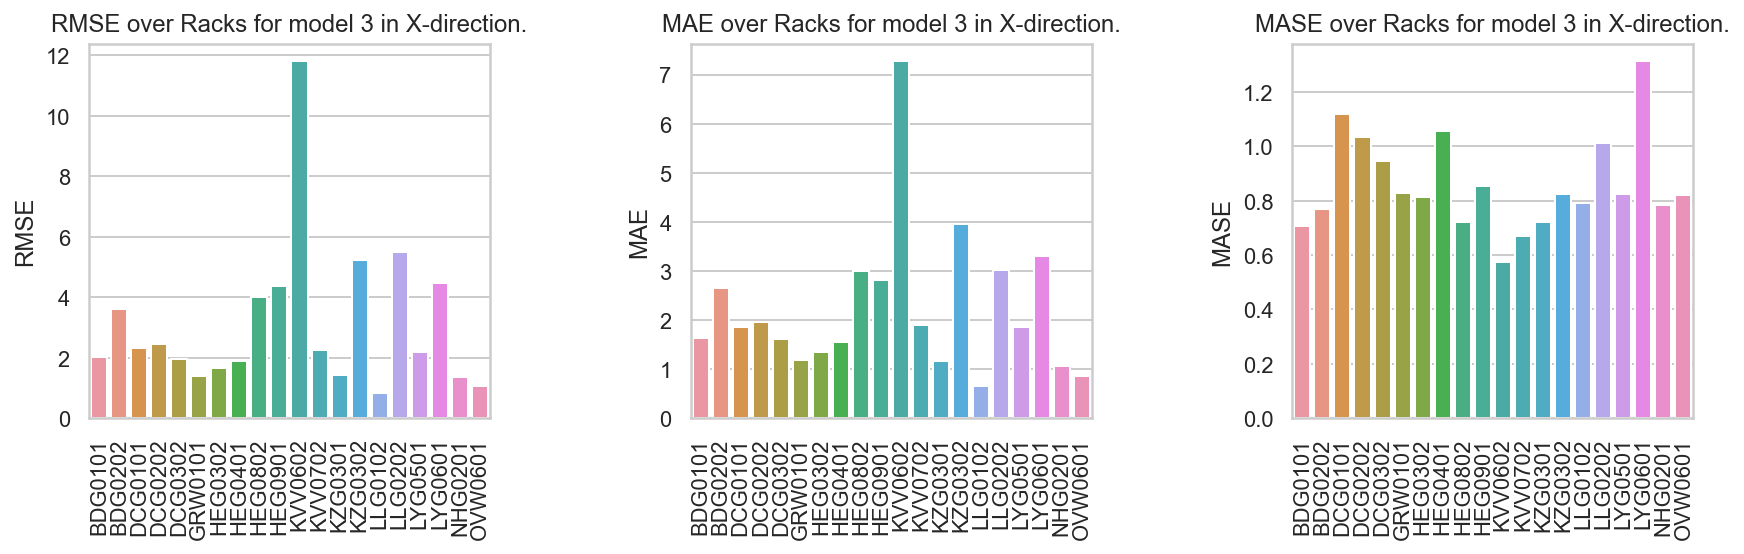

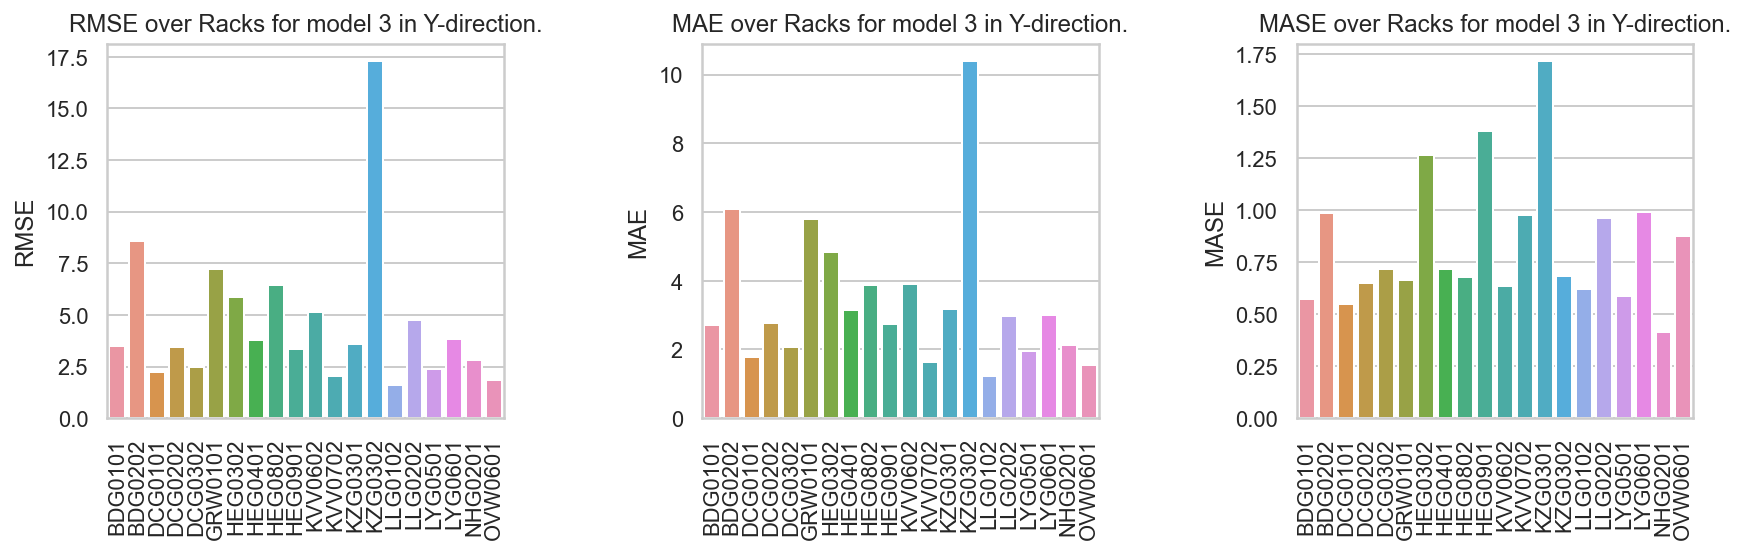

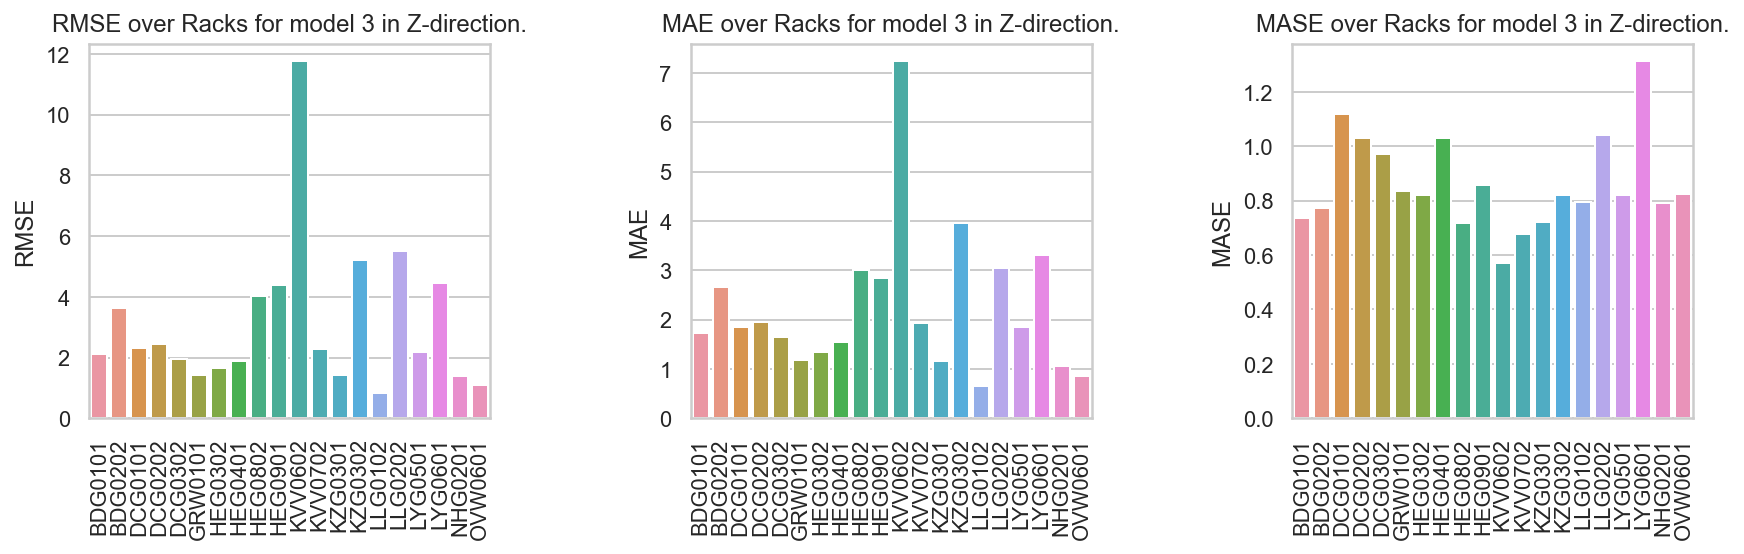

(None, None, None)

In [44]:
plot_metrics(results_cpt_x_test, '3', 'X'), plot_metrics(results_cpt_y_test, '3', 'Y'), plot_metrics(results_cpt_z_test, '3', 'Z')

### Sat <- CPT

In [ ]:
models_inc_sat_cpt_x = [load_models('INC_SAT_CPT', 'X')]
models_inc_sat_cpt_y = [load_models('INC_SAT_CPT', 'Y')]
models_inc_sat_cpt_z = [load_models('INC_SAT_CPT', 'Z')]

In [141]:
results_inc_sat_cpt_x_test = evaluate_test('X', models_inc_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=True,  incremental_first='Sat')
results_inc_sat_cpt_y_test = evaluate_test('Y', models_inc_sat_cpt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=True,  incremental_first='Sat')
results_inc_sat_cpt_z_test = evaluate_test('Z', models_inc_sat_cpt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=True,  incremental_first='Sat')

In [142]:
print(np.mean(results_inc_sat_cpt_x_test, axis=1), np.mean(results_inc_sat_cpt_y_test, axis=1), np.mean(results_inc_sat_cpt_z_test, axis=1))

[3.11120955 2.24160253 0.8608806 ] [4.70146887 3.4410481  0.83537633] [3.11608654 2.24844833 0.86320132]


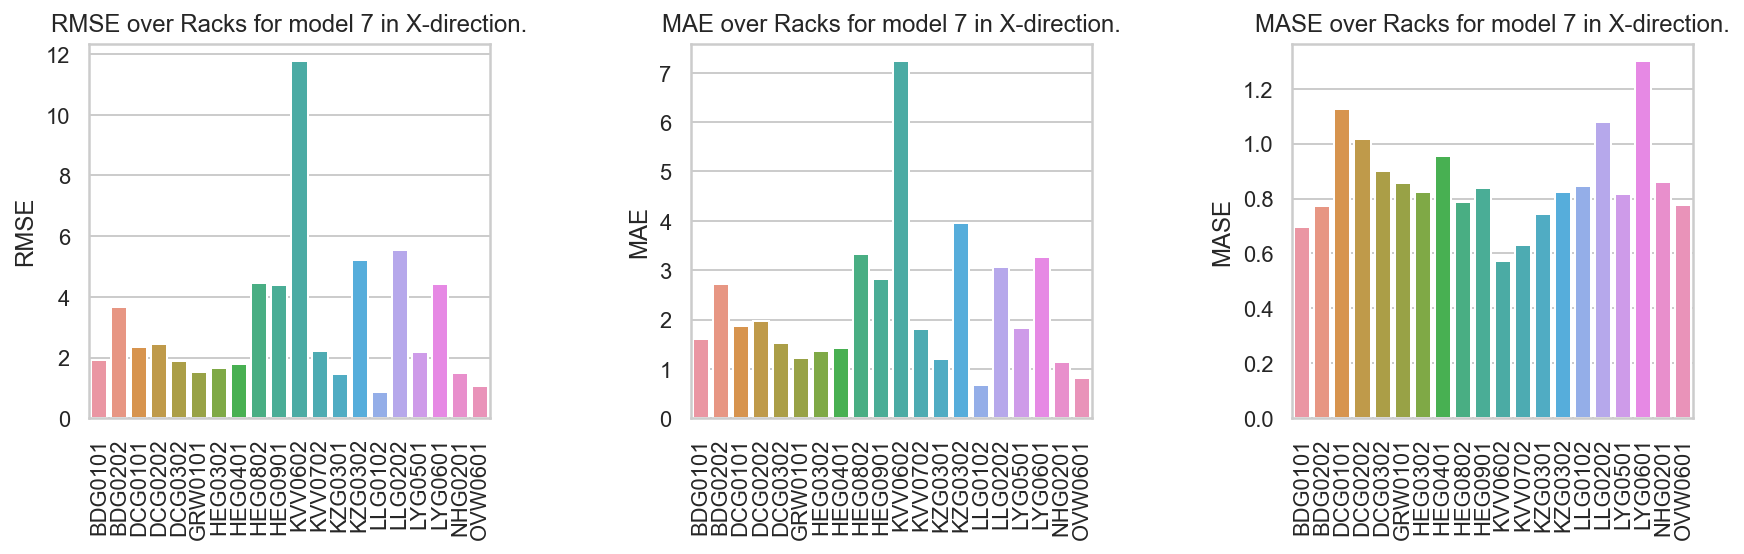

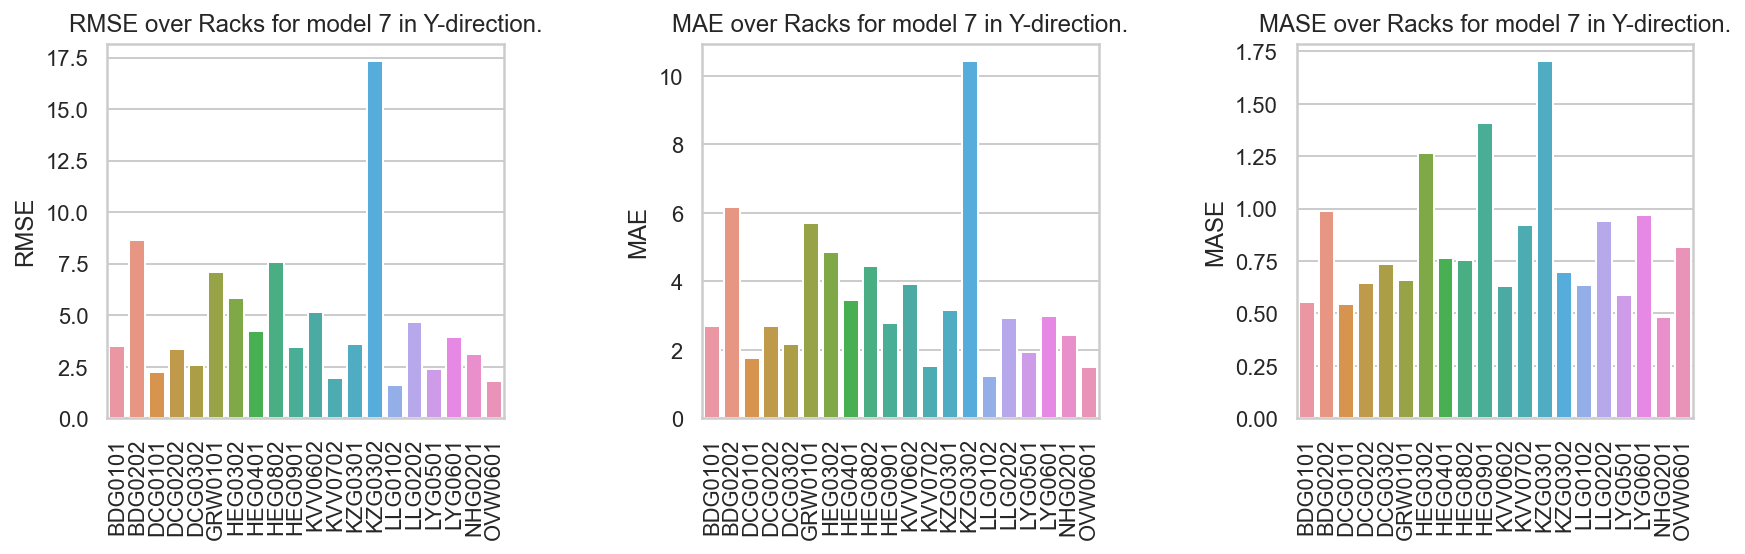

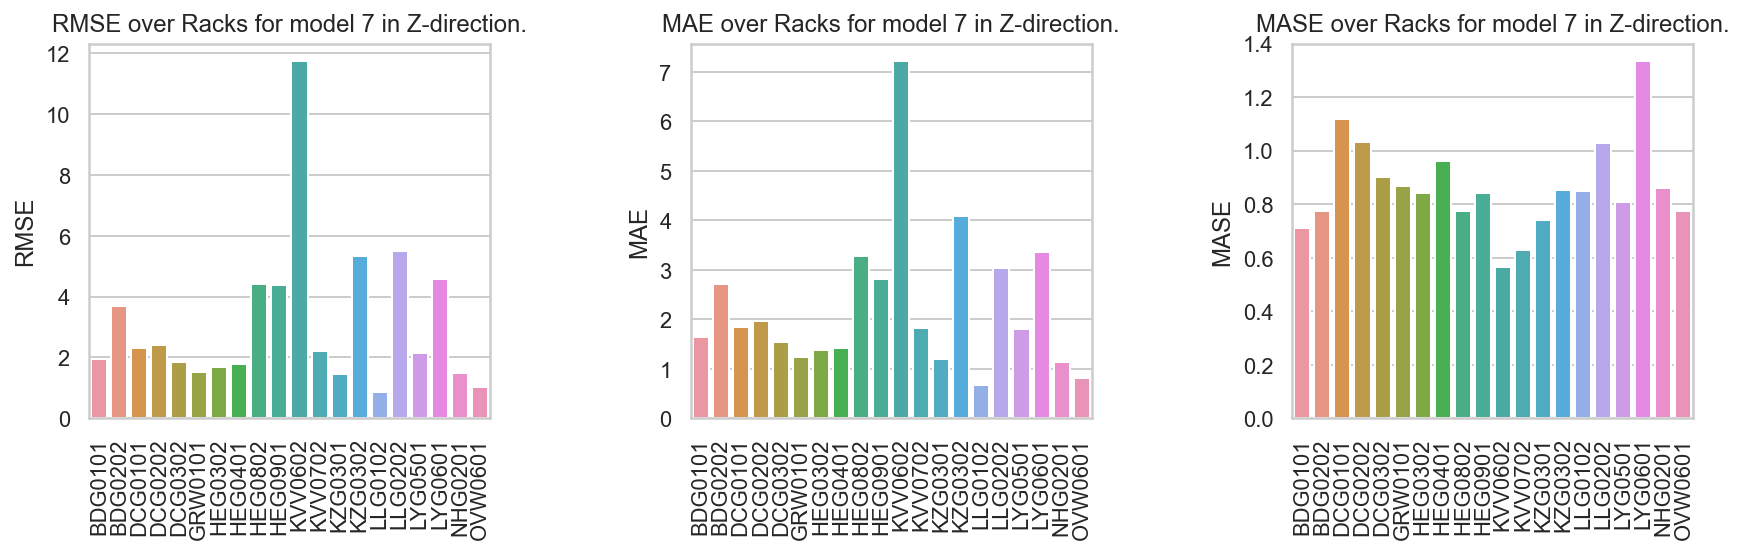

(None, None, None)

In [143]:
plot_metrics(results_inc_sat_cpt_x_test, '7', 'X'), plot_metrics(results_inc_sat_cpt_y_test, '7', 'Y'), plot_metrics(results_inc_sat_cpt_z_test, '7', 'Z')

### CPT <- Sat

In [ ]:
models_inc_cpt_sat_x = [load_models('INC_CPT_SAT', 'X')]
models_inc_cpt_sat_y = [load_models('INC_CPT_SAT', 'Y')]
models_inc_cpt_sat_z = [load_models('INC_CPT_SAT', 'Z')]

 25%|████████████████████▊                                                              | 5/20 [01:17<03:38, 14.59s/it]

In [37]:
results_inc_cpt_sat_x_test = evaluate_test('X', models_inc_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=True,  incremental_first='CPT')
results_inc_cpt_sat_y_test = evaluate_test('Y', models_inc_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=True,  incremental_first='CPT')
results_inc_cpt_sat_z_test = evaluate_test('Z', models_inc_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=True,  incremental_first='CPT')

In [38]:
print(np.mean(results_inc_cpt_sat_x_test, axis=1), np.mean(results_inc_cpt_sat_y_test, axis=1), np.mean(results_inc_cpt_sat_z_test, axis=1))

[1.76191531 1.41817729 0.83678671] [3.27124473 2.55005961 0.8499381 ] [1.79450152 1.4445878  0.85133696]


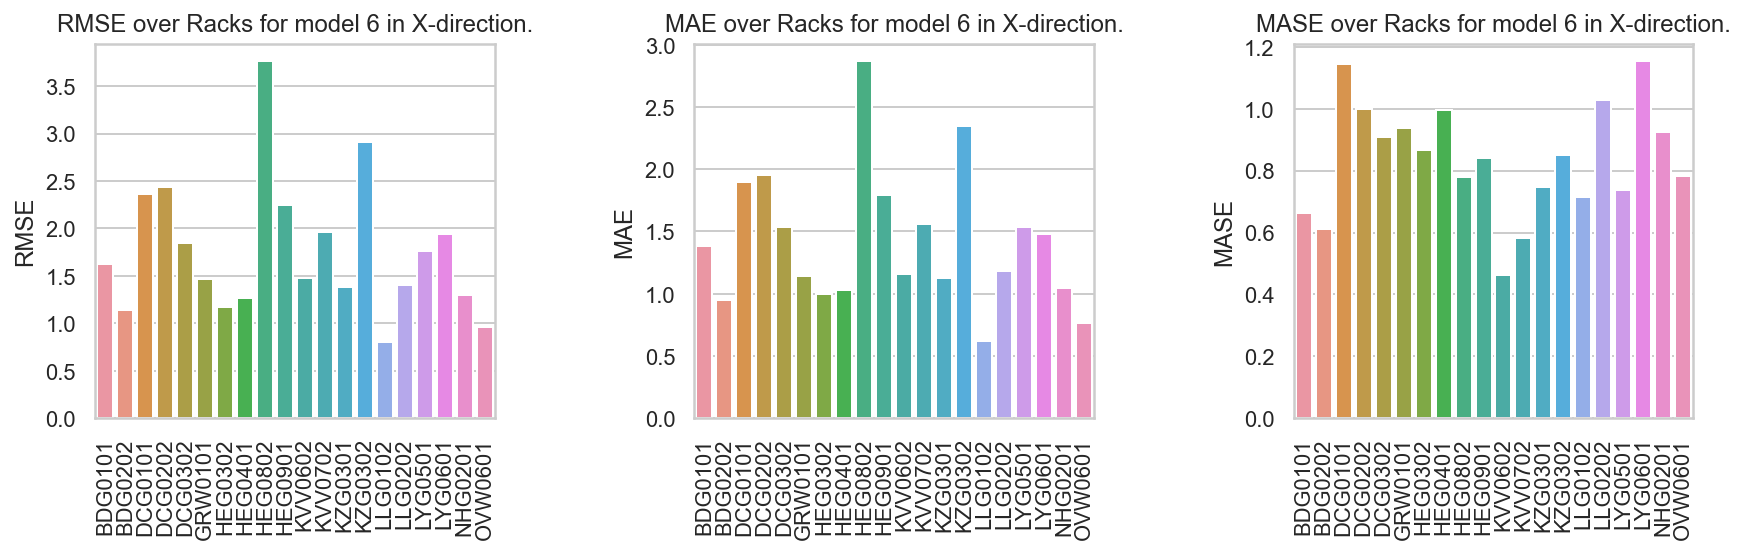

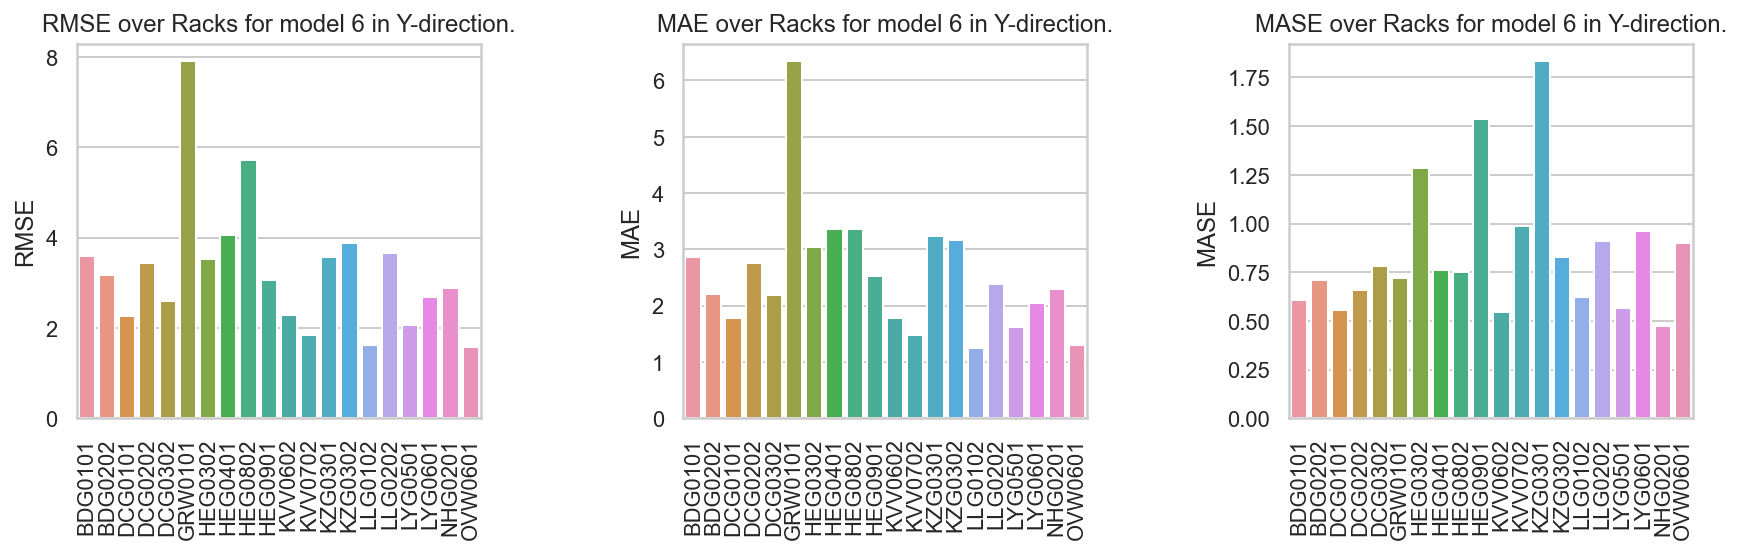

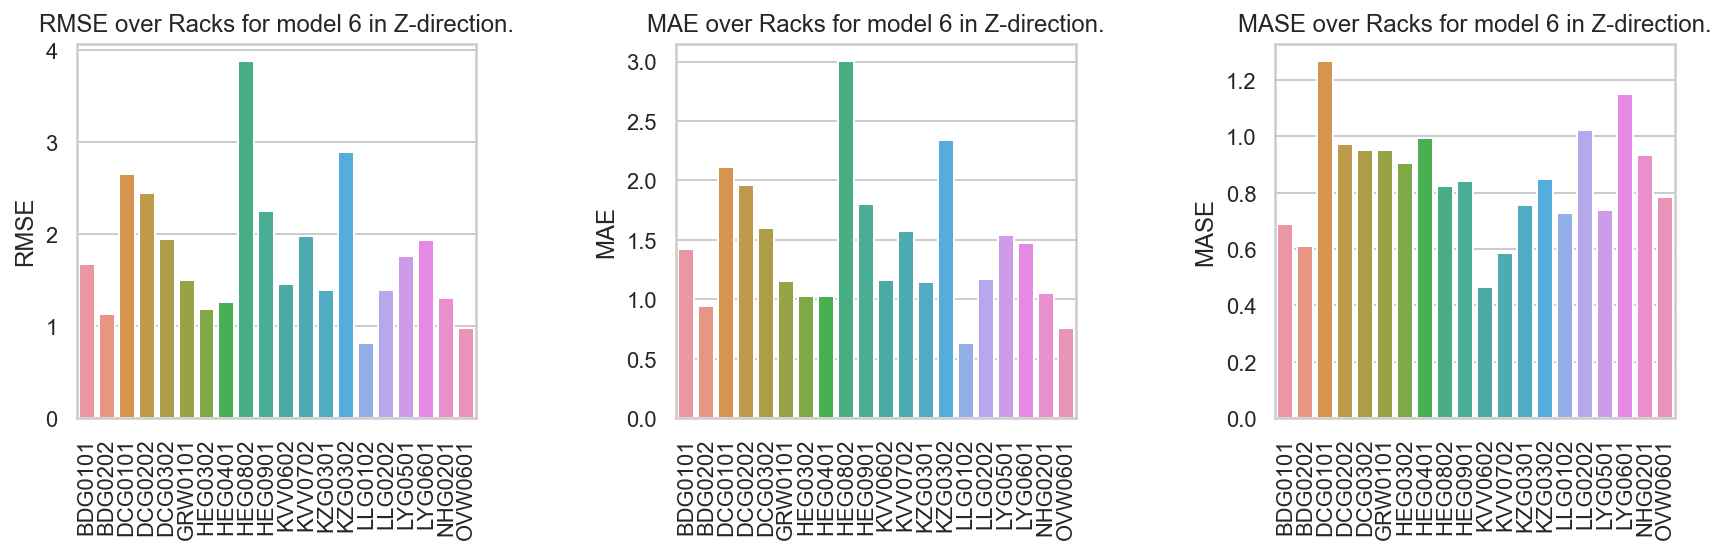

(None, None, None)

In [39]:
plot_metrics(results_inc_cpt_sat_x_test, '6', 'X'), plot_metrics(results_inc_cpt_sat_y_test, '6', 'Y'), plot_metrics(results_inc_cpt_sat_z_test, '6', 'Z')

### CPT + Sat

In [33]:
models_cpt_sat_x = [load_models('CPT_SAT', 'X')]
models_cpt_sat_y = [load_models('CPT_SAT', 'Y')]
models_cpt_sat_z = [load_models('CPT_SAT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


In [34]:
results_cpt_sat_x_test = evaluate_test('X', models_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=False, incremental=False)
results_cpt_sat_y_test = evaluate_test('Y', models_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=False, incremental=False)
results_cpt_sat_z_test = evaluate_test('Z', models_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=False, incremental=False)

In [35]:
print(np.mean(results_cpt_sat_x_test, axis=1), np.mean(results_cpt_sat_y_test, axis=1), np.mean(results_cpt_sat_z_test, axis=1))

[3.14625073 2.27714431 0.86360785] [4.74301458 3.47550669 0.83351191] [3.16594604 2.28928875 0.86810532]


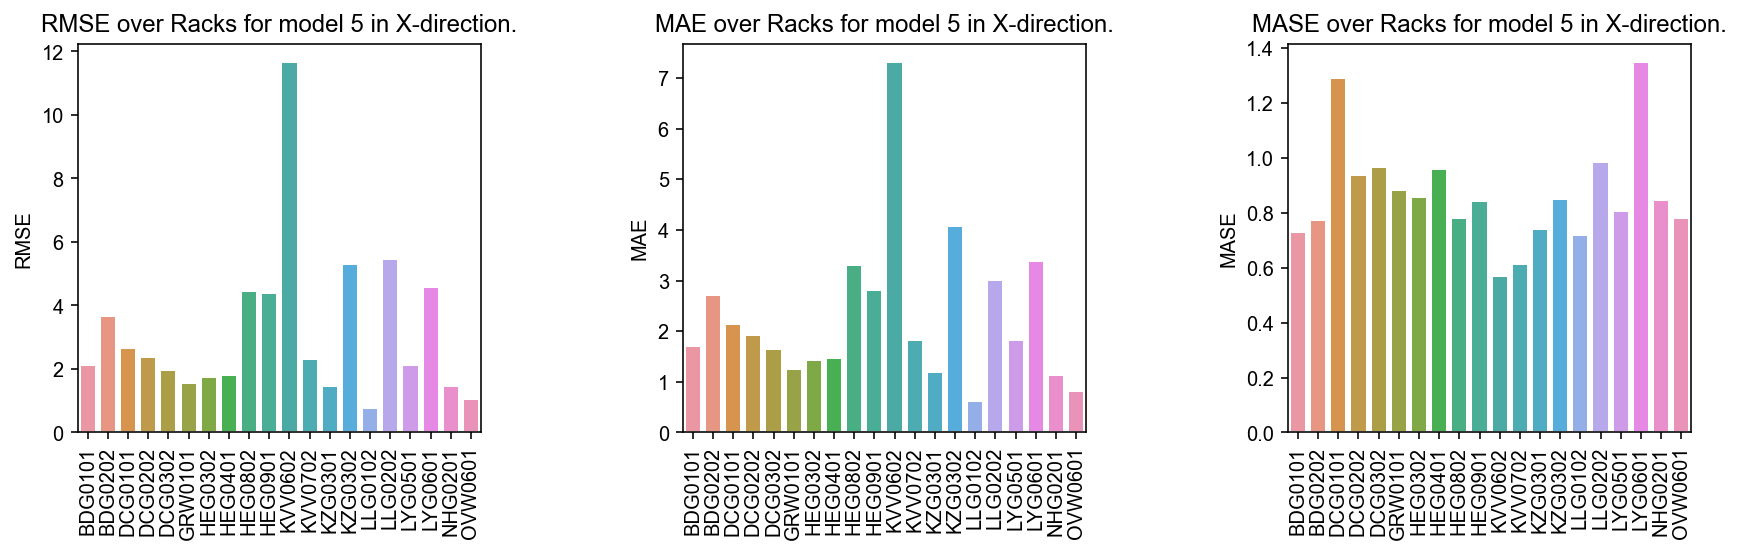

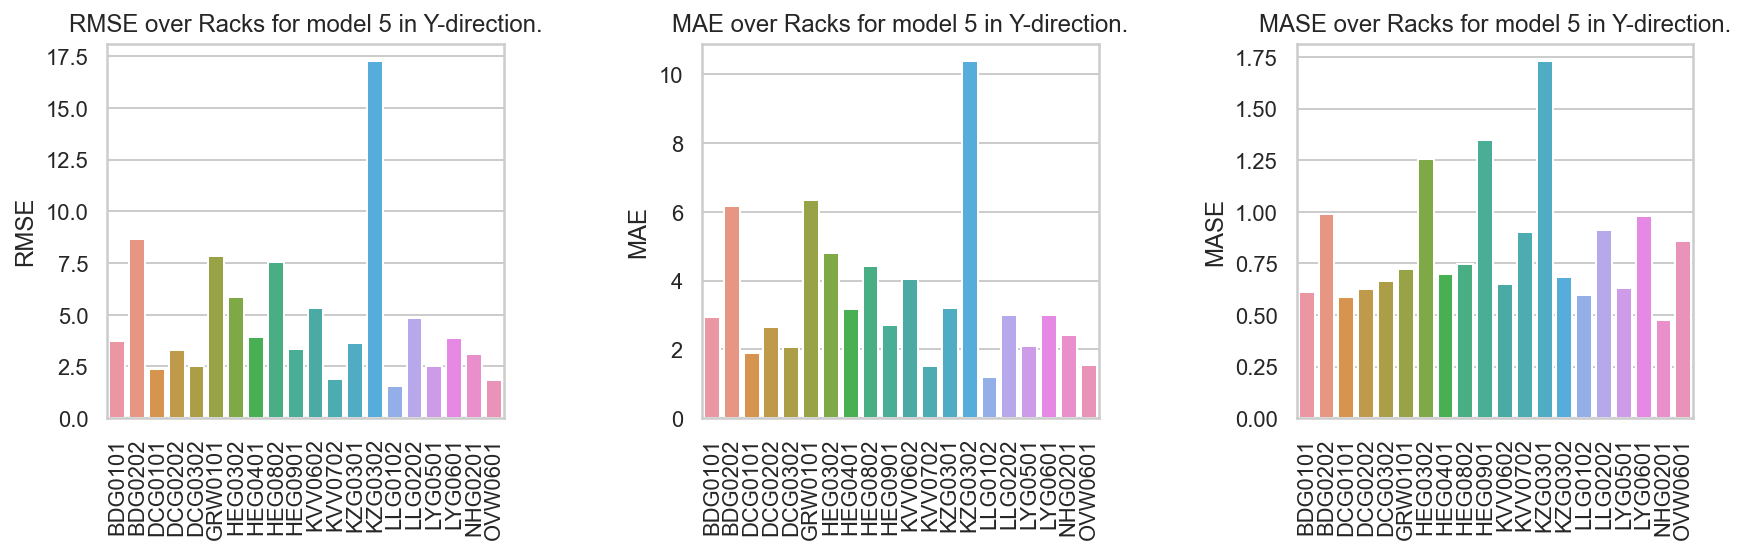

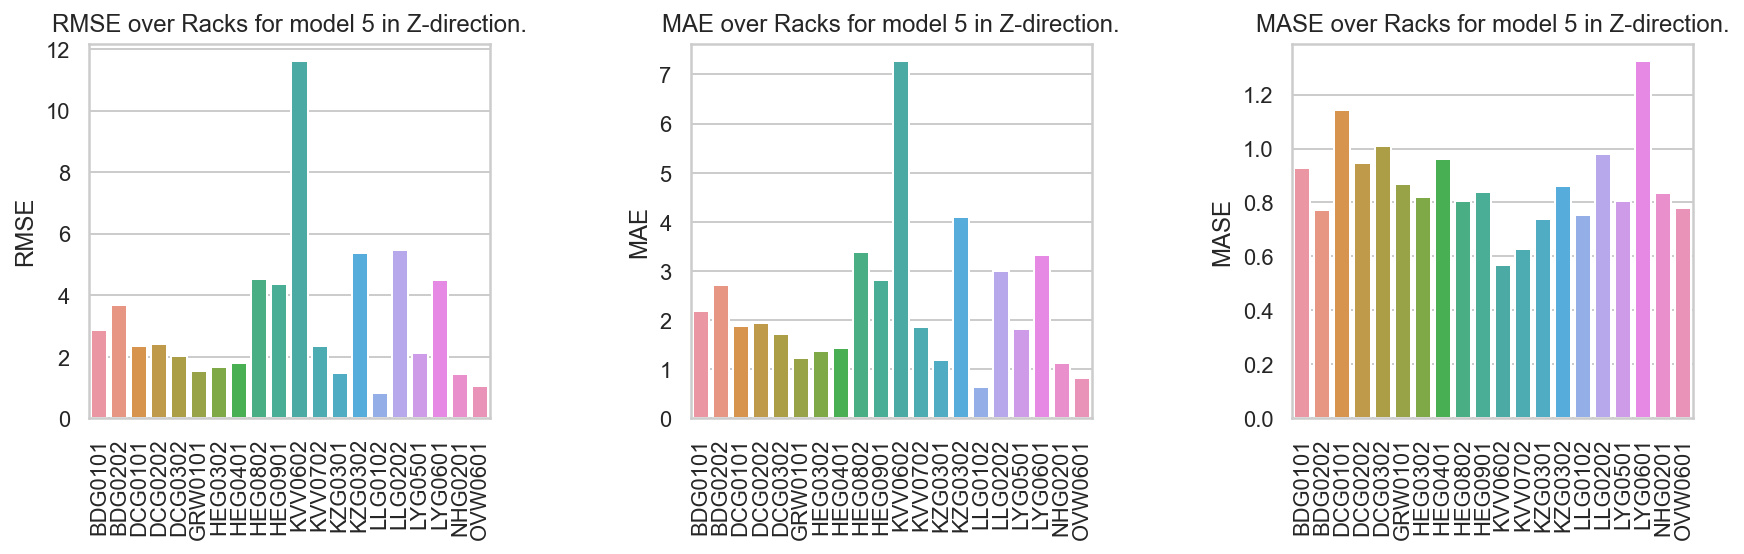

(None, None, None)

In [36]:
plot_metrics(results_cpt_sat_x_test, '5', 'X'), plot_metrics(results_cpt_sat_y_test, '5', 'Y'), plot_metrics(results_cpt_sat_z_test, '5', 'Z')

### Sat

In [37]:
models_sat_x = [load_models('SAT', 'X')]
models_sat_y = [load_models('SAT', 'Y')]
models_sat_z = [load_models('SAT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


In [38]:
results_sat_x_test = evaluate_test('X', models_sat_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=False)
results_sat_y_test = evaluate_test('Y', models_sat_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=False)
results_sat_z_test = evaluate_test('Z', models_sat_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=False)

In [39]:
print(np.mean(results_sat_x_test, axis=1), np.mean(results_sat_y_test, axis=1), np.mean(results_sat_z_test, axis=1))

[3.19505394 2.31435407 0.88757257] [4.74920084 3.47513799 0.83331555] [3.16682973 2.2959779  0.87253425]


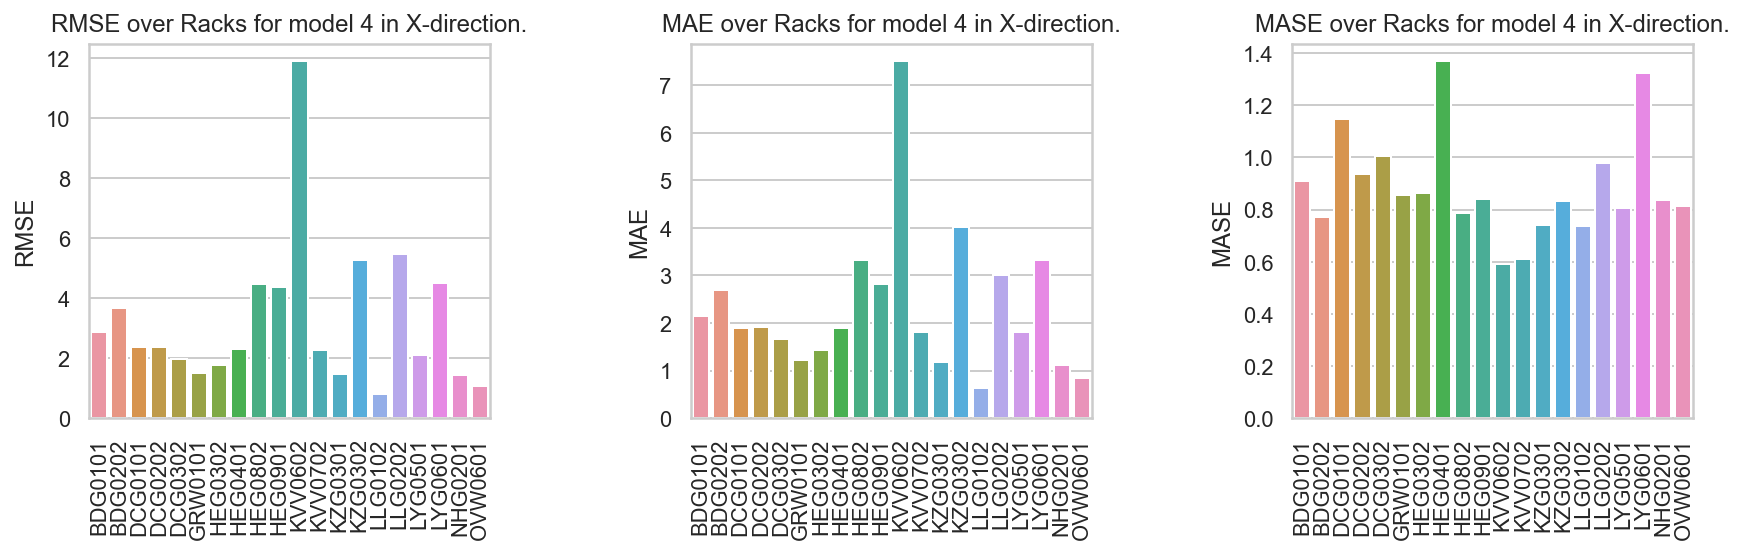

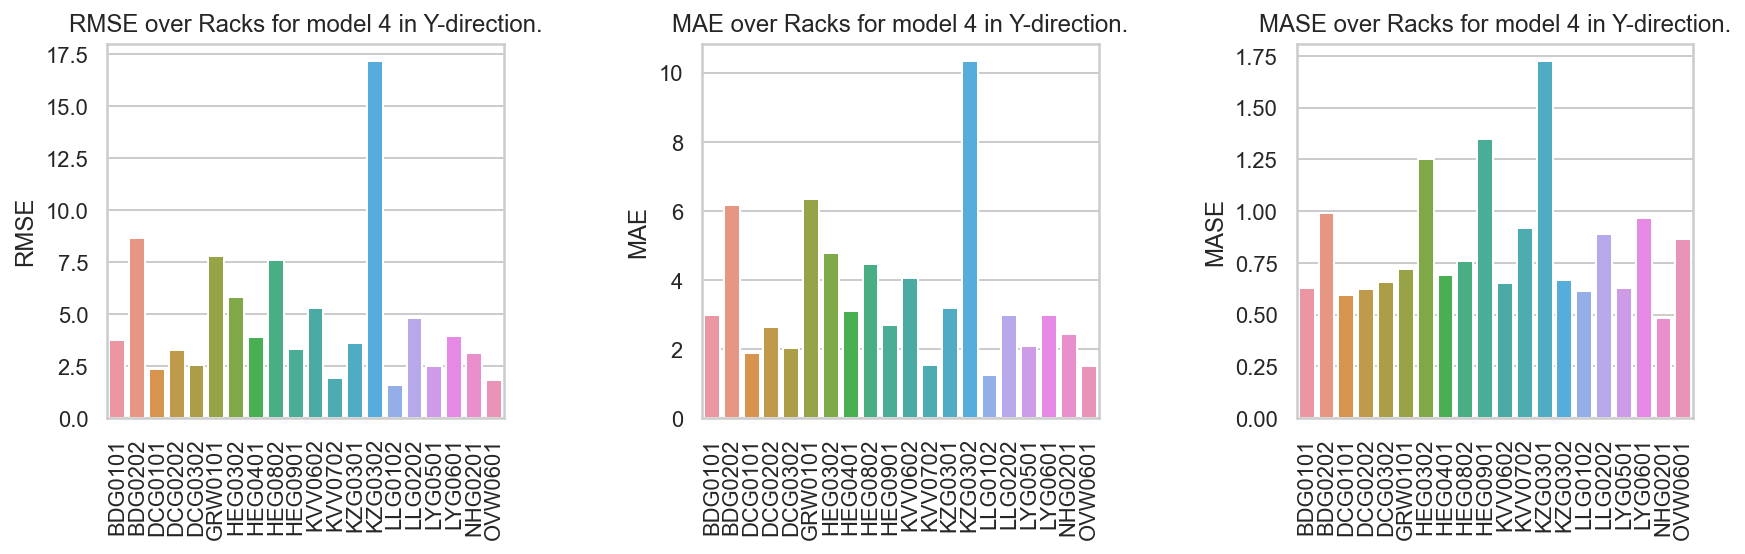

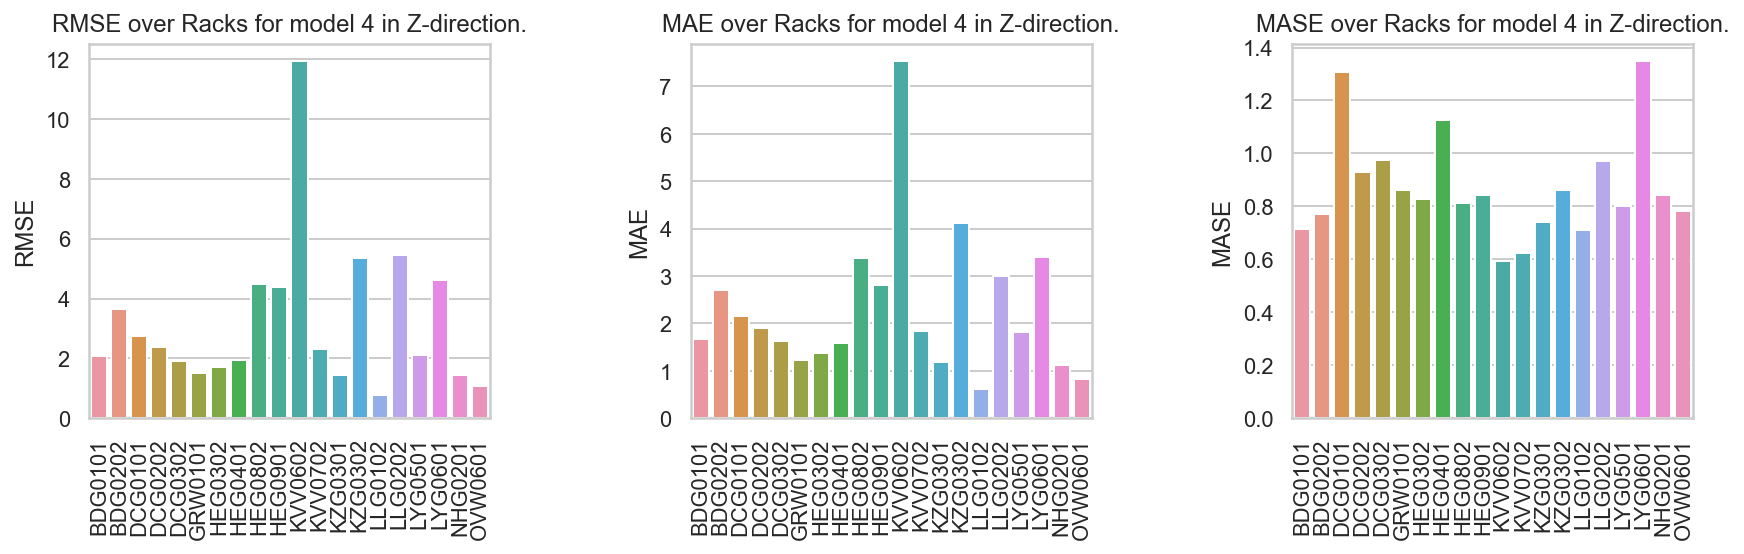

(None, None, None)

In [40]:
plot_metrics(results_sat_x_test, '4', 'X'), plot_metrics(results_sat_y_test, '4', 'Y'), plot_metrics(results_sat_z_test, '4', 'Z')

### Late fusion: base

In [45]:
results_agg_base_x_test = evaluate_late_fusion_test(direction='X', tacheometry=False, incremental=False)
results_agg_base_y_test = evaluate_late_fusion_test(direction='Y', tacheometry=False, incremental=False)
results_agg_base_z_test = evaluate_late_fusion_test(direction='Z', tacheometry=False, incremental=False)

In [46]:
print(np.mean(results_agg_base_x_test, axis=1), np.mean(results_agg_base_y_test, axis=1), np.mean(results_agg_base_z_test, axis=1))

[3.12027473 2.25695074 0.8634426 ] [4.66201529 3.41948727 0.82748863] [3.1128153  2.25053031 0.85830226]


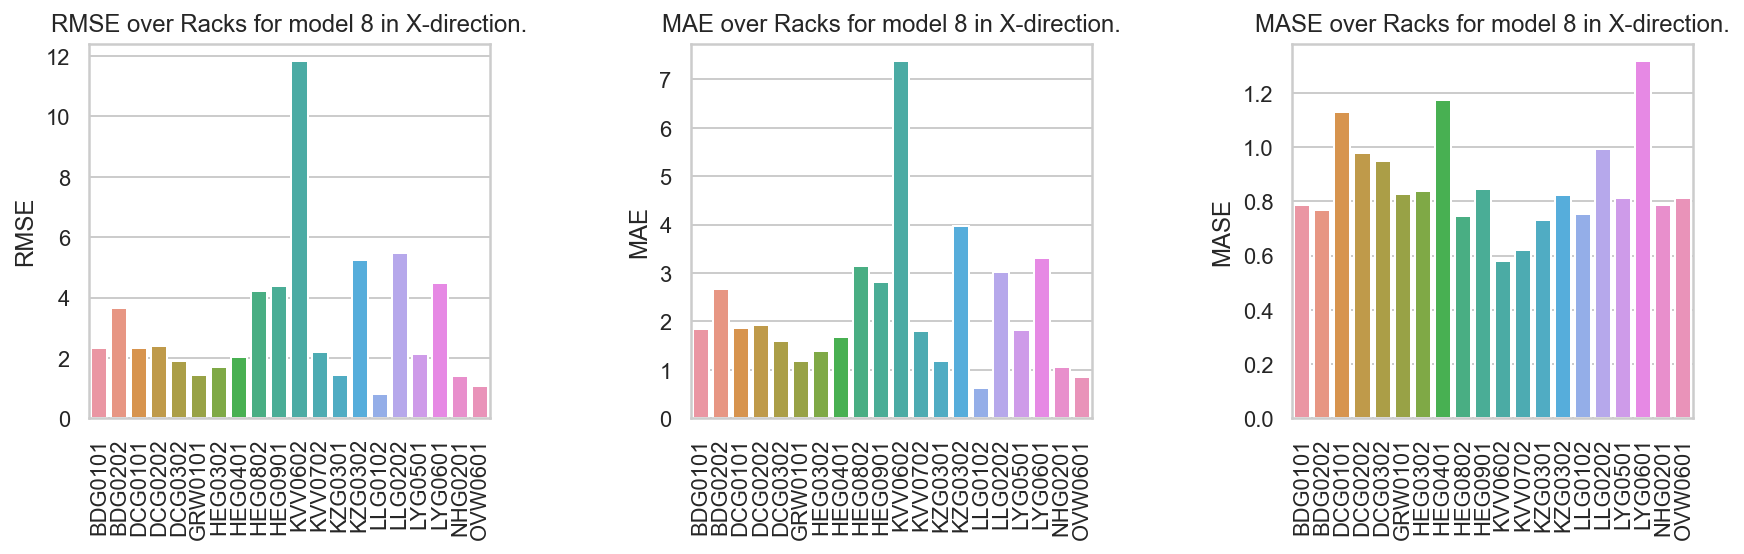

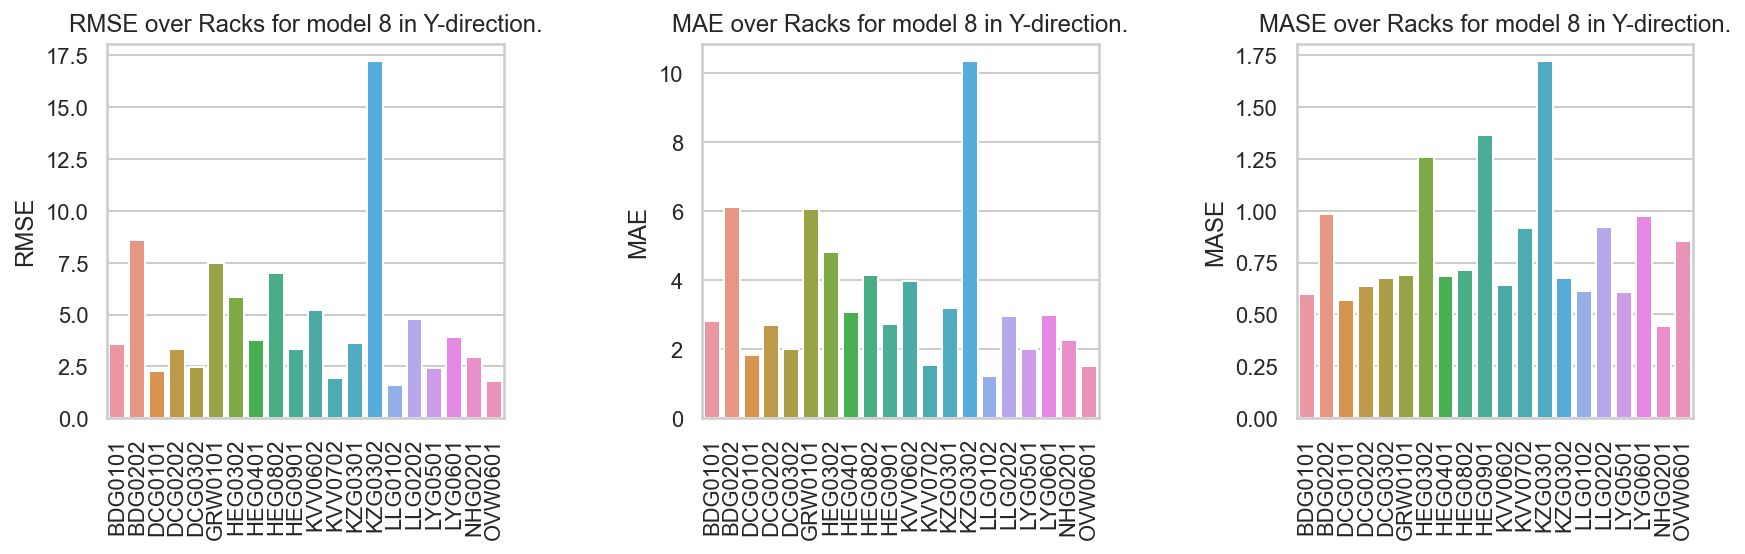

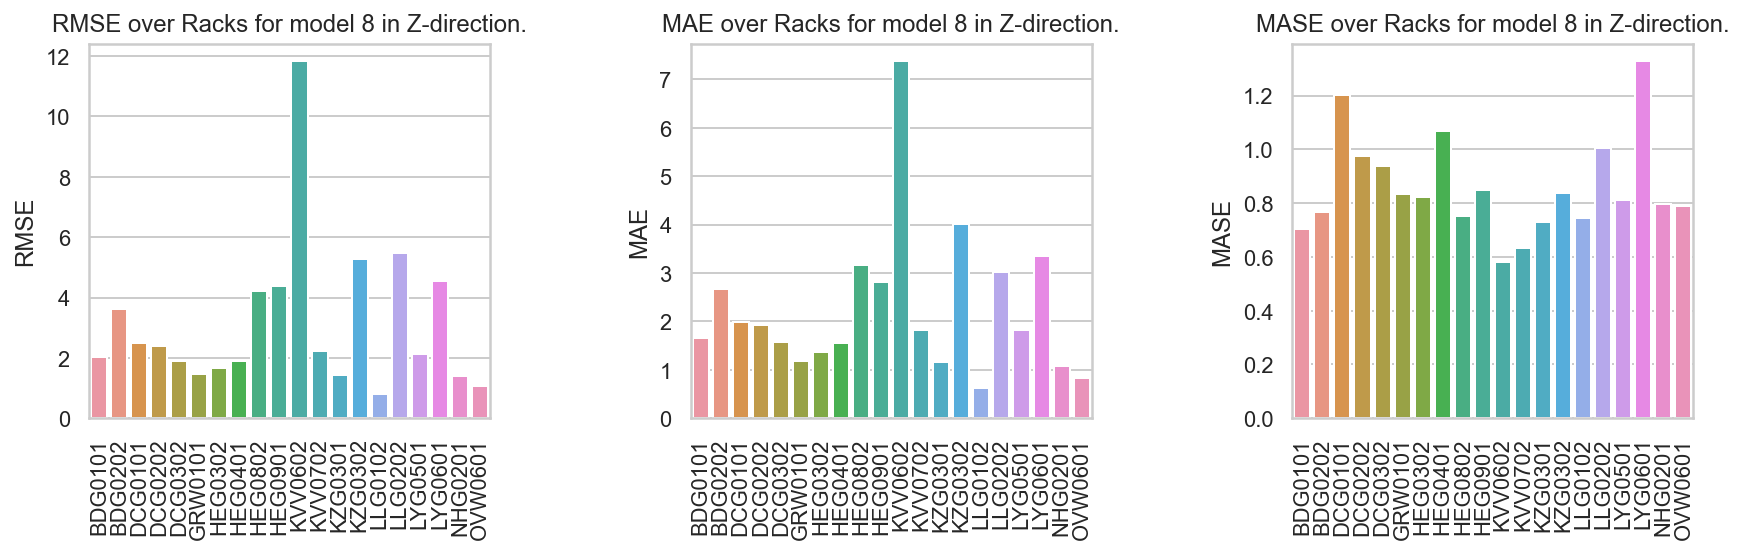

(None, None, None)

In [47]:
plot_metrics(results_agg_base_x_test, '8', 'X'), plot_metrics(results_agg_base_y_test, '8', 'Y'), plot_metrics(results_agg_base_z_test, '8', 'Z')

### Late fusion: incremental

In [ ]:
results_agg_inc_x_test = evaluate_late_fusion_test(direction='X', tacheometry=False, incremental=True)
results_agg_inc_y_test = evaluate_late_fusion_test(direction='Y', tacheometry=False, incremental=True)
results_agg_inc_z_test = evaluate_late_fusion_test(direction='Z', tacheometry=False, incremental=True)

In [ ]:
print(np.mean(results_agg_inc_x_test, axis=1), np.mean(results_agg_inc_y_test, axis=1), np.mean(results_agg_inc_z_test, axis=1))

In [ ]:
plot_metrics(results_agg_inc_x_test, '8', 'X'), plot_metrics(results_agg_inc_y_test, '8', 'Y'), plot_metrics(results_agg_inc_z_test, '8', 'Z')

# Obtain predictions after test set

In [133]:
def predictions_after(direction, models, input_width, label_width, shift, incl_cpt=False, incl_sat=False, tacheometry=False, incremental=False, incremental_first='CPT'):
    
    # set df to corresponding direction
    if direction == 'X':
        df = test_Yx.iloc[:,5:]
                
    if direction == 'Y':
        df = test_Yy.iloc[:,5:]
        
    if direction == 'Z':
        df = test_Yz.iloc[:,5:]
        
    val_rmse = []
    val_mae = []
    val_mase = []
    all_predictions = pd.DataFrame()
    
    for i, obj in enumerate(df.index.str[:7].unique()):    
        
        X, Y = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=incl_cpt, \
                                     incl_sat=incl_sat, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
        
        if models == 'naive':
            naives = NaiveBaseline(X, Y)
            val_rmse.append(naives[0])
            val_mae.append(naives[1])
            val_mase.append(naives[2])
            continue
            
        else:
        
            model = models[i]

            if incremental == True:

                X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=True, \
                                               tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

                X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=False, \
                                               tacheometry=False, incl_sat=True)

                if incremental_first == 'CPT':
                    predictions = model.predict([X, X_sat2])
                else:
                    predictions = model.predict([X, X_cpt2])

            else:
                predictions = model.predict(X)
            
            predictions = pd.DataFrame(np.reshape(predictions, (-1, 5)))
            predictions = predictions.set_index(df[df.index.str.contains(obj)].index)
            all_predictions = pd.concat([all_predictions, predictions])
        
    return all_predictions

In [85]:
models_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
models_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.35s/it]


In [134]:
predictions_y = predictions_after('Y', models_inc_tcmt_sat_cpt_y[0], 10, 0, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')

In [135]:
# results_inc_tcmt_sat_cpt_x_test = evaluate_test('X', models_inc_tcmt_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
predictions_y = predictions_after('Y', models_inc_tcmt_sat_cpt_y[0], 10, 0, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')
predictions_z = predictions_after('Z', models_inc_tcmt_sat_cpt_x[0], 10, 0, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat')

In [152]:
y_coords = pd.read_csv('../Data/TargetY.csv', index_col=0).iloc[:,:3]
z_coords = pd.read_csv('../Data/TargetZ.csv', index_col=0).iloc[:,:3]
predictions_y = y_coords.join(predictions_y, how='inner')
predictions_z = z_coords.join(predictions_z, how='inner')

In [154]:
total_y = predictions_y.iloc[:,3:].apply(lambda x: x.loc[x.last_valid_index()], axis=1)
total_z = predictions_z.iloc[:,3:].apply(lambda x: x.loc[x.last_valid_index()], axis=1)

In [155]:
speed_y = predictions_y.iloc[:,3:].diff(axis=1).mean(axis=1)
speed_z = predictions_z.iloc[:,3:].diff(axis=1).mean(axis=1)

In [156]:
df_agg_values = pd.DataFrame({'total_y':total_y, 'total_z':total_z, 'speed_y':speed_y, 'speed_z':speed_z})

In [158]:
df_agg_values['X_coordinate'] = predictions_y['X_coordinate']
df_agg_values['Y_coordinate'] = predictions_y['Y_coordinate']

In [160]:
df_agg_values['RiskScore'] = 1

medium_risk = df_agg_values[(df_agg_values['total_y'].abs() >= 15) | (df_agg_values['total_z'].abs() >= 15) | \
             (df_agg_values['speed_y'].abs() >= 5) | (df_agg_values['speed_z'].abs() >= 5)].index
high_risk = df_agg_values[(df_agg_values['total_y'].abs() >= 25) | (df_agg_values['total_z'].abs() >= 25) | \
             (df_agg_values['speed_y'].abs() >= 10) | (df_agg_values['speed_z'].abs() >= 10)].index
acute_risk = df_agg_values[(df_agg_values['total_y'].abs() > 35) | (df_agg_values['total_z'].abs() > 35) | \
             (df_agg_values['speed_y'].abs() > 15) | (df_agg_values['speed_z'].abs() > 15)].index

df_agg_values.loc[medium_risk, 'RiskScore'] = 2
df_agg_values.loc[high_risk, 'RiskScore'] = 3
df_agg_values.loc[acute_risk, 'RiskScore'] = 4

In [162]:
df_agg_values.RiskScore.unique()

array([1, 2], dtype=int64)

In [164]:
df_agg_values = df_agg_values[df_agg_values['X_coordinate'] > 100000]
df_agg_values['points'] = gpd.points_from_xy(df_agg_values['X_coordinate'], df_agg_values['Y_coordinate'])
gdf_agg = gpd.GeoDataFrame(df_agg_values, crs="EPSG:28992", geometry=df_agg_values['points'])
gdf_agg = gdf_agg.to_crs("EPSG: 4326")

C:\Users\julia\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


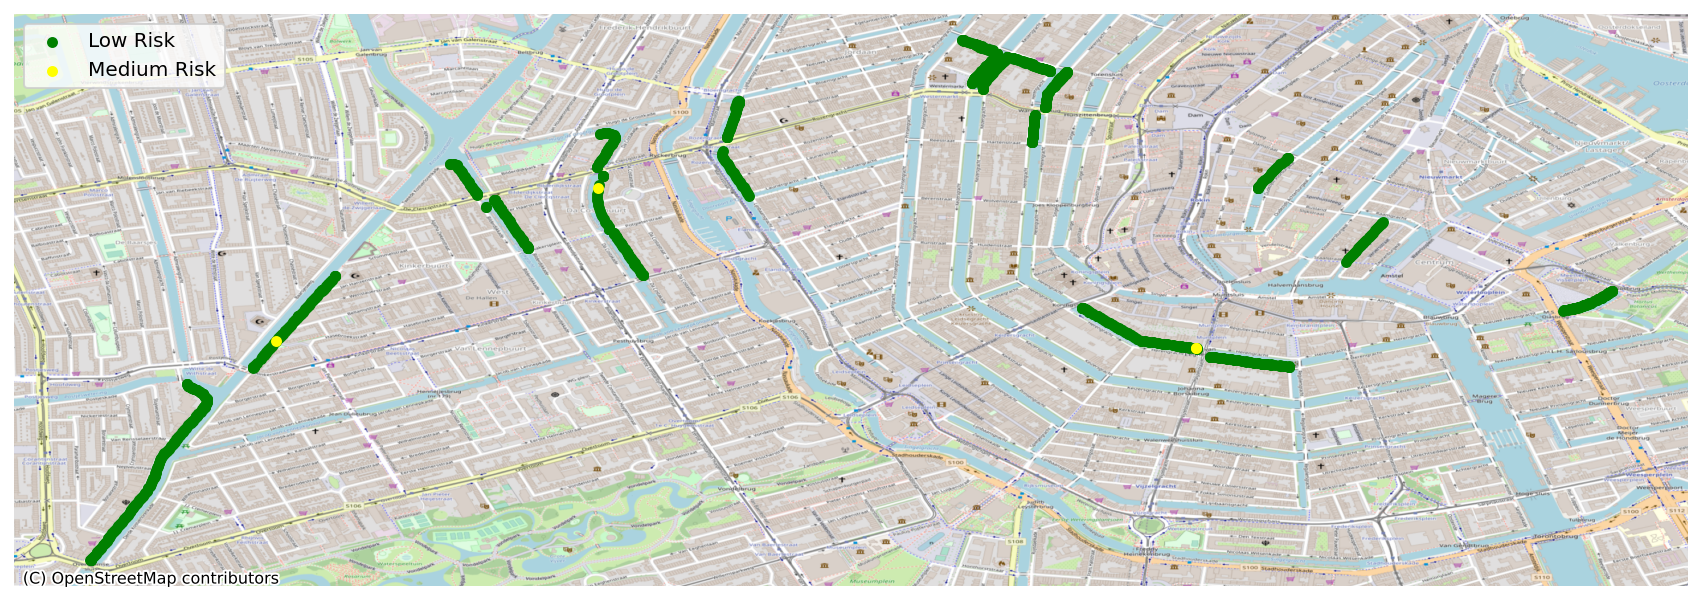

In [165]:
fig, ax = plt.subplots(figsize=(15,15))

gdf_agg[gdf_agg['RiskScore'] == 1].plot(ax=ax, color='g', markersize=20, label='Low Risk')
gdf_agg[gdf_agg['RiskScore'] == 2].plot(ax=ax, color='yellow', markersize=20, label='Medium Risk')
gdf_agg[gdf_agg['RiskScore'] == 3].plot(ax=ax, color='orange', markersize=20, label='High Risk')
gdf_agg[gdf_agg['RiskScore'] == 4].plot(ax=ax, color='r', markersize=20, label='Acute Risk')

cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_agg.crs)
plt.legend(loc='upper left')
ax.axis('off')
plt.show()

In [167]:
df_agg_values.to_csv('../Data/ARK_risk_scores.csv', index=True) 